# Preamble

In [1]:
import os

current_dir = os.getcwd()

print("Current working directory:", current_dir)

Current working directory: /work/mherre/master-projectV3/master-projectV2/notebooks


# Dataset Overview

In [2]:
import openml
import pandas as pd
import json
import os

def generate_dataset_overview():
    # Load dataset ids from json file
    json_file_path = os.path.join("../config", "config.json")
    with open(json_file_path, "r") as file:
        config = json.load(file)

    # Datasets are in data[datasets]
    dataset_ids = config["data"]["datasets"]

    # Convert dataset_ids to standard Python integers
    dataset_ids = [int(dataset_id) for dataset_id in dataset_ids]

    regression_data = []
    binary_data = []

    for dataset_id in dataset_ids:
        # Get dataset name from OpenML
        dataset = openml.datasets.get_dataset(dataset_id)
        name = dataset.name

        # Load the actual data to get features
        X, y, categorical_indicator, attribute_names = dataset.get_data(
            dataset_format="dataframe", target=dataset.default_target_attribute
        )

        # Calculate statistics
        n_samples = len(X)
        n_features = X.shape[1]
        n_cat_features = sum(categorical_indicator)

        # Determine if it's regression or binary classification
        if pd.api.types.is_numeric_dtype(y) and len(y.unique()) > 2:
            # Regression dataset
            task_type = "regression"
            data_entry = {
                "Name": name,
                "Samples": n_samples,
                "Features": n_features,
                "Cat Features": n_cat_features,
                "OpenML ID": dataset_id,
            }
            regression_data.append(data_entry)
        elif len(y.unique()) == 2:
            # Binary classification dataset
            task_type = "binary"
            value_counts = y.value_counts(normalize=True)
            minority_class_pct = min(value_counts) * 100
            
            data_entry = {
                "Name": name,
                "Samples": n_samples,
                "Features": n_features,
                "Cat Features": n_cat_features,
                "Minority Class (%)": round(minority_class_pct, 2),
                "OpenML ID": dataset_id,
            }
            binary_data.append(data_entry)

    # Create DataFrames
    regression_df = pd.DataFrame(regression_data)
    binary_df = pd.DataFrame(binary_data)

    # Define columns for each type
    regression_cols = ["Name", "Samples", "Features", "Cat Features", "OpenML ID"]
    binary_cols = ["Name", "Samples", "Features", "Cat Features", "Minority Class (%)", "OpenML ID"]

    # Reorder columns and sort by samples
    if not regression_df.empty:
        regression_df = regression_df[regression_cols].sort_values(by="Samples", ascending=True)
    
    if not binary_df.empty:
        binary_df = binary_df[binary_cols].sort_values(by="Samples", ascending=True)

    return regression_df, binary_df

In [3]:
# Generate the two separate tables
regression_table, binary_table = generate_dataset_overview()

print("REGRESSION DATASETS")
display(regression_table.style.hide(axis="index"))

print("\nBINARY CLASSIFICATION DATASETS")
display(binary_table.style.hide(axis="index").format({"Minority Class (%)": "{:.2f}"}))

REGRESSION DATASETS


Name,Samples,Features,Cat Features,OpenML ID
analcatdata_supreme,4052,7,0,504
wine_quality,6497,11,0,287
cpu_act,8192,21,0,197
visualizing_soil,8641,4,1,688
yprop_4_1,8885,251,0,416
sulfur,10081,6,0,23515
Brazilian_houses,10692,12,4,42688



BINARY CLASSIFICATION DATASETS


Name,Samples,Features,Cat Features,Minority Class (%),OpenML ID
dresses-sales,500,12,11,42.00,23381
climate-model-simulation-crashes,540,18,0,8.52,40994
cylinder-bands,540,37,19,42.22,6332
wdbc,569,30,0,37.26,1510
ilpd,583,10,1,28.64,1480
tokyo1,959,44,2,36.08,40705
qsar-biodeg,1055,41,0,33.74,1494
ozone-level-8hr,2534,72,0,6.31,1487
madelon,2600,500,0,50.00,1485
wilt,4839,5,0,5.39,40983


#  Performance Tables


In [4]:
import pandas as pd
import json
import os
import numpy as np
from IPython.display import display

def load_all_results():
    """Load all teacher and student results from the results directory."""
    results_dir = "../results"
    all_results = {}
    
    # Load teacher results
    teacher_dir = os.path.join(results_dir, "teacher")
    if os.path.exists(teacher_dir):
        for file in os.listdir(teacher_dir):
            if file.endswith("_results.json"):
                dataset_id = file.split("_")[0]
                with open(os.path.join(teacher_dir, file), 'r') as f:
                    teacher_data = json.load(f)
                
                if dataset_id not in all_results:
                    all_results[dataset_id] = {}
                
                for key, result in teacher_data.items():
                    model_type = result.get("model_type", "unknown")
                    use_hpo = result.get("use_hpo", False)
                    task_type = result.get("task_type", "unknown")
                    # Create unique key that includes HPO setting
                    unique_key = f"{model_type}_teacher_hpo{use_hpo}"
                    all_results[dataset_id][unique_key] = result
    
    # Load student results
    student_dir = os.path.join(results_dir, "student")
    if os.path.exists(student_dir):
        for file in os.listdir(student_dir):
            if file.endswith("_results.json"):
                dataset_id = file.split("_")[0]
                with open(os.path.join(student_dir, file), 'r') as f:
                    student_data = json.load(f)
                
                if dataset_id not in all_results:
                    all_results[dataset_id] = {}
                
                for key, result in student_data.items():
                    student_model = result.get("student_model_type", "unknown")
                    teacher_model = result.get("teacher_model_type", "unknown")
                    use_hpo = result.get("use_hpo", False)
                    task_type = result.get("student_task_type", result.get("task_type", "unknown"))
                    # Create unique key that includes HPO setting and student task type
                    unique_key = f"{student_model}({teacher_model})_student_hpo{use_hpo}_{task_type}"
                    all_results[dataset_id][unique_key] = result
    
    return all_results

def get_dataset_info():
    """Get dataset information including names and sizes."""
    json_file_path = os.path.join("../config", "config.json")
    with open(json_file_path, "r") as file:
        config = json.load(file)
    
    dataset_ids = [str(id) for id in config["data"]["datasets"]]
    
    # You can extend this to get actual dataset sizes from your data
    # For now, we'll use placeholder sizes or load from cached data
    dataset_info = {}
    
    # Try to get sizes from your cached data or OpenML
    import openml
    for dataset_id in dataset_ids:
        try:
            dataset = openml.datasets.get_dataset(int(dataset_id))
            X, y, _, _ = dataset.get_data(dataset_format="dataframe", target=dataset.default_target_attribute)
            dataset_info[dataset_id] = {
                'name': dataset.name,
                'size': len(X),
                'task_type': 'binary' if len(y.unique()) == 2 else 'regression'
            }
        except:
            dataset_info[dataset_id] = {
                'name': f'Dataset_{dataset_id}',
                'size': 0,
                'task_type': 'unknown'
            }
    
    return dataset_info

def create_results_table(metric='f1', task_filter=None, model_filter=None, hpo_filter=None, student_task_filter=None):
    """
    Create a comprehensive results table.
    
    Parameters:
    -----------
    metric : str
        The metric to display (e.g., 'f1', 'acc', 'roc', 'mae', 'mse', 'rmse', 'r2')
    task_filter : str or None
        Filter by task type ('binary', 'regression', or None for all)
    model_filter : str or None
        Filter by model type ('teacher', 'student', 'both', or None for all).
        If None, defaults to 'both'.
    hpo_filter : bool or None
        Filter by use_hpo flag (True for HPO used, False for no HPO, None for all)
    student_task_filter : str or None
        Filter student models by their task type ('binary', 'regression', or None for all)
    """
    all_results = load_all_results()
    dataset_info = get_dataset_info()
    
    table_data = []
    
    for dataset_id, models_data_for_dataset in all_results.items():
        if dataset_id not in dataset_info:
            continue
            
        current_dataset_info = dataset_info[dataset_id]
        
        # Filter by task type if specified
        if task_filter and current_dataset_info['task_type'] != task_filter:
            continue

        # Initialize row with dataset-specific info
        row = {
            'Dataset ID': dataset_id,
            'Dataset Name': current_dataset_info['name'],
            'Size': current_dataset_info['size'],
            'Task Type': current_dataset_info['task_type']
        }
        
        at_least_one_filtered_model_has_data = False
        
        for model_name, result in models_data_for_dataset.items():
            # Determine if this model should be included based on model_filter
            include_this_model = False
            if model_filter == 'teacher':
                if '_teacher_hpo' in model_name:
                    include_this_model = True
            elif model_filter == 'student':
                if '_student_hpo' in model_name:
                    include_this_model = True
                    # Apply student task filter if specified
                    if include_this_model and student_task_filter is not None:
                        # Extract student task type from the model name
                        if model_name.endswith(f'_{student_task_filter}'):
                            include_this_model = True
                        else:
                            include_this_model = False
            elif model_filter == 'both' or model_filter is None:
                include_this_model = True
                # Apply student task filter only to student models
                if '_student_hpo' in model_name and student_task_filter is not None:
                    if not model_name.endswith(f'_{student_task_filter}'):
                        include_this_model = False

            # Apply HPO filter if specified
            if include_this_model and hpo_filter is not None:
                use_hpo = result.get('use_hpo', False)
                if hpo_filter != use_hpo:
                    include_this_model = False

            if include_this_model:
                mean_key = f"mean_{metric}"
                std_key = f"std_{metric}"
                
                if mean_key in result and std_key in result:
                    mean_val = result[mean_key]
                    std_val = result[std_key]
                    row[model_name] = f"{mean_val:.4f} ± {std_val:.4f}" if metric == "inference_time" else f"{mean_val:.3f} ± {std_val:.3f}" 
                    at_least_one_filtered_model_has_data = True
                elif metric in result:  # Fallback if no std available
                    row[model_name] = f"{result[metric]:.3f}"
                    at_least_one_filtered_model_has_data = True
                else:
                    # Model is selected by filter, but lacks the specific metric.
                    # Add it as a column with "N/A".
                    row[model_name] = "N/A"
        
        # If no model that passed the filter actually had the metric data, skip this dataset row.
        if not at_least_one_filtered_model_has_data:
            continue
            
        table_data.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(table_data)
    
    if df.empty:
        print(f"No results found for metric '{metric}' with task filter '{task_filter}', model filter '{model_filter}', HPO filter '{hpo_filter}', and student task filter '{student_task_filter}'")
        return df
    
    # Sort by dataset size
    df = df.sort_values('Size', ascending=True)
    
    # Reorder columns: Dataset info first, then models
    info_cols = ['Dataset ID', 'Dataset Name', 'Size', 'Task Type']
    # Model columns are dynamically determined by what was added to the rows
    model_cols = [col for col in df.columns if col not in info_cols]
    df = df[info_cols + sorted(model_cols)]
    
    return df

def display_results_table(metric='f1', task_filter=None, model_filter=None, hpo_filter=None, student_task_filter=None):
    """Display the results table with styling."""
    df = create_results_table(metric, task_filter, model_filter, hpo_filter, student_task_filter)
    
    if df.empty:
        return
    
    print(f"Results Table - Metric: {metric.upper()}")
    if task_filter:
        print(f"Task Filter: {task_filter}")
    if hpo_filter is not None:
        print(f"HPO Filter: {'With HPO' if hpo_filter else 'Without HPO'}")
    if student_task_filter:
        print(f"Student Task Filter: {student_task_filter}")
    print("="*80)
    
    # Style the table
    styled_df = df.style.hide(axis="index")
    
    # Apply formatting
    styled_df = styled_df.format({
        'Size': '{:,}',
        'Dataset ID': lambda x: str(x)
    })
    
    display(styled_df)
    
    return df


In [5]:
# First, let's see what metrics are available
print("\n" + "="*50)
table = display_results_table(metric='f1', task_filter='binary', model_filter='teacher', hpo_filter=True, student_task_filter='regression')

# Export table to CSV
if not table.empty:
    output_csv_path = os.path.join("../results", "results.csv")
    table.to_csv(output_csv_path, index=False)
    print(f"Results exported to {output_csv_path}")


Results Table - Metric: F1
Task Filter: binary
HPO Filter: With HPO
Student Task Filter: regression


Dataset ID,Dataset Name,Size,Task Type,catboost_teacher_hpoTrue,grande_teacher_hpoTrue,mlp_teacher_hpoTrue,random_forest_teacher_hpoTrue,tabm_teacher_hpoTrue,tabpfn_teacher_hpoTrue
23381,dresses-sales,500,binary,0.512 ± 0.032,0.593 ± 0.041,0.545 ± 0.042,0.558 ± 0.039,0.574 ± 0.032,0.599 ± 0.052
40994,climate-model-simulation-crashes,540,binary,0.728 ± 0.110,0.787 ± 0.083,0.752 ± 0.041,0.770 ± 0.099,0.766 ± 0.085,0.811 ± 0.105
6332,cylinder-bands,540,binary,0.755 ± 0.076,0.760 ± 0.041,0.764 ± 0.040,0.808 ± 0.049,0.775 ± 0.063,0.753 ± 0.050
1510,wdbc,569,binary,0.941 ± 0.027,0.970 ± 0.017,0.974 ± 0.010,0.949 ± 0.015,0.970 ± 0.024,0.974 ± 0.011
1480,ilpd,583,binary,0.556 ± 0.037,0.618 ± 0.050,0.585 ± 0.042,0.572 ± 0.047,0.605 ± 0.025,0.528 ± 0.022
40705,tokyo1,959,binary,0.914 ± 0.014,0.923 ± 0.019,0.896 ± 0.018,0.922 ± 0.015,0.923 ± 0.026,0.915 ± 0.013
1494,qsar-biodeg,"1,055",binary,0.853 ± 0.023,0.844 ± 0.014,0.861 ± 0.012,0.842 ± 0.007,0.866 ± 0.018,0.865 ± 0.017
1487,ozone-level-8hr,"2,534",binary,0.633 ± 0.032,0.688 ± 0.043,0.735 ± 0.034,0.621 ± 0.052,0.744 ± 0.047,0.695 ± 0.048
1485,madelon,"2,600",binary,0.863 ± 0.012,0.811 ± 0.014,0.568 ± 0.017,0.861 ± 0.016,0.622 ± 0.036,0.895 ± 0.006
40983,wilt,"4,839",binary,0.925 ± 0.018,0.942 ± 0.015,0.936 ± 0.017,0.920 ± 0.016,0.946 ± 0.012,0.944 ± 0.015


Results exported to ../results/results.csv


# Normalized Mean and MRR

In [6]:
def calculate_normalized_mean_and_mrr(metric='f1', task_filter=None, model_filter='both', hpo_filter=None, student_task_filter=None):
    """
    Calculate normalized mean performance, standard mean, and Mean Reciprocal Rank (MRR) across all datasets and models.
    
    Parameters:
    -----------
    metric : str
        The metric to evaluate (e.g., 'f1', 'acc', 'roc', 'mae', 'mse', 'rmse', 'r2')
    task_filter : str or None
        Filter by task type ('binary', 'regression', or None for all)
    model_filter : str
        Which models to include ('teacher', 'student', or 'both')
    hpo_filter : bool or None
        Filter by use_hpo flag (True for HPO used, False for no HPO, None for all)
    student_task_filter : str or None
        Filter student models by their task type ('binary', 'regression', or None for all)
    
    Returns:
    --------
    dict: Contains normalized means, standard means, and MRR for each model
    """
    all_results = load_all_results()
    dataset_info = get_dataset_info()
    
    # Determine if lower is better for this metric
    lower_is_better = metric.lower() in ['mae', 'mse', 'rmse', 'loss', 'inference_time']
    
    # Collect all model performances per dataset
    dataset_performances = {}  # {dataset_id: {model_name: performance}}
    all_models = set()
    
    for dataset_id, models in all_results.items():
        if dataset_id not in dataset_info:
            continue
            
        # Filter by task type if specified
        if task_filter and dataset_info[dataset_id]['task_type'] != task_filter:
            continue
        
        dataset_performances[dataset_id] = {}
        
        for model_name, result in models.items():
            # Apply model filter
            include_this_model = False
            if model_filter == 'teacher' and '_teacher_hpo' in model_name:
                include_this_model = True
            elif model_filter == 'student' and '_student_hpo' in model_name:
                include_this_model = True
                # Apply student task filter if specified
                if include_this_model and student_task_filter is not None:
                    if not model_name.endswith(f'_{student_task_filter}'):
                        include_this_model = False
            elif model_filter == 'both':
                include_this_model = True
                # Apply student task filter only to student models
                if '_student_hpo' in model_name and student_task_filter is not None:
                    if not model_name.endswith(f'_{student_task_filter}'):
                        include_this_model = False
            
            if not include_this_model:
                continue
            
            # Apply HPO filter if specified
            if hpo_filter is not None:
                use_hpo = result.get('use_hpo', False)
                if hpo_filter != use_hpo:
                    continue
            
            mean_key = f"mean_{metric}"
            if mean_key in result:
                performance = result[mean_key]
                dataset_performances[dataset_id][model_name] = performance
                all_models.add(model_name)
    
    if not dataset_performances:
        print(f"No data found for metric '{metric}' with given filters")
        return {}
    
    # Calculate normalized performances, standard means, and ranks for each dataset
    normalized_performances = {model: [] for model in all_models}
    standard_performances = {model: [] for model in all_models}
    reciprocal_ranks = {model: [] for model in all_models}
    
    for dataset_id, model_perfs in dataset_performances.items():
        if len(model_perfs) < 2:  # Need at least 2 models to normalize
            continue
            
        # Get performance values
        performances = list(model_perfs.values())
        model_names = list(model_perfs.keys())
        
        # Store raw performances for standard mean calculation
        for model_name, perf in model_perfs.items():
            standard_performances[model_name].append(perf)
        
        # Calculate min and max for normalization
        min_perf = min(performances)
        max_perf = max(performances)
        
        # Avoid division by zero
        if max_perf == min_perf:
            # All models perform equally, assign normalized score of 1.0 to all
            for model_name in model_names:
                normalized_performances[model_name].append(1.0)
                reciprocal_ranks[model_name].append(1.0)  # All tied for first place
            continue
        
        # Normalize performances to [0, 1]
        normalized_dataset_perfs = {}
        for model_name, perf in model_perfs.items():
            if lower_is_better:
                # For metrics where lower is better, invert the normalization
                normalized_perf = (max_perf - perf) / (max_perf - min_perf)
            else:
                # For metrics where higher is better
                normalized_perf = (perf - min_perf) / (max_perf - min_perf)
            
            normalized_dataset_perfs[model_name] = normalized_perf
            normalized_performances[model_name].append(normalized_perf)
        
        # Calculate ranks (1 = best, 2 = second best, etc.)
        if lower_is_better:
            sorted_models = sorted(model_perfs.items(), key=lambda x: x[1])  # ascending for lower is better
        else:
            sorted_models = sorted(model_perfs.items(), key=lambda x: x[1], reverse=True)  # descending for higher is better
        
        # Handle ties by assigning average rank
        ranks = {}
        current_rank = 1
        i = 0
        while i < len(sorted_models):
            # Find all models with the same performance
            current_perf = sorted_models[i][1]
            tied_models = [sorted_models[i][0]]
            j = i + 1
            while j < len(sorted_models) and sorted_models[j][1] == current_perf:
                tied_models.append(sorted_models[j][0])
                j += 1
            
            # Assign average rank to tied models
            if len(tied_models) == 1:
                ranks[tied_models[0]] = current_rank
            else:
                avg_rank = current_rank + (len(tied_models) - 1) / 2
                for model in tied_models:
                    ranks[model] = avg_rank
            
            current_rank += len(tied_models)
            i = j
        
        # Calculate reciprocal ranks
        for model_name in model_names:
            rank = ranks[model_name]
            reciprocal_ranks[model_name].append(1.0 / rank)
    
    # Calculate final metrics
    results = {}
    for model in all_models:
        if normalized_performances[model]:  # Only include models with data
            norm_mean = np.mean(normalized_performances[model])
            standard_mean = np.mean(standard_performances[model])
            mrr = np.mean(reciprocal_ranks[model])
            results[model] = {
                'normalized_mean': norm_mean,
                'standard_mean': standard_mean,
                'mrr': mrr,
                'num_datasets': len(normalized_performances[model])
            }
    
    return results


def prettify(key: str) -> str:
    """Convert `tabpfn_teacher` → `TabPFN (Teacher)`."""
    # 1) drop trailing "_teacher" / "_student" if present
    base = key.rsplit('_', 1)[0] if key.endswith(('_teacher', '_student')) else key

    # 2) explicit dictionary for the spellings you want
    mapping = {
        'tabpfn'      : 'TabPFN',
        'tabm'        : 'TabM',
        'grande'      : 'GRANDE',
        'catboost'    : 'CatBoost',
        'mlp'         : 'MLP',
        'random_forest' : 'RForest',
        # add more if needed
    }

    return mapping.get(base.lower(), base.replace('_', ' ').title())

def display_normalized_results(metric='f1', task_filter=None, model_filter='both', hpo_filter=None, student_task_filter=None):
    """Display normalized mean, standard mean, and MRR results in a formatted table."""
    results = calculate_normalized_mean_and_mrr(metric, task_filter, model_filter, hpo_filter, student_task_filter)
    
    if not results:
        print("No results to display")
        return
    
    # Create DataFrame
    data = []
    for model_name, metrics in results.items():
        data.append({
            'Model': prettify(model_name),
            'Standard Mean': metrics['standard_mean'],
            'Normalized Mean': metrics['normalized_mean'],
            'MRR': metrics['mrr'],
            'Datasets': metrics['num_datasets']
        })
    
    df = pd.DataFrame(data)
    
    # Sort by normalized mean (descending)
    df = df.sort_values('Normalized Mean', ascending=False)
    
    print(f"\nPerformance Results - Metric: {metric.upper()}")
    if task_filter:
        print(f"Task Filter: {task_filter}")
    print(f"Model Filter: {model_filter}")
    if hpo_filter is not None:
        print(f"HPO Filter: {'With HPO' if hpo_filter else 'Without HPO'}")
    if student_task_filter:
        print(f"Student Task Filter: {student_task_filter}")
    print("="*80)
    print("Standard Mean: Raw arithmetic mean across datasets")
    print("Normalized Mean: Performance normalized to [0,1] across datasets")
    print("MRR: Mean Reciprocal Rank (higher is better)")
    print("="*80)
    
    # Style the table
    styled_df = df.style.hide(axis="index").format({
        'Standard Mean': '{:.4f}',
        'Normalized Mean': '{:.4f}',
        'MRR': '{:.4f}',
        'Datasets': '{:d}'
    })
    
    display(styled_df)
    
    return df

In [7]:
table = display_normalized_results(metric='f1', task_filter='binary', model_filter='student', hpo_filter=True, student_task_filter='regression')


Performance Results - Metric: F1
Task Filter: binary
Model Filter: student
HPO Filter: With HPO
Student Task Filter: regression
Standard Mean: Raw arithmetic mean across datasets
Normalized Mean: Performance normalized to [0,1] across datasets
MRR: Mean Reciprocal Rank (higher is better)


Model,Standard Mean,Normalized Mean,MRR,Datasets
Tabm(Tabpfn) Student Hpotrue Regression,0.8020,0.8179,0.7107,14
Grande(Tabpfn) Student Hpotrue Regression,0.8076,0.7488,0.4726,14
Mlp(Tabpfn) Student Hpotrue Regression,0.7848,0.6043,0.3881,14
Catboost(Tabpfn) Student Hpotrue Regression,0.8016,0.4290,0.3548,14
Random Forest(Tabpfn) Student Hpotrue Regression,0.7849,0.3401,0.3571,14


# Fidelity Tables

In [8]:
def create_fidelity_table(original_task_filter=None, student_task_filter=None, hpo_filter=None):
    """
    Create a fidelity metrics table with methods as columns and fidelity metrics as rows.
    
    Parameters:
    -----------
    original_task_filter : str or None
        Filter by original task type ('binary', 'regression', or None for all)
    student_task_filter : str or None
        Filter by student task type ('binary', 'regression', or None for all)
    hpo_filter : bool or None
        Filter by use_hpo flag (True for HPO used, False for no HPO, None for all)
    
    Returns:
    --------
    pd.DataFrame: Table with fidelity metrics as rows and methods as columns
    """
    all_results = load_all_results()
    dataset_info = get_dataset_info()
    
    # Collect all fidelity metrics and student methods
    all_fidelity_metrics = set()
    student_methods = set()
    fidelity_data = {}  # {method: {metric: [values]}}
    
    for dataset_id, models in all_results.items():
        if dataset_id not in dataset_info:
            continue
        
        dataset_task_type = dataset_info[dataset_id]['task_type']
        
        # Filter by original task type if specified
        if original_task_filter and dataset_task_type != original_task_filter:
            continue
        
        for model_name, result in models.items():
            # Only process student models - updated to handle new key format
            if not ('_student_hpo' in model_name):
                continue
            
            # Check student task type filter
            if student_task_filter:
                student_task = result.get('student_task_type', result.get('task_type', 'unknown'))
                if student_task != student_task_filter:
                    continue
            
            # Apply HPO filter if specified
            if hpo_filter is not None:
                use_hpo = result.get('use_hpo', False)
                if hpo_filter != use_hpo:
                    continue
            
            # Extract student and teacher model names for display
            # Updated to handle new format: "student(teacher)_student_hpoTrue/False"
            main_part = model_name.split('_student_hpo')[0]
            if '(' in main_part and ')' in main_part:
                teacher_part = main_part.split('(')[1].split(')')[0]
                student_part = main_part.split('(')[0]
                method_key = f"{prettify(student_part)}({prettify(teacher_part)})"
            else:
                method_key = prettify(main_part)
            
            student_methods.add(method_key)
            
            # Initialize method data if not exists
            if method_key not in fidelity_data:
                fidelity_data[method_key] = {}
            
            # Collect all fidelity metrics for this result
            fidelity_metrics = {}
            for key, value in result.items():
                # Look for fidelity-related metrics
                if any(fidelity_term in key.lower() for fidelity_term in 
                       ['fidelity', 'agreement', 'correlation', 'kl_divergence', 'js_divergence', 
                        'cosine_similarity', 'prediction_agreement', 'rank_correlation']):
                    
                    # Handle both mean_metric and direct metric formats
                    if key.startswith('mean_'):
                        metric_name = key.replace('mean_', '')
                    else:
                        metric_name = key
                    
                    # Skip std metrics to avoid duplication
                    if not key.startswith('std_'):
                        fidelity_metrics[metric_name] = value
                        all_fidelity_metrics.add(metric_name)
            
            # Store fidelity metrics for this method
            for metric, value in fidelity_metrics.items():
                if metric not in fidelity_data[method_key]:
                    fidelity_data[method_key][metric] = []
                fidelity_data[method_key][metric].append(value)
    
    if not all_fidelity_metrics:
        print("No fidelity metrics found with the given filters")
        return pd.DataFrame()
    
    # Create the table data
    table_data = []
    
    for metric in sorted(all_fidelity_metrics):
        row = {'Fidelity Metric': metric}
        
        for method in sorted(student_methods):
            if method in fidelity_data and metric in fidelity_data[method]:
                values = fidelity_data[method][metric]
                if values:
                    if original_task_filter == 'regression':
                        median_val = np.median(values)
                        q75, q25 = np.percentile(values, [75, 25])
                        iqr = q75 - q25
                        row[method] = f"{median_val:.4f} ± {iqr:.3f}"
                    else:
                        mean_val = np.mean(values)
                        std_val = np.std(values) if len(values) > 1 else 0
                        row[method] = f"{mean_val:.4f} ± {std_val:.3f}"
                else:
                    row[method] = "N/A"
            else:
                row[method] = "N/A"
        
        table_data.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(table_data)
    
    if df.empty:
        print("No fidelity data found with the given filters")
        return df
    
    # Set fidelity metric as index for better display
    df = df.set_index('Fidelity Metric')
    
    return df


def display_fidelity_table(original_task_filter=None, student_task_filter=None, hpo_filter=None):
    """Display the fidelity table with styling."""
    df = create_fidelity_table(original_task_filter, student_task_filter, hpo_filter)
    
    if df.empty:
        return df
    
    print("Fidelity Metrics Table")
    print("=" * 50)
    if original_task_filter:
        print(f"Original Task Filter: {original_task_filter}")
    if student_task_filter:
        print(f"Student Task Filter: {student_task_filter}")
    if hpo_filter is not None:
        print(f"HPO Filter: {'With HPO' if hpo_filter else 'Without HPO'}")
    print("=" * 50)
    
    # Style the table
    styled_df = df.style.format(precision=4)
    
    display(styled_df)
    
    return df

def get_available_fidelity_metrics(original_task_filter=None, student_task_filter=None, hpo_filter=None):
    """
    Get a list of all available fidelity metrics for the given filters.
    
    Returns:
    --------
    list: Available fidelity metric names
    """
    all_results = load_all_results()
    dataset_info = get_dataset_info()
    
    all_fidelity_metrics = set()
    
    for dataset_id, models in all_results.items():
        if dataset_id not in dataset_info:
            continue
        
        dataset_task_type = dataset_info[dataset_id]['task_type']
        
        # Filter by original task type if specified
        if original_task_filter and dataset_task_type != original_task_filter:
            continue
        
        for model_name, result in models.items():
            # Only process student models - updated to handle new key format
            if not ('_student_hpo' in model_name):
                continue
            
            # Check student task type filter
            if student_task_filter:
                student_task = result.get('student_task_type', result.get('task_type', 'unknown'))
                if student_task != student_task_filter:
                    continue
            
            # Apply HPO filter if specified
            if hpo_filter is not None:
                use_hpo = result.get('use_hpo', False)
                if hpo_filter != use_hpo:
                    continue
            
            # Collect all fidelity metrics for this result
            for key, value in result.items():
                # Look for fidelity-related metrics
                if any(fidelity_term in key.lower() for fidelity_term in 
                       ['fidelity', 'agreement', 'correlation', 'kl_divergence', 'js_divergence', 
                        'cosine_similarity', 'prediction_agreement', 'rank_correlation']):
                    
                    # Handle both mean_metric and direct metric formats
                    if key.startswith('mean_'):
                        metric_name = key.replace('mean_', '')
                    else:
                        metric_name = key
                    
                    # Skip std metrics to avoid duplication
                    if not key.startswith('std_'):
                        all_fidelity_metrics.add(metric_name)
    
    return sorted(list(all_fidelity_metrics))

def create_fidelity_summary():
    """Create a summary of available fidelity metrics by task type and HPO usage."""
    print("Available Fidelity Metrics Summary")
    print("=" * 60)
    
    # Check different combinations
    combinations = [
        ("All", "All", None, None, None),
        ("Binary", "Binary", "binary", "binary", None),
        ("Regression", "Regression", "regression", "regression", None),
        ("Binary (No HPO)", "Binary", "binary", "binary", False),
        ("Binary (With HPO)", "Binary", "binary", "binary", True),
    ]
    
    for desc, task_desc, orig_filter, student_filter, hpo_filter in combinations:
        metrics = get_available_fidelity_metrics(orig_filter, student_filter, hpo_filter)
        print(f"\n{desc}:")
        if metrics:
            for metric in metrics:
                print(f"  - {metric}")
        else:
            print("  No fidelity metrics found")

In [9]:
# Example usage:

# 1. Get summary of all available fidelity metrics
# create_fidelity_summary()

# 2. Display fidelity table for binary classification tasks without HPO
display_fidelity_table(
    original_task_filter='binary', 
    student_task_filter='regression', 
    hpo_filter=True
)

# 4. Get list of available fidelity metrics for specific filters
# available_metrics = get_available_fidelity_metrics(
#     original_task_filter='regression',
#     student_task_filter='regression',
#     hpo_filter=False
# )
# print("Available metrics:", available_metrics)

# 5. Export fidelity table to CSV
fidelity_table = create_fidelity_table(original_task_filter='binary', student_task_filter="regression", hpo_filter=True)
if not fidelity_table.empty:
    fidelity_table.to_csv('../results/fidelity_metrics.csv')
    print("Fidelity table exported to CSV")

Fidelity Metrics Table
Original Task Filter: binary
Student Task Filter: regression
HPO Filter: With HPO


,CatBoost(TabPFN),GRANDE(TabPFN),MLP(TabPFN),RForest(TabPFN),TabM(TabPFN)
Fidelity Metric,,,,,
fidelity_acc,0.9400 ± 0.036,0.9507 ± 0.040,0.9155 ± 0.105,0.8925 ± 0.112,0.9429 ± 0.078
fidelity_f1,0.9391 ± 0.037,0.9515 ± 0.039,0.9157 ± 0.103,0.9071 ± 0.097,0.9426 ± 0.075
fidelity_kl_div,0.0146 ± 0.013,0.0142 ± 0.022,0.0541 ± 0.149,0.0185 ± 0.014,0.0188 ± 0.046
fidelity_mae,0.4009 ± 0.214,0.3299 ± 0.191,0.5440 ± 0.504,0.4482 ± 0.246,0.3527 ± 0.284
fidelity_mse,0.4093 ± 0.416,0.3251 ± 0.322,1.1492 ± 1.816,0.5269 ± 0.536,0.4168 ± 0.579
fidelity_r2,0.9616 ± 0.026,0.9572 ± 0.062,0.8642 ± 0.258,0.9468 ± 0.035,0.9467 ± 0.088
fidelity_rmse,0.5643 ± 0.294,0.4832 ± 0.268,0.8053 ± 0.621,0.6474 ± 0.321,0.5232 ± 0.354
fidelity_roc,0.9909 ± 0.011,0.9915 ± 0.017,0.9664 ± 0.092,0.9897 ± 0.012,0.9851 ± 0.030


Fidelity table exported to CSV


# Cumulative Performance Plot

In [10]:
import matplotlib.pyplot as plt
import scienceplots
import numpy as np

def prettify(key: str) -> str:
    """Convert `tabpfn_teacher` → `TabPFN (Teacher)`."""
    # 1) drop trailing "_teacher" / "_student" if present
    if '_teacher_hpo' in key:
        base = key.split('_teacher_hpo')[0]
    elif '_student_hpo' in key:
        base = key.split('_student_hpo')[0]
    elif key.endswith(('_teacher', '_student')):
        base = key.rsplit('_', 1)[0]
    else:
        base = key

    # 2) explicit dictionary for the spellings you want
    mapping = {
        'tabpfn'      : 'TabPFN',
        'tabm'        : 'TabM',
        'grande'      : 'GRANDE',
        'catboost'    : 'CatBoost',
        'mlp'         : 'MLP',
        'random_forest' : 'Random Forest',
        # add more if needed
    }

    return mapping.get(base.lower(), base.replace('_', ' ').title())

def plot_cumulative_optimal_achievements(metric='f1', task_filter=None, model_filter='both', hpo_filter=None,
                                         figsize=(14, 10), save_path=None):
    """
    Create a cumulative bar plot showing the percentage of optimal achievements for each model.
    Models are sorted by performance, and bars are stacked horizontally on different y-levels.
    Includes all participating models, even those with zero optimal achievements.

    Parameters:
    -----------
    metric : str
        The metric to evaluate (e.g., 'f1', 'acc', 'roc', 'mae', 'mse', 'rmse', 'r2').
    task_filter : str or None
        Filter by task type ('binary', 'regression', or None for all).
    model_filter : str
        Which models to include ('teacher', 'student', or 'both').
    hpo_filter : bool or None
        Filter by use_hpo flag (True for HPO used, False for no HPO, None for all).
    figsize : tuple
        Figure size (width, height).
    save_path : str or None
        Path to save the plot (if None, just display).
    """
    # 1. Get win frequencies for models that were best
    win_frequencies, total_datasets = calculate_best_model_frequencies(
        metric, task_filter, model_filter, hpo_filter
    )

    if total_datasets == 0:
        print(f"No datasets analyzed for metric '{metric}' with filters: task='{task_filter}', model='{model_filter}', hpo='{hpo_filter}'. Cannot generate plot.")
        # Still, we might want to show models with 0% if they exist.
        # Let's proceed to find all participating models.

    # 2. Get all models that participated under the given filters and had the metric
    all_participating_models = set()
    raw_results = load_all_results()
    dataset_details = get_dataset_info()

    for dataset_id, model_results_for_dataset in raw_results.items():
        dataset_task_type = dataset_details.get(dataset_id, {}).get('task_type')
        if task_filter and dataset_task_type != task_filter:
            continue

        for model_key, result_data in model_results_for_dataset.items():
            # Apply model filter - Updated to handle new key format
            if model_filter == 'teacher' and not ('_teacher_hpo' in model_key):
                continue
            if model_filter == 'student' and not ('_student_hpo' in model_key):
                continue
            
            # Apply HPO filter if specified
            if hpo_filter is not None:
                use_hpo = result_data.get('use_hpo', False)
                if hpo_filter != use_hpo:
                    continue
            
            # Check if this model has the required metric
            mean_key = f"mean_{metric}"
            if mean_key in result_data:
                 all_participating_models.add(model_key)

    if not all_participating_models:
        print(f"No participating models found for metric '{metric}' with filters: task='{task_filter}', model='{model_filter}', hpo='{hpo_filter}'.")
        return

    # 3. Combine win frequencies with all participating models (defaulting to 0 if never won)
    plot_data = {}
    for model_name in all_participating_models:
        plot_data[model_name] = win_frequencies.get(model_name, 0.0)

    # ------------------------------------------------------------------
    # 2.  Prepare the plotting data  (unchanged)
    # ------------------------------------------------------------------
    sorted_models_by_freq = sorted(plot_data.items(),
                                   key=lambda x: x[1], reverse=True)
    model_names            = [m for m, _ in sorted_models_by_freq]
    pretty_names = [prettify(n) for n in model_names]
    individual_frequencies = np.array([f for _, f in sorted_models_by_freq])

    cumulative_offset          = 0.0
    bar_left_positions         = []
    actual_bar_widths_percent  = []

    for freq in individual_frequencies:
        pct = freq * 100
        bar_left_positions.append(cumulative_offset)
        actual_bar_widths_percent.append(pct)
        cumulative_offset += pct

    # ------------------------------------------------------------------
    # 3.  Plot with SciencePlots (science + ieee + no-latex)
    # ------------------------------------------------------------------
    with plt.style.context(['science',      # base look & feel
                            'ieee',         # fonts / sizes for IEEE papers
                            'no-latex']):   # disable TeX rendering

        # optional: override the very small ieee default dpi
        plt.rcParams.update({'figure.dpi': 150})

        fig, ax = plt.subplots(figsize=(4.5,2.5))

        renderer   = fig.canvas.get_renderer()        # for pixel math
        bbox       = ax.get_window_extent(renderer)
        axis_width = bbox.width

        color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

        for i, (pretty, width_val, left_pos) in enumerate(
                zip(pretty_names, actual_bar_widths_percent, bar_left_positions)):
            ax.barh(pretty, width_val, left=left_pos,
                    # height=0.9,
                    color=color_cycle[i % len(color_cycle)],
                    edgecolor='black', alpha=0.85)
            
            width_px = (width_val / ax.get_xlim()[1]) * axis_width
            if width_px > 40:                         # threshold; tweak as you like
                ax.text(left_pos + width_val / 2, pretty,
                        f'{width_val:.2f}%', ha='center', va='center',
                        color='white' if width_val > 5 else 'black')

        # styling
        ax.invert_yaxis()
        ax.set_xlabel('Optimal Achievement Rate (%)', fontsize=12)
        ax.set_ylabel('Method', fontsize=12)
        ax.set_xlim(0, max(100.0, cumulative_offset * 1.05))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
        ax.xaxis.grid(True, linestyle='--', alpha=0.5)
        ax.set_axisbelow(True)
        ax.tick_params(axis='both', which='major', labelsize=10)

        plt.tight_layout()

        if save_path:
            # Ensure the directory exists
            hpo_suffix = f"_hpo{hpo_filter}" if hpo_filter is not None else ""
            save_path = os.path.join(save_path, f'cumulative_optimal_achievements_{metric}_{task_filter or "all"}_{model_filter}{hpo_suffix}.pdf')
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            # Save the figure
            fig.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f'Plot saved to: {save_path}')

        plt.show() 

    # Optional: Print summary
    hpo_desc = f" (HPO: {hpo_filter})" if hpo_filter is not None else ""
    print(f"\nSummary for {metric.upper()} ({task_filter if task_filter else 'all'} tasks, {model_filter} models){hpo_desc}:")
    print(f"Total datasets analyzed: {total_datasets}")
    print("\nModel Contributions to Optimal Achievements:")
    current_sum_print = 0
    for i, model_name in enumerate(model_names):
        ind_freq_perc = individual_frequencies[i] * 100
        current_sum_print += ind_freq_perc
        print(f"{i+1:2d}. {model_name:<40s}: {ind_freq_perc:>6.2f}% (Cumulative: {current_sum_print:>6.2f}%)")

def calculate_best_model_frequencies(metric='f1', task_filter=None, model_filter='both', hpo_filter=None):
    """
    Calculate how often each model performs best across datasets.
    
    Parameters:
    -----------
    metric : str
        The metric to evaluate (e.g., 'f1', 'acc', 'roc', 'mae', 'mse', 'rmse', 'r2')
    task_filter : str or None
        Filter by task type ('binary', 'regression', or None for all)
    model_filter : str
        Which models to include ('teacher', 'student', or 'both')
    hpo_filter : bool or None
        Filter by use_hpo flag (True for HPO used, False for no HPO, None for all)
    
    Returns:
    --------
    tuple: (dict of model frequencies, total datasets)
    """
    all_results = load_all_results()
    dataset_info = get_dataset_info()
    
    model_best_counts = {}
    total_datasets = 0
    
    for dataset_id, models in all_results.items():
        if dataset_id not in dataset_info:
            continue
            
        # Filter by task type if specified
        if task_filter and dataset_info[dataset_id]['task_type'] != task_filter:
            continue
        
        # Filter models based on model_filter and hpo_filter
        filtered_models = {}
        for model_name, result in models.items():
            # Apply model filter
            if model_filter == 'teacher' and not ('_teacher_hpo' in model_name):
                continue
            elif model_filter == 'student' and not ('_student_hpo' in model_name):
                continue
            elif model_filter == 'both':
                pass  # Include all models
            
            # Apply HPO filter if specified
            if hpo_filter is not None:
                use_hpo = result.get('use_hpo', False)
                if hpo_filter != use_hpo:
                    continue
            
            mean_key = f"mean_{metric}"
            if mean_key in result:
                filtered_models[model_name] = result[mean_key]
        
        if not filtered_models:
            continue
            
        # Find the best model for this dataset
        # For metrics like mae, mse, rmse - lower is better
        # For metrics like f1, acc, roc, r2 - higher is better
        lower_is_better = metric.lower() in ['mae', 'mse', 'rmse', 'loss', 'inference_time']
        
        if lower_is_better:
            best_model = min(filtered_models, key=filtered_models.get)
        else:
            best_model = max(filtered_models, key=filtered_models.get)
        
        # Count this best model
        if best_model not in model_best_counts:
            model_best_counts[best_model] = 0
        model_best_counts[best_model] += 1
        total_datasets += 1
    
    # Convert counts to frequencies
    model_frequencies = {}
    for model, count in model_best_counts.items():
        model_frequencies[model] = count / total_datasets if total_datasets > 0 else 0
    
    return model_frequencies, total_datasets

Plot saved to: visual_outputs/cumulative_optimal_achievements_f1_binary_teacher_hpoTrue.pdf


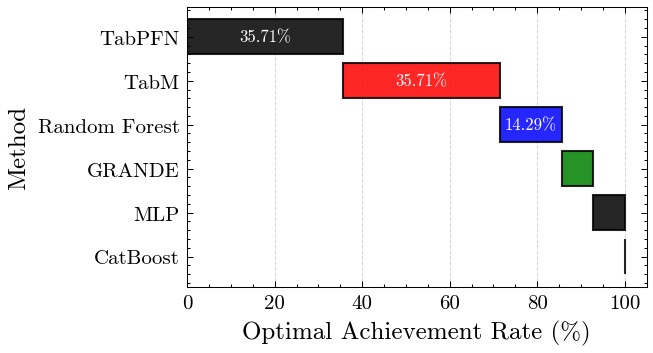


Summary for F1 (binary tasks, teacher models) (HPO: True):
Total datasets analyzed: 14

Model Contributions to Optimal Achievements:
 1. tabpfn_teacher_hpoTrue                  :  35.71% (Cumulative:  35.71%)
 2. tabm_teacher_hpoTrue                    :  35.71% (Cumulative:  71.43%)
 3. random_forest_teacher_hpoTrue           :  14.29% (Cumulative:  85.71%)
 4. grande_teacher_hpoTrue                  :   7.14% (Cumulative:  92.86%)
 5. mlp_teacher_hpoTrue                     :   7.14% (Cumulative: 100.00%)
 6. catboost_teacher_hpoTrue                :   0.00% (Cumulative: 100.00%)


In [11]:
# Example 1: Cumulative F1 score for binary classification (both teacher and student models)
plot_cumulative_optimal_achievements(metric='f1', task_filter='binary', model_filter='teacher', save_path='visual_outputs', hpo_filter=True)

# Scatter Plot Teacher vs Student

In [12]:
import matplotlib.pyplot as plt
import scienceplots
import numpy as np
from scipy import stats

def create_teacher_student_scatter(metric='f1', task_filter=None, figsize=(3.5, 3.5), save_path=None, hpo_filter=None, student_task_filter=None):
    """
    Create scatter plot comparing teacher vs student performance.
    
    Parameters:
    -----------
    metric : str
        The metric to evaluate (e.g., 'f1', 'acc', 'roc', 'mae', 'mse', 'rmse', 'r2')
    task_filter : str or None
        Filter by task type ('binary', 'regression', or None for all)
    figsize : tuple
        Figure size (width, height)
    save_path : str or None
        Path to save the plot (if None, just display)
    hpo_filter : bool or None
        Filter by use_hpo flag (True for HPO used, False for no HPO, None for all)
    student_task_filter : str or None
        Filter student models by their task type ('binary', 'regression', or None for all)
    """
    all_results = load_all_results()
    dataset_info = get_dataset_info()
    
    # Collect teacher-student pairs
    scatter_data = []
    teacher_names = set()  # To collect unique teacher names for title
    
    for dataset_id, models in all_results.items():
        if dataset_id not in dataset_info:
            continue
            
        # Filter by task type if specified
        if task_filter and dataset_info[dataset_id]['task_type'] != task_filter:
            continue
        
        # Find teacher and student models for each base model type
        teachers = {}
        students = {} # This will now be {teacher_name: {student_name: performance_data}}
        
        for model_name, result in models.items():
            mean_key = f"mean_{metric}"
            if mean_key not in result:
                continue
            
            # Apply HPO filter if specified
            if hpo_filter is not None:
                use_hpo = result.get('use_hpo', False)
                if hpo_filter != use_hpo:
                    continue
                
            if '_teacher_hpo' in model_name:
                base_model = model_name.split('_teacher_hpo')[0]
                teachers[base_model] = result[mean_key]
            elif '_student_hpo' in model_name:
                # Updated to handle new format: "student(teacher)_student_hpoTrue/False_task_type"
                main_part = model_name.split('_student_hpo')[0]
                if '(' in main_part and ')' in main_part:
                    teacher_part = main_part.split('(')[1].split(')')[0]
                    student_part = main_part.split('(')[0]
                    
                    # Apply student task filter if specified
                    if student_task_filter is not None:
                        # Check if the model name ends with the specified student task type
                        if not model_name.endswith(f'_{student_task_filter}'):
                            continue
                    
                    # Add teacher name to set for title
                    teacher_names.add(teacher_part)
                    
                    # Initialize inner dictionary if teacher is seen for the first time
                    if teacher_part not in students:
                        students[teacher_part] = {}
                    
                    # Store student data using student model as key
                    students[teacher_part][student_part] = {
                        'performance': result[mean_key],
                        'dataset_id': dataset_id,
                        'dataset_name': dataset_info[dataset_id]['name']
                    }
        
        # Match teacher-student pairs
        for teacher_model, teacher_perf in teachers.items():
            if teacher_model in students:
                # Iterate through all students distilled from this teacher
                for student_model, student_info in students[teacher_model].items():
                    scatter_data.append({
                        'teacher_performance': teacher_perf,
                        'student_performance': student_info['performance'],
                        'teacher_model': teacher_model,
                        'student_model': student_model,
                        'dataset_id': student_info['dataset_id'],
                        'dataset_name': student_info['dataset_name']
                    })
    
    if not scatter_data:
        print(f"No teacher-student pairs found for metric '{metric}' with task filter '{task_filter}', HPO filter '{hpo_filter}', and student task filter '{student_task_filter}'")
        return
    
    # Create title with prettified teacher names
    if teacher_names:
        prettified_teachers = [prettify(name) for name in sorted(teacher_names)]
        teacher_title = " & ".join(prettified_teachers) if len(prettified_teachers) > 1 else prettified_teachers[0]
        plot_title = f'{teacher_title} vs Student Performance'
    else:
        plot_title = 'Teacher vs Student Performance'
    
    # Convert to arrays for plotting
    teacher_perfs = np.array([d['teacher_performance'] for d in scatter_data])
    student_perfs = np.array([d['student_performance'] for d in scatter_data])
    
    # Calculate statistics
    correlation, p_value = stats.pearsonr(teacher_perfs, student_perfs)
    
    # Count points above/below diagonal
    above_diagonal = np.sum(student_perfs > teacher_perfs)
    below_diagonal = np.sum(student_perfs < teacher_perfs)
    on_diagonal = np.sum(student_perfs == teacher_perfs)
    
    # Check if logarithmic scale is needed
    use_log_scale = metric.lower() in ['mae', 'mse', 'rmse']
    
    # Create plot with SciencePlots
    with plt.style.context(['science', 'ieee', 'no-latex']):
        plt.rcParams.update({'figure.dpi': 150})
        
        fig, ax = plt.subplots(figsize=figsize)
        
        # Define extended color palette (same as standalone vs student)
        extended_colors = [
            '#000000', '#FF0000', '#008000', '#0000FF', "#fbff00", '#8c564b',
            '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78',
            '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d3', '#c7c7c7',
            '#dbdb8d', '#9edae5', '#ad494a', '#8c6d31', '#bd9e39', '#d6616b',
            '#7b4173', '#a55194', '#ce6dbd', '#de9ed6'
        ]
        
        # Group by teacher-student model pairs for coloring
        model_pairs = {}
        for d in scatter_data:
            pair_key = f"{prettify(d['student_model'])}"
            if pair_key not in model_pairs:
                model_pairs[pair_key] = []
            model_pairs[pair_key].append(d)
        
        # Plot each model pair with different colors
        for i, (pair_name, data_points) in enumerate(model_pairs.items()):
            teacher_vals = [d['teacher_performance'] for d in data_points]
            student_vals = [d['student_performance'] for d in data_points]
            
            ax.scatter(teacher_vals, student_vals, 
                      color=extended_colors[i % len(extended_colors)],
                      alpha=0.7, s=50, label=pair_name, edgecolors='black', linewidth=0.5)
        
        # Add diagonal line (perfect correspondence)
        min_val = min(min(teacher_perfs), min(student_perfs))
        max_val = max(max(teacher_perfs), max(student_perfs))
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, linewidth=1, label='Perfect Match')
        
        # Apply logarithmic scale if needed
        if use_log_scale:
            ax.set_xscale('log')
            ax.set_yscale('log')
        
        # Fit and plot regression line
        slope, intercept, r_value, p_val, std_err = stats.linregress(teacher_perfs, student_perfs)
        line_x = np.array([min_val, max_val])
        line_y = slope * line_x + intercept
        # ax.plot(line_x, line_y, 'r-', alpha=0.8, linewidth=1.5, label=f'Regression (r={r_value:.3f})')
        
        # Styling (same as standalone vs student)
        ax.set_xlabel(f'Teacher {metric.upper()}', fontsize=14)
        ax.set_ylabel(f'Student {metric.upper()}', fontsize=14)
        ax.set_title(plot_title, fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        # Add grid
        ax.grid(True, alpha=0.3)
        ax.set_axisbelow(True)
        
        # Add legend in top left
        ax.legend(loc='upper left')
        
        # Make axes equal if it makes sense for the metric (but not for log scale)
        if not metric.lower() in ['mae', 'mse', 'rmse', 'inference_time']:
            ax.set_aspect('equal', adjustable='box')
        
        plt.tight_layout()
        
        if save_path:
            hpo_suffix = f"_hpo{hpo_filter}" if hpo_filter is not None else ""
            student_task_suffix = f"_student_{student_task_filter}" if student_task_filter is not None else ""
            save_file = os.path.join(save_path, f'teacher_student_scatter_{metric}_{task_filter or "all"}{hpo_suffix}{student_task_suffix}.pdf')
            os.makedirs(os.path.dirname(save_file), exist_ok=True)
            fig.savefig(save_file, dpi=300, bbox_inches='tight')
            print(f'Plot saved to: {save_file}')
        
        plt.show()
    
    # Print summary statistics
    print(f"\nTeacher vs Student Performance Analysis ({metric.upper()})")
    if task_filter:
        print(f"Task Filter: {task_filter}")
    if hpo_filter is not None:
        print(f"HPO Filter: {'With HPO' if hpo_filter else 'Without HPO'}")
    if student_task_filter:
        print(f"Student Task Filter: {student_task_filter}")
    print("="*60)
    print(f"Total teacher-student pairs: {len(scatter_data)}")
    print(f"Correlation coefficient: {correlation:.4f} (p-value: {p_value:.4f})")
    print(f"Student outperforms teacher: {above_diagonal} ({above_diagonal/len(scatter_data)*100:.1f}%)")
    print(f"Teacher outperforms student: {below_diagonal} ({below_diagonal/len(scatter_data)*100:.1f}%)")
    print(f"Equal performance: {on_diagonal} ({on_diagonal/len(scatter_data)*100:.1f}%)")
    
    # Performance differences
    perf_diff = student_perfs - teacher_perfs
    print(f"Mean performance difference (student - teacher): {np.mean(perf_diff):.4f}")
    print(f"Std performance difference: {np.std(perf_diff):.4f}")
    
    # Model pair breakdown
    print(f"\nBreakdown by model pairs:")
    for pair_name, data_points in model_pairs.items():
        teacher_vals = np.array([d['teacher_performance'] for d in data_points])
        student_vals = np.array([d['student_performance'] for d in data_points])
        diff_vals = student_vals - teacher_vals
        wins = np.sum(student_vals > teacher_vals)
        
        print(f"{pair_name}: {len(data_points)} datasets, "
              f"student wins: {wins}/{len(data_points)} ({wins/len(data_points)*100:.1f}%), "
              f"mean diff: {np.mean(diff_vals):.4f}")
    
    return scatter_data

Plot saved to: visual_outputs/teacher_student_scatter_acc_binary_hpoTrue_student_regression.pdf


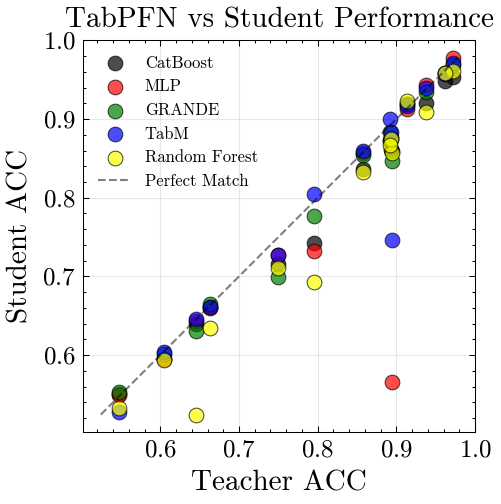


Teacher vs Student Performance Analysis (ACC)
Task Filter: binary
HPO Filter: With HPO
Student Task Filter: regression
Total teacher-student pairs: 70
Correlation coefficient: 0.9457 (p-value: 0.0000)
Student outperforms teacher: 16 (22.9%)
Teacher outperforms student: 54 (77.1%)
Equal performance: 0 (0.0%)
Mean performance difference (student - teacher): -0.0216
Std performance difference: 0.0463

Breakdown by model pairs:
CatBoost: 14 datasets, student wins: 2/14 (14.3%), mean diff: -0.0181
MLP: 14 datasets, student wins: 3/14 (21.4%), mean diff: -0.0327
GRANDE: 14 datasets, student wins: 3/14 (21.4%), mean diff: -0.0115
TabM: 14 datasets, student wins: 7/14 (50.0%), mean diff: -0.0133
Random Forest: 14 datasets, student wins: 1/14 (7.1%), mean diff: -0.0326


[{'teacher_performance': 0.9137141002812126,
  'student_performance': 0.9192590210292695,
  'teacher_model': 'tabpfn',
  'student_model': 'catboost',
  'dataset_id': '40705',
  'dataset_name': 'tokyo1'},
 {'teacher_performance': 0.9137141002812126,
  'student_performance': 0.9122307929830138,
  'teacher_model': 'tabpfn',
  'student_model': 'mlp',
  'dataset_id': '40705',
  'dataset_name': 'tokyo1'},
 {'teacher_performance': 0.9137141002812126,
  'student_performance': 0.9193137568988968,
  'teacher_model': 'tabpfn',
  'student_model': 'grande',
  'dataset_id': '40705',
  'dataset_name': 'tokyo1'},
 {'teacher_performance': 0.9137141002812126,
  'student_performance': 0.9164292461069403,
  'teacher_model': 'tabpfn',
  'student_model': 'tabm',
  'dataset_id': '40705',
  'dataset_name': 'tokyo1'},
 {'teacher_performance': 0.9137141002812126,
  'student_performance': 0.9229118952832944,
  'teacher_model': 'tabpfn',
  'student_model': 'random_forest',
  'dataset_id': '40705',
  'dataset_name

In [13]:
create_teacher_student_scatter(metric='acc', task_filter='binary', student_task_filter="regression", save_path='visual_outputs', hpo_filter=True)

In [14]:
def create_standalone_vs_student_scatter(metric='f1', task_filter=None, figsize=(3.5, 3.5), save_path=None, hpo_filter=None, student_task_filter=None):
    """
    Create scatter plot comparing standalone model vs. student model of the same architecture.
    E.g., compares GRANDE_teacher vs. GRANDE(TabPFN)_student.
    
    Parameters:
    -----------
    metric : str
        The metric to evaluate.
    task_filter : str or None
        Filter by task type ('binary', 'regression', or None for all).
    figsize : tuple
        Figure size (width, height).
    save_path : str or None
        Path to save the plot.
    hpo_filter : bool or None
        Filter by use_hpo flag (True for HPO used, False for no HPO, None for all)
    student_task_filter : str or None
        Filter student models by their task type ('binary', 'regression', or None for all)
    """
    all_results = load_all_results()
    dataset_info = get_dataset_info()
    
    scatter_data = []
    
    for dataset_id, models in all_results.items():
        if dataset_id not in dataset_info:
            continue
            
        if task_filter and dataset_info[dataset_id]['task_type'] != task_filter:
            continue
        
        # Store standalone models and student models for this dataset
        standalone_models = {}  # e.g., {'grande': 0.85, 'catboost': 0.9}
        student_models = []     # e.g., [{'student_base': 'grande', 'teacher_base': 'tabpfn', 'perf': 0.88}]

        for model_name, result in models.items():
            mean_key = f"mean_{metric}"
            if mean_key not in result:
                continue
            
            # Apply HPO filter if specified
            if hpo_filter is not None:
                use_hpo = result.get('use_hpo', False)
                if hpo_filter != use_hpo:
                    continue

            if '_teacher_hpo' in model_name:
                # Extract base model name from "base_teacher_hpoTrue/False"
                base_model = model_name.split('_teacher_hpo')[0]
                standalone_models[base_model] = result[mean_key]
            elif '_student_hpo' in model_name:
                # Updated to handle new format: "student(teacher)_student_hpoTrue/False_task_type"
                main_part = model_name.split('_student_hpo')[0]
                if '(' in main_part and ')' in main_part:
                    teacher_part = main_part.split('(')[1].split(')')[0]
                    student_part = main_part.split('(')[0]
                    
                    # Apply student task filter if specified
                    if student_task_filter is not None:
                        # Check if the model name ends with the specified student task type
                        if not model_name.endswith(f'_{student_task_filter}'):
                            continue
                    
                    student_models.append({
                        'student_base': student_part,
                        'teacher_base': teacher_part,
                        'performance': result[mean_key]
                    })

        # Match standalone models with student models of the same base architecture
        for student in student_models:
            student_base = student['student_base']
            if student_base in standalone_models:
                standalone_perf = standalone_models[student_base]
                student_perf = student['performance']
                
                scatter_data.append({
                    'standalone_performance': standalone_perf,
                    'student_performance': student_perf,
                    'model_base': student_base,
                    'distillation_teacher': student['teacher_base'],
                    'dataset_name': dataset_info[dataset_id]['name']
                })

    if not scatter_data:
        print(f"No standalone-vs-student pairs found for metric '{metric}' with task filter '{task_filter}', HPO filter '{hpo_filter}', and student task filter '{student_task_filter}'")
        return

    # Convert to arrays for plotting
    standalone_perfs = np.array([d['standalone_performance'] for d in scatter_data])
    student_perfs = np.array([d['student_performance'] for d in scatter_data])

    # Check if logarithmic scale is needed
    use_log_scale = metric.lower() in ['mae', 'mse', 'rmse']

    # Create plot
    with plt.style.context(['science', 'ieee', 'no-latex']):
        plt.rcParams.update({'figure.dpi': 150})
        fig, ax = plt.subplots(figsize=figsize)
        
        # Define extended color palette
        extended_colors = [
            '#000000', '#FF0000', '#008000', '#0000FF', "#fbff00", '#8c564b',
            '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78',
            '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d3', '#c7c7c7',
            '#dbdb8d', '#9edae5', '#ad494a', '#8c6d31', '#bd9e39', '#d6616b',
            '#7b4173', '#a55194', '#ce6dbd', '#de9ed6'
        ]
        
        # Group by comparison pairs for coloring
        model_pairs = {}
        for d in scatter_data:
            pair_key = f"{prettify(d['model_base'])}"
            if pair_key not in model_pairs:
                model_pairs[pair_key] = []
            model_pairs[pair_key].append(d)
        
        for i, (pair_name, data_points) in enumerate(model_pairs.items()):
            standalone_vals = [d['standalone_performance'] for d in data_points]
            student_vals = [d['student_performance'] for d in data_points]
            ax.scatter(standalone_vals, student_vals, 
                       color=extended_colors[i % len(extended_colors)],
                       alpha=0.7, 
                       s=50, label=pair_name, edgecolors='black', linewidth=0.5)
        
        # Apply logarithmic scale if needed
        if use_log_scale:
            print("Using logarithmic scale for axes")
            ax.set_xscale('log')
            ax.set_yscale('log')
        
        # Add diagonal line
        min_val = min(min(standalone_perfs), min(student_perfs))
        max_val = max(max(standalone_perfs), max(student_perfs))
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, linewidth=1, label='No Change')
        
        # Styling
        ax.set_xlabel(f'Standalone Model {metric.upper()}', fontsize=14)
        ax.set_ylabel(f'Student Model {metric.upper()}', fontsize=14)
        ax.set_title(f'Standalone vs. Distilled Student', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left')
        
        # Make axes equal if it makes sense for the metric (but not for log scale)
        if not use_log_scale and not metric.lower() in ['inference_time']:
            ax.set_aspect('equal', adjustable='box')
        
        plt.tight_layout()
        
        if save_path:
            hpo_suffix = f"_hpo{hpo_filter}" if hpo_filter is not None else ""
            student_task_suffix = f"_student_{student_task_filter}" if student_task_filter is not None else ""
            save_file = os.path.join(save_path, f'standalone_vs_student_scatter_{metric}_{task_filter or "all"}{hpo_suffix}{student_task_suffix}.pdf')
            os.makedirs(os.path.dirname(save_file), exist_ok=True)
            fig.savefig(save_file, dpi=300, bbox_inches='tight')
            print(f'Plot saved to: {save_file}')
        
        plt.show()

    # Print summary
    hpo_label = f" (HPO: {hpo_filter})" if hpo_filter is not None else ""
    student_task_label = f" (Student Task: {student_task_filter})" if student_task_filter is not None else ""
    print(f"\nStandalone vs. Student Performance Analysis ({metric.upper()}){hpo_label}{student_task_label}")
    if task_filter:
        print(f"Task Filter: {task_filter}")
    above = np.sum(student_perfs > standalone_perfs)
    below = np.sum(student_perfs < standalone_perfs)
    print(f"Student outperforms standalone: {above} ({above/len(scatter_data)*100:.1f}%)")
    print(f"Standalone outperforms student: {below} ({below/len(scatter_data)*100:.1f}%)")
    
    return scatter_data

Plot saved to: visual_outputs/standalone_vs_student_scatter_acc_binary_hpoTrue_student_regression.pdf


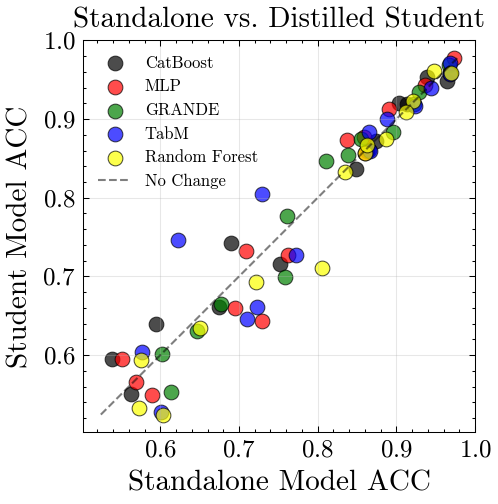


Standalone vs. Student Performance Analysis (ACC) (HPO: True) (Student Task: regression)
Task Filter: binary
Student outperforms standalone: 29 (41.4%)
Standalone outperforms student: 41 (58.6%)


[{'standalone_performance': 0.9134759595126752,
  'student_performance': 0.9192590210292695,
  'model_base': 'catboost',
  'distillation_teacher': 'tabpfn',
  'dataset_name': 'tokyo1'},
 {'standalone_performance': 0.8911486337142162,
  'student_performance': 0.9122307929830138,
  'model_base': 'mlp',
  'distillation_teacher': 'tabpfn',
  'dataset_name': 'tokyo1'},
 {'standalone_performance': 0.9218674103857423,
  'student_performance': 0.9193137568988968,
  'model_base': 'grande',
  'distillation_teacher': 'tabpfn',
  'dataset_name': 'tokyo1'},
 {'standalone_performance': 0.9231613607145134,
  'student_performance': 0.9164292461069403,
  'model_base': 'tabm',
  'distillation_teacher': 'tabpfn',
  'dataset_name': 'tokyo1'},
 {'standalone_performance': 0.9211024741242217,
  'student_performance': 0.9229118952832944,
  'model_base': 'random_forest',
  'distillation_teacher': 'tabpfn',
  'dataset_name': 'tokyo1'},
 {'standalone_performance': 0.6744782290515112,
  'student_performance': 0.6

In [15]:
create_standalone_vs_student_scatter(metric='acc', 
                                     task_filter='binary',
                                     student_task_filter='regression', 
                                     save_path='visual_outputs',
                                     hpo_filter=True
                                     )

# Relative Performance Improvement Plot

In [16]:
def calculate_relative_improvements(metrics=['f1', 'acc', 'roc'], task_filter=None, hpo_filter=None, teacher_better_only=False, comparison_metric='f1', student_task_filter=None):
    """
    Calculate relative improvements of student models compared to standalone models.
    
    Parameters:
    -----------
    teacher_better_only : bool
        If True, only include cases where TabPFN (teacher) originally outperformed the standalone model
    student_task_filter : str or None
        Filter student models by their task type ('binary', 'regression', or None for all)
    """
    all_results = load_all_results()
    dataset_info = get_dataset_info()
    
    improvements = {}
    
    for dataset_id, models in all_results.items():
        if dataset_id not in dataset_info:
            continue
            
        if task_filter and dataset_info[dataset_id]['task_type'] != task_filter:
            continue
        
        # Collect standalone models (teachers), students, and TabPFN teachers
        standalone_models = []  # e.g., GRANDE standalone
        student_models = []     # e.g., GRANDE(TabPFN) student
        tabpfn_teachers = []    # TabPFN teacher models

        for model_name, result in models.items():
            # Apply HPO filter if specified
            if hpo_filter is not None:
                use_hpo = result.get('use_hpo', False)
                if hpo_filter != use_hpo:
                    continue
            
            if '_teacher_hpo' in model_name:
                base_model = model_name.split('_teacher_hpo')[0]
                teacher_metrics = {}
                
                for metric in metrics:
                    mean_key = f"mean_{metric}"
                    if mean_key in result:
                        teacher_metrics[metric] = result[mean_key]
                
                if teacher_metrics:
                    model_entry = {
                        'base': base_model,
                        'hpo': use_hpo,
                        'metrics': teacher_metrics
                    }
                    
                    if base_model == 'tabpfn':
                        tabpfn_teachers.append(model_entry)
                    else:
                        standalone_models.append(model_entry)
                        
            elif '_student_hpo' in model_name:
                # Updated to handle new format: "student(teacher)_student_hpoTrue/False_task_type"
                main_part = model_name.split('_student_hpo')[0]
                if '(' in main_part and ')' in main_part:
                    teacher_part = main_part.split('(')[1].split(')')[0]
                    student_part = main_part.split('(')[0]
                    
                    # Apply student task filter if specified
                    if student_task_filter is not None:
                        # Check if the model name ends with the specified student task type
                        if not model_name.endswith(f'_{student_task_filter}'):
                            continue
                    
                    student_metrics = {}
                    for metric in metrics:
                        mean_key = f"mean_{metric}"
                        if mean_key in result:
                            student_metrics[metric] = result[mean_key]
                    
                    if student_metrics:
                        use_hpo = result.get('use_hpo', False)  # Get HPO status for student
                        student_models.append({
                            'student_base': student_part,
                            'teacher_base': teacher_part,
                            'hpo': use_hpo,
                            'metrics': student_metrics
                        })

        # Match students with their corresponding standalone models and check TabPFN condition
        for student in student_models:
            # Find matching standalone model
            matching_standalone = None
            for standalone in standalone_models:
                if (standalone['base'] == student['student_base'] and 
                    standalone['hpo'] == student['hpo']):
                    matching_standalone = standalone
                    break
            
            if matching_standalone:
                # If teacher_better_only is True, check if TabPFN outperformed standalone
                # Check if TabPFN outperformed standalone using the specified comparison metric
                if teacher_better_only:
                    # Find matching TabPFN teacher
                    matching_tabpfn = None
                    for tabpfn in tabpfn_teachers:
                        if tabpfn['hpo'] == student['hpo']:
                            matching_tabpfn = tabpfn
                            break
                    
                    if not matching_tabpfn:
                        continue  # Skip if no TabPFN teacher found
                    
                    # Check if TabPFN outperformed standalone for the comparison metric
                    if (comparison_metric in matching_tabpfn['metrics'] and 
                        comparison_metric in matching_standalone['metrics']):
                        tabpfn_perf = matching_tabpfn['metrics'][comparison_metric]
                        standalone_perf = matching_standalone['metrics'][comparison_metric]
                        
                        # For metrics where lower is better, TabPFN should have lower value
                        # For metrics where higher is better, TabPFN should have higher value
                        if comparison_metric.lower() in ['mae', 'mse', 'rmse']:
                            if tabpfn_perf >= standalone_perf:  # TabPFN didn't outperform (higher is worse)
                                continue  # Skip this case
                        else:
                            if tabpfn_perf <= standalone_perf:  # TabPFN didn't outperform (lower is worse)
                                continue  # Skip this case
                    else:
                        continue  # Skip if comparison metric not available
                
                # Calculate relative improvements
                method_key = prettify(student['student_base'])
                
                if method_key not in improvements:
                    improvements[method_key] = {metric: [] for metric in metrics}
                
                for metric in metrics:
                    if (metric in student['metrics'] and 
                        metric in matching_standalone['metrics'] and
                        matching_standalone['metrics'][metric] > 0):
                        
                        standalone_perf = matching_standalone['metrics'][metric]
                        student_perf = student['metrics'][metric]
                        
                        # In calculate_relative_improvements function, around line where relative_improvement is calculated:
                        relative_improvement = ((student_perf - standalone_perf) / standalone_perf) * 100

                        # Add this check for metrics where lower is better:
                        if metric.lower() in ['mae', 'mse', 'rmse']:
                            relative_improvement = -relative_improvement  # Flip sign so negative error reduction becomes positive improvement

                        improvements[method_key][metric].append(relative_improvement)

    return improvements

def plot_relative_improvements(metrics=['f1', 'acc', 'roc'], task_filter=None, hpo_filter=None,
                              teacher_better_only=False, figsize=(8, 5), save_path=None, student_task_filter=None):
    """
    Create boxplot showing relative improvements of student methods vs standalone methods.
    
    Parameters:
    -----------
    metrics : list
        List of metrics to evaluate (default: ['f1', 'acc', 'roc'])
    task_filter : str or None
        Filter by task type ('binary', 'regression', or None for all)
    hpo_filter : bool or None
        Filter by use_hpo flag (True for HPO used, False for no HPO, None for all)
    teacher_better_only : bool
        If True, only include cases where teacher originally outperformed standalone
    figsize : tuple
        Figure size (width, height)
    save_path : str or None
        Path to save the plot
    student_task_filter : str or None
        Filter student models by their task type ('binary', 'regression', or None for all)
    """
    if task_filter == "binary":
        comparison_metric = 'f1'
    else:
        comparison_metric = 'mae'
        
    improvements = calculate_relative_improvements(metrics, task_filter, hpo_filter, teacher_better_only, comparison_metric, student_task_filter)
    
    if not improvements:
        print(f"No data found for relative improvement analysis")
        return
    
    # Filter out methods that don't have data for any metric
    filtered_improvements = {}
    for method, metric_data in improvements.items():
        if any(len(values) > 0 for values in metric_data.values()):
            filtered_improvements[method] = metric_data
    
    if not filtered_improvements:
        print("No methods with sufficient data for plotting")
        return
    
    # Prepare data for plotting - REPLACE THIS SECTION
    # Define custom order for methods
    method_order = ['Random Forest', 'CatBoost', 'GRANDE', 'MLP', 'TabM']

    # Sort methods according to custom order, with any remaining methods at the end
    methods = []
    for preferred_method in method_order:
        if preferred_method in filtered_improvements:
            methods.append(preferred_method)

    # Add any methods not in the preferred order
    for method in sorted(filtered_improvements.keys()):
        if method not in methods:
            methods.append(method)

    n_methods = len(methods)
    n_metrics = len(metrics)
    
    # Create plot with SciencePlots
    with plt.style.context(['science', 'ieee', 'no-latex']):
        plt.rcParams.update({'figure.dpi': 150})
        
        fig, ax = plt.subplots(
            figsize=figsize
            )
        
        # Colors for different metrics
        # colors = ['#FF0000', '#0000FF', '#008000', "#fbff00"]
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

        metric_colors = {metric: colors[i % len(colors)] for i, metric in enumerate(metrics)}
        
        # Tighter spacing - reduce box width and spacing
        box_width = 0.2  # Reduced from 0.25
        spacing = 0.02   # Reduced from 0.1
        
        # Plot boxplots for each method and metric
        all_positions = []
        all_data = []
        all_labels = []
        all_colors = []
        
        for i, method in enumerate(methods):
            method_data = filtered_improvements[method]
            
            for j, metric in enumerate(metrics):
                if len(method_data[metric]) > 0:  # Only plot if we have data
                    # Calculate position for this box with tighter spacing between methods
                    base_pos = i * 0.8 + 1  # Reduced from i + 1 to i * 0.8 + 1
                    offset = (j - (n_metrics - 1) / 2) * (box_width + spacing)
                    position = base_pos + offset
                    
                    all_positions.append([position])
                    all_data.append(method_data[metric])
                    all_labels.append(f"{metric.upper()}")
                    all_colors.append(metric_colors[metric])
        
        # Create boxplots
        if all_data:
            bp = ax.boxplot(all_data, positions=[pos[0] for pos in all_positions], 
                           widths=box_width, 
                           patch_artist=True,
                           boxprops=dict(linewidth=1),
                           medianprops=dict(linewidth=1.5, color='black'),
                           whiskerprops=dict(linewidth=1),
                           capprops=dict(linewidth=1),
                           flierprops=dict(marker='o', markerfacecolor='grey', markersize=6, 
                                 alpha=0.3, markeredgecolor='black', markeredgewidth=0.5)
                           )
            
            # Color the boxes
            for patch, color in zip(bp['boxes'], all_colors):
                patch.set_facecolor(color)
                # patch.set_alpha(0.7)
        
        # Add horizontal line at y=0 (no improvement)
        ax.axhline(y=0, color='grey', linestyle='--', alpha=0.7, linewidth=1, 
                  label='No Improvement')
        
        # Styling
        ax.set_xlabel('Method', fontsize=14)
        ax.set_ylabel('Relative Improvement (%)', fontsize=14)
        # Update the title to reflect the filter
        title = 'Relative Improvement Student vs Standalone'        
        ax.set_title(title, fontsize=14)
        
        # Set x-axis with adjusted positions
        x_positions = [i * 0.8 + 1 for i in range(n_methods)]
        ax.set_xticks(x_positions)
        ax.set_xticklabels(methods, rotation=45, ha='right')
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        # Adjust x-axis limits to fit tighter spacing
        ax.set_xlim(0.5, max(x_positions) + 0.5)
        all_values = []
        for method_data in filtered_improvements.values():
            for metric_values in method_data.values():
                all_values.extend(metric_values)
        
        if task_filter == "binary":
            # Set y-axis limits for binary tasks
            if student_task_filter == "regression":
                if not hpo_filter:
                    ax.set_ylim(-10, 20)
                else:
                    if teacher_better_only:
                        ax.set_ylim(-10, 25)
                    else:
                        ax.set_ylim(-15, 15)
            else:
                if not hpo_filter:
                    ax.set_ylim(-5, 5)
                else:
                    ax.set_ylim(-5, 5)
        elif task_filter == "regression":
            # Set y-axis limits for regression tasks
            ax.set_ylim(-60, 50)

        
        # Add grid
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_axisbelow(True)
        
        # Create custom legend
        legend_elements = []
        for metric in metrics:
            legend_elements.append(plt.Rectangle((0,0),1,1, 
                                               facecolor=metric_colors[metric], 
                                            #    alpha=0.7, 
                                               label=metric.upper()))
        legend_elements.append(plt.Line2D([0], [0], color='grey', linestyle='--', 
                                        alpha=0.7, label='No Improvement'))
        
        ax.legend(handles=legend_elements, loc='upper right')
        
        plt.tight_layout()
        
        if save_path:
            hpo_suffix = f"_hpo{hpo_filter}" if hpo_filter is not None else ""
            student_task_suffix = f"_student_{student_task_filter}" if student_task_filter is not None else ""
            teacher_better_only_suffix = "_teacher_better_only" if teacher_better_only else ""
            save_file = os.path.join(save_path, f'relative_improvements_{task_filter or "all"}{hpo_suffix}{teacher_better_only_suffix}{student_task_suffix}.pdf')
            os.makedirs(os.path.dirname(save_file), exist_ok=True)
            fig.savefig(save_file, dpi=300, bbox_inches='tight')
            print(f'Plot saved to: {save_file}')
        
        plt.show()
    
    # Print summary statistics
    # Update summary print
    filter_desc = " (Teacher Initially Better)" if teacher_better_only else ""
    student_task_desc = f" (Student Task: {student_task_filter})" if student_task_filter else ""
    print(f"\nRelative Improvement Summary ({task_filter if task_filter else 'all'} tasks){filter_desc}{student_task_desc}")
    
    if hpo_filter is not None:
        print(f"HPO Filter: {'With HPO' if hpo_filter else 'Without HPO'}")
    print("="*80)
    
    for method in methods:
        print(f"\n{method}:")
        method_data = filtered_improvements[method]
        
        for metric in metrics:
            values = method_data[metric]
            if len(values) > 0:
                mean_imp = np.mean(values)
                median_imp = np.median(values)
                positive_count = sum(1 for v in values if v > 0)
                total_count = len(values)
                
                print(f"  {metric.upper()}: Mean={mean_imp:+6.2f}%, Median={median_imp:+6.2f}%, "
                      f"Positive={positive_count}/{total_count} ({positive_count/total_count*100:.1f}%)")
            else:
                print(f"  {metric.upper()}: No data available")
    
    return filtered_improvements

Plot saved to: visual_outputs/relative_improvements_binary_hpoTrue_teacher_better_only_student_regression.pdf


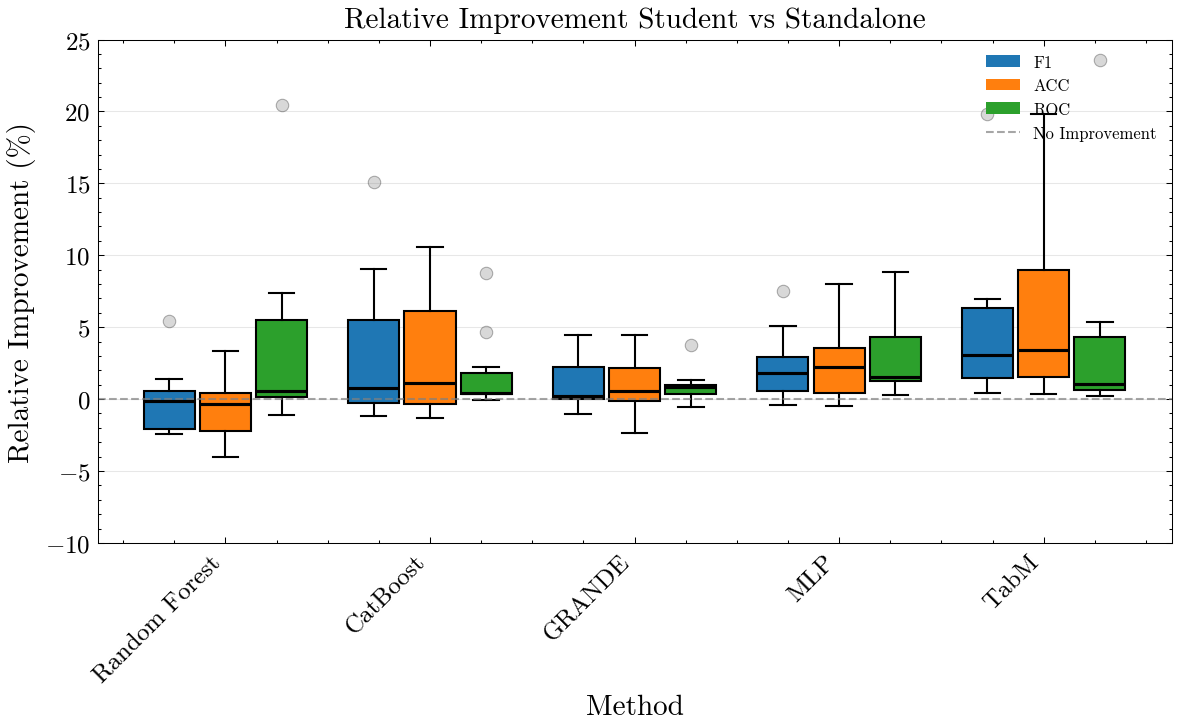


Relative Improvement Summary (binary tasks) (Teacher Initially Better) (Student Task: regression)
HPO Filter: With HPO

Random Forest:
  F1: Mean= -1.35%, Median= -0.12%, Positive=5/10 (50.0%)
  ACC: Mean= -1.67%, Median= -0.36%, Positive=3/10 (30.0%)
  ROC: Mean= +3.54%, Median= +0.56%, Positive=8/10 (80.0%)

CatBoost:
  F1: Mean= +3.20%, Median= +0.75%, Positive=7/10 (70.0%)
  ACC: Mean= +2.75%, Median= +1.14%, Positive=6/10 (60.0%)
  ROC: Mean= +1.80%, Median= +0.42%, Positive=9/10 (90.0%)

GRANDE:
  F1: Mean= +1.20%, Median= +0.22%, Positive=7/9 (77.8%)
  ACC: Mean= +0.87%, Median= +0.58%, Positive=6/9 (66.7%)
  ROC: Mean= +0.86%, Median= +0.84%, Positive=7/9 (77.8%)

MLP:
  F1: Mean= +2.38%, Median= +1.84%, Positive=7/8 (87.5%)
  ACC: Mean= +2.48%, Median= +2.23%, Positive=6/8 (75.0%)
  ROC: Mean= +3.20%, Median= +1.51%, Positive=8/8 (100.0%)

TabM:
  F1: Mean= +5.77%, Median= +3.03%, Positive=6/6 (100.0%)
  ACC: Mean= +6.46%, Median= +3.41%, Positive=6/6 (100.0%)
  ROC: Mean= +5

In [17]:
# Create the boxplot showing relative improvements for F1, accuracy, and ROC with HPO filter
a = plot_relative_improvements(
    metrics=['f1', 'acc', 'roc'], 
    task_filter='binary',
    student_task_filter='regression',  # Filter student models by binary task
    hpo_filter=True,  # Filter for experiments without HPO
    save_path='visual_outputs',
    teacher_better_only=True,  # Only include cases where teacher originally outperformed student
)

Plot saved to: visual_outputs/relative_improvements_regression_hpoFalse_student_regression.pdf


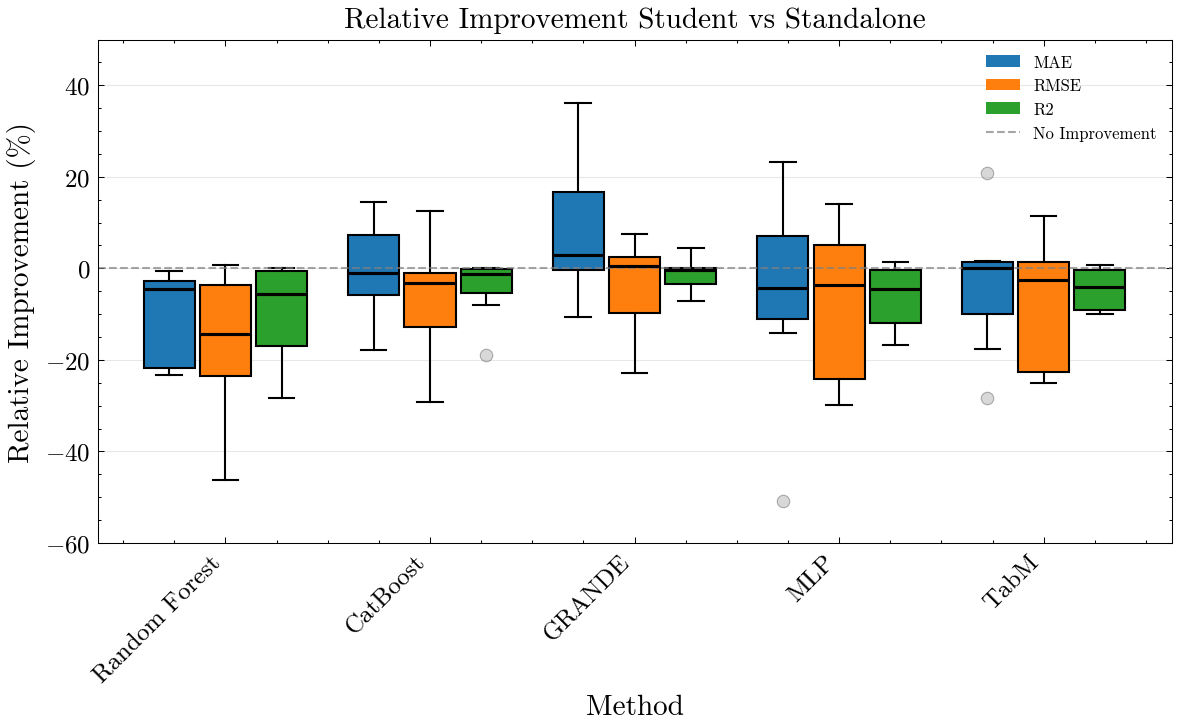


Relative Improvement Summary (regression tasks) (Student Task: regression)
HPO Filter: Without HPO

Random Forest:
  MAE: Mean=-73.66%, Median= -4.61%, Positive=0/7 (0.0%)
  RMSE: Mean=-16.35%, Median=-14.35%, Positive=1/7 (14.3%)
  R2: Mean= -9.88%, Median= -5.69%, Positive=0/7 (0.0%)

CatBoost:
  MAE: Mean= +7.03%, Median= -1.01%, Positive=3/7 (42.9%)
  RMSE: Mean= -6.77%, Median= -3.18%, Positive=1/7 (14.3%)
  R2: Mean= +8.40%, Median= -1.14%, Positive=1/7 (14.3%)

GRANDE:
  MAE: Mean= +8.69%, Median= +2.91%, Positive=5/7 (71.4%)
  RMSE: Mean= -4.14%, Median= +0.60%, Positive=4/7 (57.1%)
  R2: Mean= -1.28%, Median= -0.40%, Positive=2/6 (33.3%)

MLP:
  MAE: Mean= -5.69%, Median= -4.24%, Positive=3/7 (42.9%)
  RMSE: Mean=-16.11%, Median= -3.75%, Positive=3/7 (42.9%)
  R2: Mean= -6.27%, Median= -4.49%, Positive=1/6 (16.7%)

TabM:
  MAE: Mean= -3.49%, Median= +0.18%, Positive=4/7 (57.1%)
  RMSE: Mean=-26.61%, Median= -2.65%, Positive=2/7 (28.6%)
  R2: Mean= -4.52%, Median= -4.05%, Posi

In [18]:
# Create the boxplot showing relative improvements for F1, accuracy, and ROC with HPO filter
a = plot_relative_improvements(
    metrics=['mae', 'rmse', 'r2'], 
    task_filter='regression',
    student_task_filter='regression',  # Filter student models by regression task
    hpo_filter=False,  # Filter for experiments without HPO
    save_path='visual_outputs',
    teacher_better_only=False,  # Only include cases where teacher originally outperformed student
)

In [19]:
def create_improvement_summary_table(metrics=['f1', 'acc', 'roc'], task_filter=None, hpo_filter=None, teacher_better_only=False, student_task_filter=None):
    """
    Create a summary table of relative improvements.
    
    Parameters:
    -----------
    metrics : list
        List of metrics to evaluate
    task_filter : str or None
        Filter by task type ('binary', 'regression', or None for all)
    hpo_filter : bool or None
        Filter by use_hpo flag (True for HPO used, False for no HPO, None for all)
    teacher_better_only : bool
        If True, only include cases where teacher originally outperformed standalone
    student_task_filter : str or None
        Filter student models by their task type ('binary', 'regression', or None for all)
    
    Returns:
    --------
    pd.DataFrame: Summary table with methods as rows and metrics as columns
    """
    if task_filter == "binary":
        comparison_metric = 'f1'
    else:
        comparison_metric = 'mae'

    improvements = calculate_relative_improvements(metrics, task_filter, hpo_filter, teacher_better_only, comparison_metric, student_task_filter)
    
    if not improvements:
        return pd.DataFrame()
    
    # Create summary data
    summary_data = []
    
    for method, metric_data in improvements.items():
        row = {'Method': method}
        
        for metric in metrics:
            values = metric_data[metric]
            if len(values) > 0:
                if task_filter == "binary":
                    mean_imp = np.mean(values)
                else:
                    mean_imp = np.mean(values) 
                positive_count = sum(1 for v in values if v > 0)
                total_count = len(values)
                
                row[f'{metric.upper()} Mean (%)'] = mean_imp
                row[f'{metric.upper()} Win Rate (%)'] = (positive_count / total_count) * 100
            else:
                row[f'{metric.upper()} Mean (%)'] = np.nan
                row[f'{metric.upper()} Win Rate (%)'] = np.nan
        
        summary_data.append(row)
    
    df = pd.DataFrame(summary_data)
    
    # Sort by average improvement across metrics
    mean_cols = [col for col in df.columns if 'Mean (%)' in col]
    if mean_cols:
        df['Overall Mean'] = df[mean_cols].mean(axis=1, skipna=True)
        df = df.sort_values('Overall Mean', ascending=False)
        df = df.drop('Overall Mean', axis=1)
    
    return df

def display_improvement_summary(metrics=['f1', 'acc', 'roc'], task_filter=None, hpo_filter=None, teacher_better_only=False, student_task_filter=None):
    """Display the improvement summary table with styling."""
    df = create_improvement_summary_table(metrics, task_filter, hpo_filter, teacher_better_only, student_task_filter)
    
    if df.empty:
        print("No improvement data available")
        return df
    
    filter_desc = " (TabPFN > Standalone)" if teacher_better_only else ""
    student_task_desc = f" (Student Task: {student_task_filter})" if student_task_filter else ""
    print(f"\nRelative Improvement Summary Table ({task_filter if task_filter else 'all'} tasks){filter_desc}{student_task_desc}")
    if hpo_filter is not None:
        print(f"HPO Filter: {'With HPO' if hpo_filter else 'Without HPO'}")
    print("="*80)
    
    styled_df = df.style.hide(axis="index").format({
        col: '{:+.2f}' if 'Mean (%)' in col else '{:.2f}' 
        for col in df.columns if col != 'Method'
    })
    
    display(styled_df)
    
    return df

In [20]:
# Display summary table with HPO filter
summary_df = display_improvement_summary(
    metrics=['f1', 'acc', 'roc'], 
    task_filter='binary',
    student_task_filter='regression',  # Filter student models by binary task
    hpo_filter=True,
    teacher_better_only=True  # Only include cases where teacher originally outperformed student
)

# Export summary to CSV with HPO filter indication
if not summary_df.empty:
    summary_df.to_csv(f'../results/relative_improvements_summary.csv', index=False)
    print("Summary table exported to CSV")


Relative Improvement Summary Table (binary tasks) (TabPFN > Standalone) (Student Task: regression)
HPO Filter: With HPO


Method,F1 Mean (%),F1 Win Rate (%),ACC Mean (%),ACC Win Rate (%),ROC Mean (%),ROC Win Rate (%)
TabM,+5.77,100.00,+6.46,100.00,+5.30,100.00
MLP,+2.38,87.50,+2.48,75.00,+3.20,100.00
CatBoost,+3.20,70.00,+2.75,60.00,+1.80,90.00
GRANDE,+1.20,77.78,+0.87,66.67,+0.86,77.78
Random Forest,-1.35,50.00,-1.67,30.00,+3.54,80.00


Summary table exported to CSV


In [21]:
# Display summary table with HPO filter
summary_df = display_improvement_summary(
    metrics=['mae', 'rmse', 'r2'], 
    task_filter='regression',
    hpo_filter=False,
    teacher_better_only=False  # Only include cases where teacher originally outperformed student
)

# Export summary to CSV with HPO filter indication
if not summary_df.empty:
    summary_df.to_csv(f'../results/relative_improvements_summary.csv', index=False)
    print("Summary table exported to CSV")


Relative Improvement Summary Table (regression tasks)
HPO Filter: Without HPO


Method,MAE Mean (%),MAE Win Rate (%),RMSE Mean (%),RMSE Win Rate (%),R2 Mean (%),R2 Win Rate (%)
CatBoost,+7.03,42.86,-6.77,14.29,+8.40,14.29
GRANDE,+8.69,71.43,-4.14,57.14,-1.28,33.33
MLP,-5.69,42.86,-16.11,42.86,-6.27,16.67
TabM,-3.49,57.14,-26.61,28.57,-4.52,16.67
Random Forest,-73.66,0.00,-16.35,14.29,-9.88,0.00


Summary table exported to CSV


# Probailtiy Binning

## Teacher

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import json
import scienceplots

def plot_probability_bins_all_folds(dataset_id, model_name, bins=10, figsize=(6, 4), save_path=None, prediction_type='both', hpo_type='default'):
    """
    Plot probability distribution in bins aggregating across all outer test folds.
    
    Parameters:
    -----------
    dataset_id : str
        The dataset ID (e.g., '1485')
    model_name : str  
        The model name (e.g., 'mlp', 'tabpfn', etc.)
    bins : int or array-like
        Number of bins or bin edges
    figsize : tuple
        Figure size (width, height)
    save_path : str or None
        Path to save the plot
    prediction_type : str
        'train', 'test', or 'both' - which predictions to plot
    hpo_type : str
        'default' or 'hpo' - whether to use HPO results or default results
    """
    
    # Choose the correct path based on hpo_type
    if hpo_type == 'hpo':
        fold_file = f"../data/fold_indices/hpo/teacher/{dataset_id}_{model_name}.json"
        title_suffix = "(HPO)"
    else:
        fold_file = f"../data/fold_indices/default/teacher/{dataset_id}_{model_name}.json"
        title_suffix = ""
    
    try:
        with open(fold_file, 'r') as f:
            fold_data = json.load(f)
    except FileNotFoundError:
        print(f"File not found: {fold_file}")
        return
    
    # Aggregate predictions across all outer folds
    all_train_preds = []
    all_test_preds = []
    
    for fold_name, fold_info in fold_data['outer_folds'].items():
        train_preds = fold_info.get('train_preds', [])
        test_preds = fold_info.get('test_preds', [])
        
        all_train_preds.extend(train_preds)
        all_test_preds.extend(test_preds)
    
    all_train_preds = np.array(all_train_preds)
    all_test_preds = np.array(all_test_preds)
    
    if len(all_train_preds) == 0 and len(all_test_preds) == 0:
        print(f"No predictions found for {model_name} on dataset {dataset_id}")
        return
    
    # Create the plot based on prediction_type
    with plt.style.context(['science', 'ieee', 'no-latex']):
        plt.rcParams.update({'figure.dpi': 150})
        
        if prediction_type == 'both' and len(all_train_preds) > 0 and len(all_test_preds) > 0:
            fig, axes = plt.subplots(1, 2, figsize=figsize)
            
            # Train predictions histogram
            axes[0].hist(all_train_preds, bins=bins, alpha=0.7, color='skyblue', 
                        edgecolor='black', linewidth=0.5, range=(0, 1))
            axes[0].set_title(f'Train Predictions\n(n={len(all_train_preds)})')
            axes[0].set_xlabel('Predicted Probability')
            axes[0].set_ylabel('Count')
            axes[0].set_xlim(0, 1)
            axes[0].grid(True, alpha=0.3)
            
            # Test predictions histogram  
            axes[1].hist(all_test_preds, bins=bins, alpha=0.7, color='lightcoral', 
                        edgecolor='black', linewidth=0.5, range=(0, 1))
            axes[1].set_title(f'Test Predictions\n(n={len(all_test_preds)})')
            axes[1].set_xlabel('Predicted Probability', fontsize=14)
            axes[1].set_ylabel('Count', fontsize=14)
            axes[1].set_xlim(0, 1)
            axes[1].grid(True, alpha=0.3)
            
            # Overall title
            fig.suptitle(f'{prettify(model_name)} - Dataset {dataset_id} (All Folds) {title_suffix}', fontsize=14)
            
        else:
            # Single subplot
            fig, ax = plt.subplots(figsize=figsize)
            
            if prediction_type in ['train', 'both'] and len(all_train_preds) > 0:
                ax.hist(all_train_preds, bins=bins, alpha=0.7, color='skyblue',
                       label=f'Train (n={len(all_train_preds)})', 
                       edgecolor='black', linewidth=0.5, range=(0, 1))
            
            if prediction_type in ['test', 'both'] and len(all_test_preds) > 0:
                ax.hist(all_test_preds, bins=bins, alpha=0.7, color='lightcoral',
                       label=f'Test (n={len(all_test_preds)})', 
                       edgecolor='black', linewidth=0.5, range=(0, 1))
            
            ax.set_xlabel('Predicted Probability')
            ax.set_ylabel('Count')
            ax.set_title(f'{prettify(model_name)} - Dataset {dataset_id} (All Folds) {title_suffix}')
            ax.set_xlim(0, 1)
            ax.grid(True, alpha=0.3)
            
            if prediction_type == 'both':
                ax.legend()
        
        plt.tight_layout()
        
        if save_path:
            hpo_suffix = "_hpo" if hpo_type == 'hpo' else ""
            save_file = os.path.join(save_path, f'probability_bins_all_folds_{dataset_id}_{model_name}{hpo_suffix}.pdf')
            os.makedirs(os.path.dirname(save_file), exist_ok=True)
            fig.savefig(save_file, dpi=300, bbox_inches='tight')
            print(f'Plot saved to: {save_file}')
        
        plt.show()
    
    # Print summary statistics
    hpo_label = " (HPO)" if hpo_type == 'hpo' else ""
    print(f"\nProbability Distribution Summary for {prettify(model_name)} - Dataset {dataset_id} (All Folds){hpo_label}")
    print("="*70)
    
    if len(all_train_preds) > 0:
        print(f"Train Predictions (Aggregated across all folds):")
        print(f"  Mean: {np.mean(all_train_preds):.4f}")
        print(f"  Std:  {np.std(all_train_preds):.4f}")
        print(f"  Min:  {np.min(all_train_preds):.4f}")
        print(f"  Max:  {np.max(all_train_preds):.4f}")
        print(f"  Predictions > 0.5: {np.sum(all_train_preds > 0.5)} ({np.sum(all_train_preds > 0.5)/len(all_train_preds)*100:.1f}%)")
    
    if len(all_test_preds) > 0:
        print(f"Test Predictions (Aggregated across all folds):")
        print(f"  Mean: {np.mean(all_test_preds):.4f}")
        print(f"  Std:  {np.std(all_test_preds):.4f}")
        print(f"  Min:  {np.min(all_test_preds):.4f}")
        print(f"  Max:  {np.max(all_test_preds):.4f}")
        print(f"  Predictions > 0.5: {np.sum(all_test_preds > 0.5)} ({np.sum(all_test_preds > 0.5)/len(all_test_preds)*100:.1f}%)")
    
    return all_train_preds, all_test_preds

def plot_combined_probability_bins_all_folds(dataset_id, model_name, bins=10, figsize=(5, 4), save_path=None, hpo_type='default'):
    """
    Plot combined train and test probability distributions in a single histogram across all folds.
    """
    # Choose the correct path based on hpo_type
    if hpo_type == 'hpo':
        fold_file = f"../data/fold_indices/hpo/teacher/{dataset_id}_{model_name}.json"
        title_suffix = "(HPO)"
    else:
        fold_file = f"../data/fold_indices/default/teacher/{dataset_id}_{model_name}.json"
        title_suffix = ""
    
    try:
        with open(fold_file, 'r') as f:
            fold_data = json.load(f)
    except FileNotFoundError:
        print(f"File not found: {fold_file}")
        return
    
    # Aggregate predictions across all folds
    all_train_preds = []
    all_test_preds = []
    
    for fold_name, fold_info in fold_data['outer_folds'].items():
        train_preds = fold_info.get('train_preds', [])
        test_preds = fold_info.get('test_preds', [])
        
        all_train_preds.extend(train_preds)
        all_test_preds.extend(test_preds)
    
    all_train_preds = np.array(all_train_preds)
    all_test_preds = np.array(all_test_preds)
    
    if len(all_train_preds) == 0 and len(all_test_preds) == 0:
        print(f"No predictions found for {model_name} on dataset {dataset_id}")
        return
    
    # Create the plot
    with plt.style.context(['science', 'ieee', 'no-latex']):
        plt.rcParams.update({'figure.dpi': 150})
        
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot both histograms with transparency
        if len(all_train_preds) > 0:
            ax.hist(all_train_preds, bins=bins, alpha=0.6, color='skyblue', 
                   label=f'Train (n={len(all_train_preds)})', 
                   edgecolor='black', linewidth=0.5, range=(0, 1))
        
        if len(all_test_preds) > 0:
            ax.hist(all_test_preds, bins=bins, alpha=0.6, color='lightcoral', 
                   label=f'Test (n={len(all_test_preds)})', 
                   edgecolor='black', linewidth=0.5, range=(0, 1))
        
        ax.set_xlabel('Predicted Probability', fontsize=12)
        ax.set_ylabel('Count', fontsize=12)
        ax.set_title(f'{prettify(model_name)} - Dataset {dataset_id} (All Folds) {title_suffix}', fontsize=14)
        ax.set_xlim(0, 1)
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        plt.tight_layout()
        
        if save_path:
            hpo_suffix = "_hpo" if hpo_type == 'hpo' else ""
            save_file = os.path.join(save_path, f'combined_probability_bins_all_folds_{dataset_id}_{model_name}{hpo_suffix}.pdf')
            os.makedirs(os.path.dirname(save_file), exist_ok=True)
            fig.savefig(save_file, dpi=300, bbox_inches='tight')
            print(f'Plot saved to: {save_file}')
        
        plt.show()

def compare_model_probability_distributions_all_folds(dataset_id, model_names, bins=10, figsize=(8, 5), save_path=None, hpo_type='default'):
    """
    Compare probability distributions across multiple models for the same dataset, aggregating all folds.
    """
    # Choose the correct path based on hpo_type
    if hpo_type == 'hpo':
        path_prefix = "../data/fold_indices/hpo/teacher"
        title_suffix = "(HPO)"
        file_suffix = "_hpo"
    else:
        path_prefix = "../data/fold_indices/default/teacher"
        title_suffix = ""
        file_suffix = ""
    
    with plt.style.context(['science', 'ieee', 'no-latex']):
        plt.rcParams.update({'figure.dpi': 150})
        
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum', 'orange', 'purple']
        
        for i, model_name in enumerate(model_names):
            fold_file = f"{path_prefix}/{dataset_id}_{model_name}.json"
            
            try:
                with open(fold_file, 'r') as f:
                    fold_data = json.load(f)
                
                # Aggregate across all folds
                all_train_preds = []
                all_test_preds = []
                
                for fold_name, fold_info in fold_data['outer_folds'].items():
                    train_preds = fold_info.get('train_preds', [])
                    test_preds = fold_info.get('test_preds', [])
                    
                    all_train_preds.extend(train_preds)
                    all_test_preds.extend(test_preds)
                
                all_train_preds = np.array(all_train_preds)
                all_test_preds = np.array(all_test_preds)
                
                color = colors[i % len(colors)]
                
                if len(all_train_preds) > 0:
                    axes[0].hist(all_train_preds, bins=bins, alpha=0.6, color=color,
                               label=f'{prettify(model_name)} (n={len(all_train_preds)})', 
                               edgecolor='black', linewidth=0.5, range=(0, 1))
                
                if len(all_test_preds) > 0:
                    axes[1].hist(all_test_preds, bins=bins, alpha=0.6, color=color,
                               label=f'{prettify(model_name)} (n={len(all_test_preds)})', 
                               edgecolor='black', linewidth=0.5, range=(0, 1))
                    
            except FileNotFoundError:
                print(f"File not found for model {model_name} with {hpo_type} settings")
                continue
        
        axes[0].set_title(f'Train Predictions (All Folds) {title_suffix}')
        axes[0].set_xlabel('Predicted Probability')
        axes[0].set_ylabel('Count')
        axes[0].set_xlim(0, 1)
        axes[0].grid(True, alpha=0.3)
        axes[0].legend()
        
        axes[1].set_title(f'Test Predictions (All Folds) {title_suffix}')
        axes[1].set_xlabel('Predicted Probability')
        axes[1].set_ylabel('Count')
        axes[1].set_xlim(0, 1)
        axes[1].grid(True, alpha=0.3)
        axes[1].legend()
        
        fig.suptitle(f'Model Comparison - Dataset {dataset_id} (All Folds) {title_suffix}', fontsize=14)
        plt.tight_layout()
        
        if save_path:
            save_file = os.path.join(save_path, f'model_comparison_probability_bins_all_folds_{dataset_id}{file_suffix}.pdf')
            os.makedirs(os.path.dirname(save_file), exist_ok=True)
            fig.savefig(save_file, dpi=300, bbox_inches='tight')
            print(f'Plot saved to: {save_file}')
        
        plt.show()

def plot_test_predictions_only_all_folds(dataset_id, model_name, bins=10, figsize=(5, 4), save_path=None, hpo_type='default', model_type='teacher', teacher_model=None, student_task_filter=None):
    """
    Plot only test predictions aggregated across all outer folds.
    Now supports both teacher and student models with student task filtering.
    
    Parameters:
    -----------
    dataset_id : str
        The dataset ID
    model_name : str
        The model name (for teacher) or student model name (for student)
    bins : int
        Number of histogram bins
    figsize : tuple
        Figure size (width, height)
    save_path : str or None
        Path to save the plot
    hpo_type : str
        'default' or 'hpo'
    model_type : str
        'teacher' or 'student'
    teacher_model : str or None
        Required if model_type='student'. The teacher model name.
    student_task_filter : str or None
        Filter student models by their task type ('binary', 'regression', or None for all)
    """
    
    if model_type == 'teacher':
        # Original teacher model logic
        if hpo_type == 'hpo':
            fold_file = f"../data/fold_indices/hpo/teacher/{dataset_id}_{model_name}.json"
            title_suffix = "(HPO)"
        else:
            fold_file = f"../data/fold_indices/default/teacher/{dataset_id}_{model_name}.json"
            title_suffix = ""
        
        try:
            with open(fold_file, 'r') as f:
                fold_data = json.load(f)
        except FileNotFoundError:
            print(f"File not found: {fold_file}")
            return
        
        # Aggregate test predictions across all folds
        all_test_preds = []
        fold_contributions = {}
        
        for fold_name, fold_info in fold_data['outer_folds'].items():
            test_preds = fold_info.get('test_preds', [])
            all_test_preds.extend(test_preds)
            fold_contributions[fold_name] = len(test_preds)
        
        all_test_preds = np.array(all_test_preds)
        
        if len(all_test_preds) == 0:
            print(f"No test predictions found for {model_name} on dataset {dataset_id}")
            return
        
        model_display_name = prettify(model_name)
        
    elif model_type == 'student':
        # Student model logic
        if teacher_model is None:
            print("teacher_model is required when model_type='student'")
            return
        
        # Determine postfix based on student_task_filter
        postfix = None
        if student_task_filter == 'binary':
            postfix = '_bi'
        elif student_task_filter == 'regression':
            postfix = '_re'

        # Load student predictions
        data, is_logits = load_student_predictions(dataset_id, model_name, teacher_model, hpo_type, postfix=postfix)
        
        if data is None:
            print(f"No student model file found for {model_name}({teacher_model}) on dataset {dataset_id} with postfix '{postfix}'")
            return
        
        # Apply student task filter if specified
        if student_task_filter is not None:
            # For student models, we need to check if this student model matches the task filter
            # This would typically be determined by the student model's configuration or training setup
            # For now, we'll assume the filtering is handled at the data loading level
            pass
        
        # Extract predictions
        all_test_preds = extract_student_predictions_from_csv(data, is_logits)
        
        if len(all_test_preds) == 0:
            print(f"No test predictions found for student model {model_name}({teacher_model}) on dataset {dataset_id}")
            return
        
        title_suffix = "(HPO)" if hpo_type == 'hpo' else ""
        if is_logits:
            title_suffix += " (from logits)"
        
        model_display_name = f"{prettify(model_name)}({prettify(teacher_model)}) Student"
        fold_contributions = {"all_folds": len(all_test_preds)}  # Student data is already aggregated
        
    else:
        print("model_type must be 'teacher' or 'student'")
        return
    
    # Create the plot (same for both teacher and student)
    with plt.style.context(['science', 'ieee', 'no-latex']):
        plt.rcParams.update({'figure.dpi': 150})
        
        fig, ax = plt.subplots(figsize=figsize)
        
        color = 'lightcoral' if model_type == 'teacher' else 'lightgreen'
        ax.hist(all_test_preds, bins=bins, alpha=0.7, color=color, 
               edgecolor='black', linewidth=0.5, range=(0, 1))
        
        ax.set_xlabel('Predicted Probability', fontsize=14)
        ax.set_ylabel('Count', fontsize=14)
        
        # Add student task filter info to title if applicable
        task_filter_info = f" ({student_task_filter})" if student_task_filter else ""
        ax.set_title(f'{model_display_name} Test Predictions\nDataset {dataset_id} (n={len(all_test_preds)}) {title_suffix}{task_filter_info}', fontsize=14)
        ax.set_xlim(0, 1)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='both', which='major', labelsize=11)
        
        plt.tight_layout()
        
        if save_path:
            hpo_suffix = "_hpo" if hpo_type == 'hpo' else ""
            model_suffix = f"_{model_type}"
            teacher_suffix = f"_{teacher_model}" if model_type == 'student' else ""
            task_suffix = f"_{student_task_filter}" if student_task_filter else ""
            save_file = os.path.join(save_path, f'test_probability_bins_all_folds_{dataset_id}_{model_name}{teacher_suffix}{model_suffix}{hpo_suffix}{task_suffix}.pdf')
            os.makedirs(os.path.dirname(save_file), exist_ok=True)
            fig.savefig(save_file, dpi=300, bbox_inches='tight')
            print(f'Plot saved to: {save_file}')
        
        plt.show()
    
    # Print detailed statistics
    hpo_label = " (HPO)" if hpo_type == 'hpo' else ""
    task_label = f" (Task: {student_task_filter})" if student_task_filter else ""
    print(f"\nTest Predictions Summary for {model_display_name} - Dataset {dataset_id}{hpo_label}{task_label}")
    print("="*70)
    print(f"Total test predictions: {len(all_test_preds)}")
    print(f"Fold contributions: {fold_contributions}")
    print(f"Mean: {np.mean(all_test_preds):.4f}")
    print(f"Std:  {np.std(all_test_preds):.4f}")
    print(f"Min:  {np.min(all_test_preds):.4f}")
    print(f"Max:  {np.max(all_test_preds):.4f}")
    print(f"Predictions > 0.5: {np.sum(all_test_preds > 0.5)} ({np.sum(all_test_preds > 0.5)/len(all_test_preds)*100:.1f}%)")
    print(f"Predictions < 0.1: {np.sum(all_test_preds < 0.1)} ({np.sum(all_test_preds < 0.1)/len(all_test_preds)*100:.1f}%)")
    print(f"Predictions > 0.9: {np.sum(all_test_preds > 0.9)} ({np.sum(all_test_preds > 0.9)/len(all_test_preds)*100:.1f}%)")
    
    return all_test_preds

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
from scipy.special import expit  # sigmoid function for logits to probabilities

def load_student_predictions(dataset_id, student_model, teacher_model, hpo_type='default', postfix=None):
    """
    Load student model predictions from CSV files.
    
    Parameters:
    -----------
    dataset_id : str
        The dataset ID
    student_model : str
        The student model name (e.g., 'tabm')
    teacher_model : str
        The teacher model name (e.g., 'tabpfn')
    hpo_type : str
        'default' or 'hpo'
    postfix : str or None
        File postfix (e.g., '_bi', '_re'). If None, tries to load the base file.
    
    Returns:
    --------
    tuple: (data, is_logits) or (None, None) if file not found
    """
    # Determine base path
    base_path = f"../data/output/{hpo_type}/student"
    
    # Determine if the postfix indicates logits. Assume only '_re' are logits.
    is_logits = postfix == '_re'
    
    if postfix:
        # Try loading file with postfix
        file_path = f"{base_path}/{dataset_id}_{student_model}({teacher_model}){postfix}.csv"
        try:
            data = pd.read_csv(file_path)
            print(f"Loaded from: {file_path}")
            return data, is_logits
        except FileNotFoundError:
            print(f"File not found: {file_path}")
            return None, None
    
    # Fallback to regular probability file if no postfix is provided
    prob_file = f"{base_path}/{dataset_id}_{student_model}({teacher_model}).csv"
    try:
        data = pd.read_csv(prob_file)
        print(f"Loaded probabilities from: {prob_file}")
        return data, False  # False indicates probabilities
    except FileNotFoundError:
        print(f"No student model file found for {student_model}({teacher_model}) on dataset {dataset_id}")
        return None, None

def convert_logits_to_probabilities(logits):
    """Convert logits to probabilities using sigmoid function."""
    if isinstance(logits, pd.Series):
        logits = logits.values
    elif isinstance(logits, list):
        logits = np.array(logits)
    return expit(logits)  # sigmoid function

def extract_student_predictions_from_csv(data, is_logits=False):
    """
    Extract predictions from student model CSV data.
    
    Parameters:
    -----------
    data : pd.DataFrame
        The loaded student model data
    is_logits : bool
        Whether the data contains logits (True) or probabilities (False)
    
    Returns:
    --------
    numpy.array: All predictions
    """
    # Assume the predictions are in a column (adjust column name as needed)
    # Common column names might be: 'predictions', 'pred', 'output', or numeric columns
    
    if 'predictions' in data.columns:
        preds = data['predictions'].values
    elif 'pred' in data.columns:
        preds = data['pred'].values
    elif 'output' in data.columns:
        preds = data['output'].values
    elif len(data.columns) == 1:
        # If there's only one column, assume it's the predictions
        preds = data.iloc[:, 0].values
    else:
        # Try to find a numeric column that looks like predictions
        numeric_cols = data.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            preds = data[numeric_cols[0]].values
            print(f"Using column '{numeric_cols[0]}' as predictions")
        else:
            raise ValueError(f"Cannot identify prediction column in CSV. Columns: {data.columns.tolist()}")
    
    if is_logits:
        preds = convert_logits_to_probabilities(preds)
    
    return preds

def plot_student_predictions_all_folds(dataset_id, student_model, teacher_model, bins=10, figsize=(5, 4), save_path=None, hpo_type='default'):
    """
    Plot student model predictions.
    
    Parameters:
    -----------
    dataset_id : str
        The dataset ID
    student_model : str
        The student model name (e.g., 'tabm')
    teacher_model : str
        The teacher model name (e.g., 'tabpfn')
    bins : int or array-like
        Number of bins or bin edges
    figsize : tuple
        Figure size (width, height)
    save_path : str or None
        Path to save the plot
    hpo_type : str
        'default' or 'hpo'
    """
    
    # Load student predictions
    data, is_logits = load_student_predictions(dataset_id, student_model, teacher_model, hpo_type)
    
    if data is None:
        return
    
    # Extract predictions
    all_predictions = extract_student_predictions_from_csv(data, is_logits)
    
    if len(all_predictions) == 0:
        print(f"No predictions found for student model {student_model}({teacher_model}) on dataset {dataset_id}")
        return
    
    # Determine title suffix
    title_suffix = "(HPO)" if hpo_type == 'hpo' else ""
    logit_suffix = ""
    
    # Create the plot
    with plt.style.context(['science', 'ieee', 'no-latex']):
        plt.rcParams.update({'figure.dpi': 150})
        
        fig, ax = plt.subplots(figsize=figsize)
        
        ax.hist(all_predictions, bins=bins, alpha=0.7, color='lightgreen', 
               edgecolor='black', linewidth=0.5, range=(0, 1))
        
        ax.set_xlabel('Predicted Probability', fontsize=14)
        ax.set_ylabel('Count', fontsize=14)
        ax.set_title(f'{prettify(student_model)}({prettify(teacher_model)}) Student\nDataset {dataset_id} (n={len(all_predictions)}) {title_suffix}{logit_suffix}', fontsize=14)
        ax.set_xlim(0, 1)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='both', which='major', labelsize=11)
        
        plt.tight_layout()
        
        if save_path:
            hpo_suffix = "_hpo" if hpo_type == 'hpo' else ""
            logit_file_suffix = "_logits" if is_logits else ""
            save_file = os.path.join(save_path, f'student_probability_bins_{dataset_id}_{student_model}({teacher_model}){hpo_suffix}{logit_file_suffix}.pdf')
            os.makedirs(os.path.dirname(save_file), exist_ok=True)
            fig.savefig(save_file, dpi=300, bbox_inches='tight')
            print(f'Plot saved to: {save_file}')
        
        plt.show()
    
    # Print detailed statistics
    hpo_label = " (HPO)" if hpo_type == 'hpo' else ""
    logit_label = " (converted from logits)" if is_logits else ""
    print(f"\nStudent Predictions Summary for {prettify(student_model)}({prettify(teacher_model)}) - Dataset {dataset_id}{hpo_label}{logit_label}")
    print("="*80)
    print(f"Total predictions: {len(all_predictions)}")
    print(f"Mean: {np.mean(all_predictions):.4f}")
    print(f"Std:  {np.std(all_predictions):.4f}")
    print(f"Min:  {np.min(all_predictions):.4f}")
    print(f"Max:  {np.max(all_predictions):.4f}")
    print(f"Predictions > 0.5: {np.sum(all_predictions > 0.5)} ({np.sum(all_predictions > 0.5)/len(all_predictions)*100:.1f}%)")
    print(f"Predictions < 0.1: {np.sum(all_predictions < 0.1)} ({np.sum(all_predictions < 0.1)/len(all_predictions)*100:.1f}%)")
    print(f"Predictions > 0.9: {np.sum(all_predictions > 0.9)} ({np.sum(all_predictions > 0.9)/len(all_predictions)*100:.1f}%)")
    
    return all_predictions

def compare_student_models_all_folds(dataset_id, student_teacher_pairs, bins=10, figsize=(8, 5), save_path=None, hpo_type='default'):
    """
    Compare probability distributions across multiple student models.
    
    Parameters:
    -----------
    dataset_id : str
        The dataset ID
    student_teacher_pairs : list of tuples
        List of (student_model, teacher_model) pairs, e.g., [('tabm', 'tabpfn'), ('tabm', 'catboost')]
    """
    with plt.style.context(['science', 'ieee', 'no-latex']):
        plt.rcParams.update({'figure.dpi': 150})
        
        fig, ax = plt.subplots(figsize=figsize)
        
        colors = ['lightgreen', 'gold', 'plum', 'orange', 'lightcoral', 'skyblue', 'purple']
        
        for i, (student_model, teacher_model) in enumerate(student_teacher_pairs):
            data, is_logits = load_student_predictions(dataset_id, student_model, teacher_model, hpo_type)
            
            if data is None:
                continue
                
            all_predictions = extract_student_predictions_from_csv(data, is_logits)
            
            if len(all_predictions) == 0:
                continue
                
            color = colors[i % len(colors)]
            label_suffix = " (logits)" if is_logits else ""
            
            ax.hist(all_predictions, bins=bins, alpha=0.6, color=color,
                   label=f'{prettify(student_model)}({prettify(teacher_model)}) (n={len(all_predictions)}){label_suffix}', 
                   edgecolor='black', linewidth=0.5, range=(0, 1))
        
        title_suffix = " (HPO)" if hpo_type == 'hpo' else ""
        ax.set_title(f'Student Model Comparison - Dataset {dataset_id}{title_suffix}')
        ax.set_xlabel('Predicted Probability')
        ax.set_ylabel('Count')
        ax.set_xlim(0, 1)
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        plt.tight_layout()
        
        if save_path:
            hpo_suffix = "_hpo" if hpo_type == 'hpo' else ""
            save_file = os.path.join(save_path, f'student_model_comparison_{dataset_id}{hpo_suffix}.pdf')
            os.makedirs(os.path.dirname(save_file), exist_ok=True)
            fig.savefig(save_file, dpi=300, bbox_inches='tight')
            print(f'Plot saved to: {save_file}')
        
        plt.show()

def compare_teacher_vs_student(dataset_id, teacher_model, student_model, bins=10, figsize=(6, 4), save_path=None, hpo_type='default'):
    """
    Compare teacher vs student model predictions side by side.
    """
    # Load teacher predictions
    if hpo_type == 'hpo':
        teacher_file = f"../data/fold_indices/hpo/teacher/{dataset_id}_{teacher_model}.json"
    else:
        teacher_file = f"../data/fold_indices/default/teacher/{dataset_id}_{teacher_model}.json"
    
    try:
        with open(teacher_file, 'r') as f:
            teacher_data = json.load(f)
        
        # Aggregate teacher test predictions
        teacher_preds = []
        for fold_name, fold_info in teacher_data['outer_folds'].items():
            test_preds = fold_info.get('test_preds', [])
            teacher_preds.extend(test_preds)
        teacher_preds = np.array(teacher_preds)
        
    except FileNotFoundError:
        print(f"Teacher model file not found: {teacher_file}")
        return
    
    # Load student predictions
    student_data, is_logits = load_student_predictions(dataset_id, student_model, teacher_model, hpo_type)
    if student_data is None:
        return
    
    student_preds = extract_student_predictions_from_csv(student_data, is_logits)
    
    # Create comparison plot
    with plt.style.context(['science', 'ieee', 'no-latex']):
        plt.rcParams.update({'figure.dpi': 150})
        
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Teacher predictions
        axes[0].hist(teacher_preds, bins=bins, alpha=0.7, color='lightcoral', 
                    edgecolor='black', linewidth=0.5, range=(0, 1))
        axes[0].set_title(f'Teacher: {prettify(teacher_model)}\n(n={len(teacher_preds)})')
        axes[0].set_xlabel('Predicted Probability')
        axes[0].set_ylabel('Count')
        axes[0].set_xlim(0, 1)
        axes[0].grid(True, alpha=0.3)
        
        # Student predictions
        logit_suffix = " (from logits)" if is_logits else ""
        axes[1].hist(student_preds, bins=bins, alpha=0.7, color='lightgreen', 
                    edgecolor='black', linewidth=0.5, range=(0, 1))
        axes[1].set_title(f'Student: {prettify(student_model)}({prettify(teacher_model)})\n(n={len(student_preds)}){logit_suffix}')
        axes[1].set_xlabel('Predicted Probability')
        axes[1].set_ylabel('Count')
        axes[1].set_xlim(0, 1)
        axes[1].grid(True, alpha=0.3)
        
        title_suffix = " (HPO)" if hpo_type == 'hpo' else ""
        fig.suptitle(f'Teacher vs Student - Dataset {dataset_id}{title_suffix}', fontsize=14)
        
        plt.tight_layout()
        
        if save_path:
            hpo_suffix = "_hpo" if hpo_type == 'hpo' else ""
            save_file = os.path.join(save_path, f'teacher_vs_student_{dataset_id}_{teacher_model}_vs_{student_model}({teacher_model}){hpo_suffix}.pdf')
            os.makedirs(os.path.dirname(save_file), exist_ok=True)
            fig.savefig(save_file, dpi=300, bbox_inches='tight')
            print(f'Plot saved to: {save_file}')
        
        plt.show()
    
    # Print comparison statistics
    print(f"\nTeacher vs Student Comparison - Dataset {dataset_id}")
    print("="*60)
    print(f"Teacher ({prettify(teacher_model)}):")
    print(f"  Mean: {np.mean(teacher_preds):.4f}, Std: {np.std(teacher_preds):.4f}")
    print(f"  Predictions > 0.5: {np.sum(teacher_preds > 0.5)/len(teacher_preds)*100:.1f}%")
    
    print(f"Student ({prettify(student_model)}({prettify(teacher_model)})):")
    print(f"  Mean: {np.mean(student_preds):.4f}, Std: {np.std(student_preds):.4f}")
    print(f"  Predictions > 0.5: {np.sum(student_preds > 0.5)/len(student_preds)*100:.1f}%")

Plot saved to: visual_outputs/test_probability_bins_all_folds_23381_tabpfn_teacher.pdf


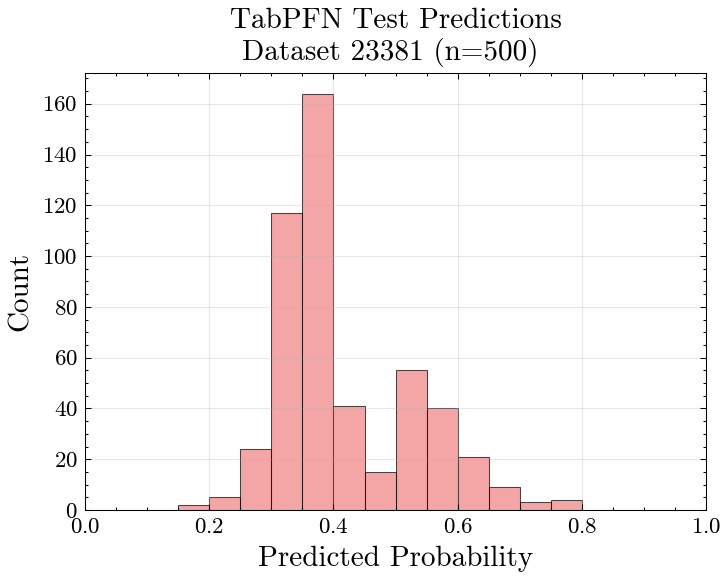


Test Predictions Summary for TabPFN - Dataset 23381
Total test predictions: 500
Fold contributions: {'fold_1': 100, 'fold_2': 100, 'fold_3': 100, 'fold_4': 100, 'fold_5': 100}
Mean: 0.4154
Std:  0.1100
Min:  0.1773
Max:  0.7865
Predictions > 0.5: 132 (26.4%)
Predictions < 0.1: 0 (0.0%)
Predictions > 0.9: 0 (0.0%)
Loaded from: ../data/output/hpo/student/23381_grande(tabpfn)_re.csv
Plot saved to: visual_outputs/test_probability_bins_all_folds_23381_grande_tabpfn_student_hpo_regression.pdf


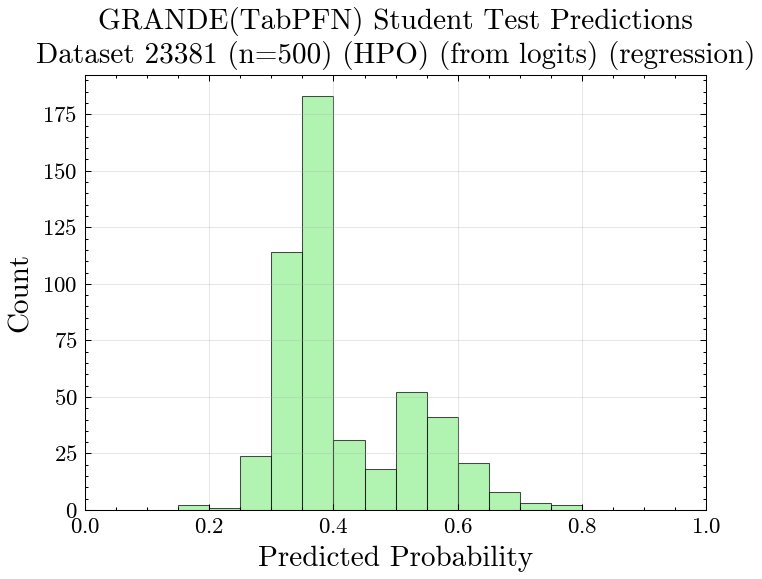


Test Predictions Summary for GRANDE(TabPFN) Student - Dataset 23381 (HPO) (Task: regression)
Total test predictions: 500
Fold contributions: {'all_folds': 500}
Mean: 0.4142
Std:  0.1063
Min:  0.1817
Max:  0.7810
Predictions > 0.5: 127 (25.4%)
Predictions < 0.1: 0 (0.0%)
Predictions > 0.9: 0 (0.0%)


In [24]:
dataset_id = '23381'  # Example dataset ID
model_name = 'grande'  # Example model name

# Example 2: Plot only test predictions across all folds (most common use case)
# Example usage for teacher model (original functionality)
test_preds_teacher = plot_test_predictions_only_all_folds(
    dataset_id=dataset_id, 
    model_name='tabpfn',
    model_type='teacher',
    hpo_type='default',
    bins=20,
    save_path='visual_outputs'
)

# Example usage for student model with student task filtering
test_preds_student = plot_test_predictions_only_all_folds(
    dataset_id=dataset_id, 
    model_name=model_name,
    teacher_model='tabpfn',
    model_type='student',
    student_task_filter='regression',  # Filter for binary classification student models
    hpo_type='hpo',
    bins=20,
    save_path='visual_outputs'
)

In [25]:
def plot_multiple_model_test_predictions(
    dataset_id, 
    model_names, 
    bins=20, 
    figsize=(12, 8), 
    save_path=None, 
    hpo_type='default',
    ncols=3
):
    """
    Plot test set predictions for multiple models in a grid layout.
    
    Parameters:
    -----------
    dataset_id : str
        The dataset ID (e.g., '1485')
    model_names : list
        List of model names (e.g., ['tabpfn', 'grande', 'catboost', 'mlp'])
    bins : int
        Number of histogram bins
    figsize : tuple
        Figure size (width, height)
    save_path : str or None
        Path to save the plot
    hpo_type : str
        'default' or 'hpo'
    ncols : int
        Number of columns in the subplot grid
    """
    
    # Define custom order: top row = random_forest, catboost, grande; bottom row = mlp, tabm, tabpfn
    preferred_order = ['random_forest', 'catboost', 'grande', 'mlp', 'tabm', 'tabpfn']
    
    # Sort model_names according to preferred order
    ordered_models = []
    for preferred_model in preferred_order:
        if preferred_model in model_names:
            ordered_models.append(preferred_model)
    
    # Add any models not in the preferred order at the end
    for model in model_names:
        if model not in ordered_models:
            ordered_models.append(model)
    
    # Use ordered models for plotting
    model_names = ordered_models
    
    # Calculate grid dimensions
    n_models = len(model_names)
    nrows = (n_models + ncols - 1) // ncols  # Ceiling division
    
    # Define colors for different models
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum', 'orange', 
              'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    with plt.style.context(['science', 'ieee', 'no-latex']):
        plt.rcParams.update({'figure.dpi': 150})
        
        fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
        
        # Handle case where we have only one row or one model
        if nrows == 1 and ncols == 1:
            axes = [axes]
        elif nrows == 1:
            axes = axes
        else:
            axes = axes.flatten()
        
        model_stats = {}  # Store statistics for summary
        
        for model_idx, model_name in enumerate(model_names):
            # Choose the correct path based on hpo_type
            if hpo_type == 'hpo':
                fold_file = f"../data/fold_indices/hpo/teacher/{dataset_id}_{model_name}.json"
            else:
                fold_file = f"../data/fold_indices/default/teacher/{dataset_id}_{model_name}.json"
            
            try:
                with open(fold_file, 'r') as f:
                    fold_data = json.load(f)
                
                # Aggregate test predictions across all folds
                all_test_preds = []
                for fold_name, fold_info in fold_data['outer_folds'].items():
                    test_preds = fold_info.get('test_preds', [])
                    all_test_preds.extend(test_preds)
                
                all_test_preds = np.array(all_test_preds)
                
                if len(all_test_preds) > 0:
                    # Plot histogram
                    ax = axes[model_idx]
                    color = "lightcoral"
                    
                    ax.hist(all_test_preds, bins=bins, alpha=0.7, color=color,
                           edgecolor='black', linewidth=0.5, range=(0, 1))
                    
                    # Calculate statistics
                    mean_pred = np.mean(all_test_preds)
                    std_pred = np.std(all_test_preds)
                    n_preds = len(all_test_preds)
                    
                    model_stats[model_name] = {
                        'mean': mean_pred,
                        'std': std_pred,
                        'count': n_preds,
                        'min': np.min(all_test_preds),
                        'max': np.max(all_test_preds)
                    }
                    
                    # Set title with model name and basic stats
                    ax.set_title(f'{prettify(model_name)}\n(n={n_preds:,}, mean={mean_pred:.3f})', 
                                fontsize=12)
                    ax.set_xlabel('Predicted Probability', fontsize=14)
                    ax.set_ylabel('Count', fontsize=14)
                    ax.set_xlim(0, 1)
                    ax.grid(True, alpha=0.3)
                    ax.tick_params(axis='both', which='major', labelsize=11)
                    
                else:
                    # No predictions found
                    ax = axes[model_idx]
                    ax.text(0.5, 0.5, f'{prettify(model_name)}\nNo predictions found', 
                           ha='center', va='center', transform=ax.transAxes, fontsize=12)
                    ax.set_xlim(0, 1)
                    ax.set_ylim(0, 1)
                    ax.grid(True, alpha=0.3)
                    
            except FileNotFoundError:
                # File not found
                ax = axes[model_idx]
                ax.text(0.5, 0.5, f'{prettify(model_name)}\nFile not found', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
                ax.grid(True, alpha=0.3)
        
        # Hide unused subplots
        for idx in range(n_models, len(axes)):
            axes[idx].set_visible(False)
        
        # Set overall title
        title_suffix = " (HPO)" if hpo_type == 'hpo' else ""
        fig.suptitle(f'Test Predictions Comparison - Dataset {dataset_id}{title_suffix}', 
                     fontsize=16)
        
        plt.tight_layout()
        
        if save_path:
            hpo_suffix = "_hpo" if hpo_type == 'hpo' else ""
            save_file = os.path.join(save_path, f'multiple_model_test_predictions_{dataset_id}{hpo_suffix}.pdf')
            os.makedirs(os.path.dirname(save_file), exist_ok=True)
            fig.savefig(save_file, dpi=300, bbox_inches='tight')
            print(f'Plot saved to: {save_file}')
        
        plt.show()
    
    # Print summary statistics
    hpo_label = " (HPO)" if hpo_type == 'hpo' else ""
    print(f"\nTest Predictions Summary - Dataset {dataset_id}{hpo_label}")
    print("="*80)
    
    for model_name in model_names:
        if model_name in model_stats:
            stats = model_stats[model_name]
            print(f"{prettify(model_name)}:")
            print(f"  Predictions: {stats['count']:,}")
            print(f"  Mean: {stats['mean']:.4f}")
            print(f"  Std:  {stats['std']:.4f}")
            print(f"  Range: [{stats['min']:.4f}, {stats['max']:.4f}]")
        else:
            print(f"{prettify(model_name)}: No data available")
    
    return model_stats

def plot_multiple_student_test_predictions(
    dataset_id, 
    student_teacher_pairs, 
    bins=20, 
    figsize=(12, 8), 
    save_path=None, 
    hpo_type='default',
    ncols=3,
    task_type='binary'  # Add task_type to determine postfix
):
    """
    Plot test set predictions for multiple student models and/or teacher models in a grid layout.
    
    Parameters:
    -----------
    dataset_id : str
        The dataset ID (e.g., '1485')
    student_teacher_pairs : list of tuples
        List of (student_model, teacher_model) pairs, or (None, teacher_model) for teacher-only plots
    bins : int
        Number of histogram bins
    figsize : tuple
        Figure size (width, height)
    save_path : str or None
        Path to save the plot
    hpo_type : str
        'default' or 'hpo'
    ncols : int
        Number of columns in the subplot grid
    """
    
    # Calculate grid dimensions
    n_models = len(student_teacher_pairs)
    nrows = (n_models + ncols - 1) // ncols  # Ceiling division
    
    # Define colors for different models
    colors = ['lightgreen', 'gold', 'plum', 'orange', 'lightcoral', 'skyblue',
              'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    with plt.style.context(['science', 'ieee', 'no-latex']):
        plt.rcParams.update({'figure.dpi': 150})
        
        fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
        
        # Handle case where we have only one row or one model
        if nrows == 1 and ncols == 1:
            axes = [axes]
        elif nrows == 1:
            axes = axes
        else:
            axes = axes.flatten()
        
        model_stats = {}  # Store statistics for summary
        
        for pair_idx, (student_model, teacher_model) in enumerate(student_teacher_pairs):
            if student_model is None:
                # Plot teacher model
                if hpo_type == 'hpo':
                    fold_file = f"../data/fold_indices/hpo/teacher/{dataset_id}_{teacher_model}.json"
                else:
                    fold_file = f"../data/fold_indices/default/teacher/{dataset_id}_{teacher_model}.json"
                
                try:
                    with open(fold_file, 'r') as f:
                        fold_data = json.load(f)
                    
                    # Aggregate test predictions across all folds
                    all_predictions = []
                    for fold_name, fold_info in fold_data['outer_folds'].items():
                        test_preds = fold_info.get('test_preds', [])
                        all_predictions.extend(test_preds)
                    
                    all_predictions = np.array(all_predictions)
                    
                    if len(all_predictions) > 0:
                        # Plot histogram
                        ax = axes[pair_idx]
                        color = "lightcoral"
                        
                        ax.hist(all_predictions, bins=bins, alpha=0.7, color=color,
                               edgecolor='black', linewidth=0.5, range=(0, 1))
                        
                        # Calculate statistics
                        mean_pred = np.mean(all_predictions)
                        std_pred = np.std(all_predictions)
                        n_preds = len(all_predictions)
                        
                        teacher_key = f"{teacher_model} (Teacher)"
                        model_stats[teacher_key] = {
                            'mean': mean_pred,
                            'std': std_pred,
                            'count': n_preds,
                            'min': np.min(all_predictions),
                            'max': np.max(all_predictions),
                            'is_logits': False
                        }
                        
                        # Set title with model name and basic stats
                        ax.set_title(f'{prettify(teacher_model)} (Teacher)\n(n={n_preds:,}, mean={mean_pred:.3f})', 
                                    fontsize=12)
                        ax.set_xlabel('Predicted Probability', fontsize=12)
                        ax.set_ylabel('Count', fontsize=12)
                        ax.set_xlim(0, 1)
                        ax.grid(True, alpha=0.3)
                        ax.tick_params(axis='both', which='major', labelsize=11)
                        
                    else:
                        # No predictions found
                        ax = axes[pair_idx]
                        ax.text(0.5, 0.5, f'{prettify(teacher_model)} (Teacher)\nNo predictions found', 
                               ha='center', va='center', transform=ax.transAxes, fontsize=12)
                        ax.set_xlim(0, 1)
                        ax.set_ylim(0, 1)
                        ax.grid(True, alpha=0.3)
                        
                except FileNotFoundError:
                    # File not found
                    ax = axes[pair_idx]
                    ax.text(0.5, 0.5, f'{prettify(teacher_model)} (Teacher)\nFile not found', 
                           ha='center', va='center', transform=ax.transAxes, fontsize=12)
                    ax.set_xlim(0, 1)
                    ax.set_ylim(0, 1)
                    ax.grid(True, alpha=0.3)
            else:
                # Plot student model (existing logic)
                postfix = '_bi' if task_type == 'binary' else '_re'
                data, is_logits = load_student_predictions(dataset_id, student_model, teacher_model, hpo_type, postfix=postfix)
                
                if data is not None:
                    # Extract predictions
                    all_predictions = extract_student_predictions_from_csv(data, is_logits)
                    
                    if len(all_predictions) > 0:
                        # Plot histogram
                        ax = axes[pair_idx]
                        color = "lightgreen"
                        
                        ax.hist(all_predictions, bins=bins, alpha=0.7, color=color,
                               edgecolor='black', linewidth=0.5, range=(0, 1))
                        
                        # Calculate statistics
                        mean_pred = np.mean(all_predictions)
                        std_pred = np.std(all_predictions)
                        n_preds = len(all_predictions)
                        
                        pair_key = f"{student_model}({teacher_model})"
                        model_stats[pair_key] = {
                            'mean': mean_pred,
                            'std': std_pred,
                            'count': n_preds,
                            'min': np.min(all_predictions),
                            'max': np.max(all_predictions),
                            'is_logits': is_logits
                        }
                        
                        # Set title with model name and basic stats
                        logit_suffix = ""
                        ax.set_title(f'{prettify(student_model)}({prettify(teacher_model)})\n(n={n_preds:,}, mean={mean_pred:.3f}){logit_suffix}', 
                                    fontsize=12)
                        ax.set_xlabel('Predicted Probability', fontsize=12)
                        ax.set_ylabel('Count', fontsize=12)
                        ax.set_xlim(0, 1)
                        ax.grid(True, alpha=0.3)
                        ax.tick_params(axis='both', which='major', labelsize=11)
                        
                    else:
                        # No predictions found
                        ax = axes[pair_idx]
                        ax.text(0.5, 0.5, f'{prettify(student_model)}({prettify(teacher_model)})\nNo predictions found', 
                               ha='center', va='center', transform=ax.transAxes, fontsize=12)
                        ax.set_xlim(0, 1)
                        ax.set_ylim(0, 1)
                        ax.grid(True, alpha=0.3)
                        
                else:
                    # File not found
                    ax = axes[pair_idx]
                    ax.text(0.5, 0.5, f'{prettify(student_model)}({prettify(teacher_model)})\nFile not found', 
                           ha='center', va='center', transform=ax.transAxes, fontsize=12)
                    ax.set_xlim(0, 1)
                    ax.set_ylim(0, 1)
                    ax.grid(True, alpha=0.3)
        
        # Hide unused subplots
        for idx in range(n_models, len(axes)):
            axes[idx].set_visible(False)
        
        # Set overall title
        title_suffix = " (HPO)" if hpo_type == 'hpo' else ""
        fig.suptitle(f'Student Test Predictions Comparison - Dataset {dataset_id}{title_suffix}', 
                     fontsize=16)
        
        plt.tight_layout()
        
        if save_path:
            hpo_suffix = "_hpo" if hpo_type == 'hpo' else ""
            save_file = os.path.join(save_path, f'multiple_student_test_predictions_{dataset_id}{hpo_suffix}.pdf')
            os.makedirs(os.path.dirname(save_file), exist_ok=True)
            fig.savefig(save_file, dpi=300, bbox_inches='tight')
            print(f'Plot saved to: {save_file}')
        
        plt.show()
    
    # Print summary statistics
    hpo_label = " (HPO)" if hpo_type == 'hpo' else ""
    print(f"\nStudent Test Predictions Summary - Dataset {dataset_id}{hpo_label}")
    print("="*80)
    
    for pair_key, stats in model_stats.items():
        if 'is_logits' in stats:
            logit_info = " (from logits)" if stats['is_logits'] else ""
        else:
            logit_info = ""
        print(f"{pair_key}{logit_info}:")
        print(f"  Predictions: {stats['count']:,}")
        print(f"  Mean: {stats['mean']:.4f}")
        print(f"  Std:  {stats['std']:.4f}")
        print(f"  Range: [{stats['min']:.4f}, {stats['max']:.4f}]")
    
    return model_stats

In [26]:
# datasets = [
#     23381, 40994, 6332, 1510, 1480, 40705, 1494, 1487, 1485, 40983, 40701, 1489, 40536, 4534
#     ]

# for dataset_id in datasets:
#     print(f"Processing dataset {dataset_id}...")
#     # Example 1: Plot 6 teacher models in a 3x2 grid
#     teacher_stats = plot_multiple_model_test_predictions(
#         dataset_id=dataset_id,
#         model_names=['tabpfn', 'grande', 'catboost', 'mlp', 'random_forest', 'tabm'],
#         bins=20,
#         figsize=(12, 8),
#         hpo_type='default',
#         ncols=3,  # This will create a 3x2 grid for 6 models
#         save_path='visual_outputs'
#     )
#     # Example 3: Plot student models in a grid
#     student_stats = plot_multiple_student_test_predictions(
#         dataset_id=f"{dataset_id}",
#         student_teacher_pairs=[
#             ('random_forest', 'tabpfn'),
#             ('catboost', 'tabpfn'),
#             ('grande', 'tabpfn'), 
#             ('mlp', 'tabpfn'),
#             ('tabm', 'tabpfn'),
#             (None, 'tabpfn')
#         ],
#         bins=20,
#         figsize=(12, 8),
#         hpo_type='default',
#         ncols=3,  # This will create a 3x2 grid for 6 student models
#         save_path='visual_outputs'
#     )

## Student

In [27]:
dataset_id = '23381'  # Example dataset ID
student_model = 'tabpfn'  # Example student model
teacher_model = 'grande'  # Example teacher model
bins= 20  # Number of bins for histogram
hpo_type = 'default'  # Use 'hpo' for HPO results

# Example 1: Plot student model predictions (with logits)
plot_student_predictions_all_folds(
    dataset_id=dataset_id,
    student_model=teacher_model,
    teacher_model=student_model,
    bins=bins,
    hpo_type=hpo_type,
    save_path='visual_outputs'
)

# # Example 2: Compare multiple student models with different teachers
# compare_student_models_all_folds(
#     dataset_id=dataset_id,
#     student_teacher_pairs=[
#         (teacher_model, student_model),
#     ],
#     bins=bins,
#     hpo_type=hpo_type,
#     # save_path='visual_outputs'
# )

# # Example 3: Compare teacher vs student
# compare_teacher_vs_student(
#     dataset_id=dataset_id,
#     student_model=teacher_model,
#     teacher_model=student_model,
#     bins=bins,
#     hpo_type=hpo_type,
#     # save_path='visual_outputs'
# )

No student model file found for grande(tabpfn) on dataset 23381


In [28]:
def plot_probability_distributions_across_all_datasets(
    model_names=None, 
    model_type='teacher',  # 'teacher', 'student', or 'both'
    hpo_type='default',
    bins=20,
    figsize=(12, 8),
    save_path=None,
    student_teacher_pairs=None  # For student models: [('mlp', 'tabpfn'), ('grande', 'tabpfn')]
):
    """
    Plot probability distributions across all datasets for specified models.
    
    Parameters:
    -----------
    model_names : list or None
        List of model names. If None, will use common models based on model_type
    model_type : str
        'teacher', 'student', or 'both'
    hpo_type : str
        'default' or 'hpo'
    bins : int
        Number of histogram bins
    figsize : tuple
        Figure size
    save_path : str or None
        Path to save the plot
    student_teacher_pairs : list of tuples
        For student models: [('student_model', 'teacher_model'), ...]
    """
    
    # Load dataset info to get all dataset IDs
    dataset_info = get_dataset_info()
    dataset_ids = list(dataset_info.keys())
    
    # Filter for binary classification datasets only (since we're plotting probabilities)
    binary_datasets = [did for did, info in dataset_info.items() if info['task_type'] == 'binary']
    
    if not binary_datasets:
        print("No binary classification datasets found")
        return
    
    # Define default models if not specified
    if model_type == 'teacher' and model_names is None:
        model_names = ['tabpfn', 'grande', 'catboost', 'mlp', 'random_forest']
    elif model_type == 'student' and student_teacher_pairs is None:
        student_teacher_pairs = [('mlp', 'tabpfn'), ('grande', 'tabpfn'), ('catboost', 'tabpfn')]
    
    # Collect all predictions across datasets
    all_predictions = {}
    
    with plt.style.context(['science', 'ieee', 'no-latex']):
        plt.rcParams.update({'figure.dpi': 150})
        
        if model_type == 'teacher':
            # Plot teacher models
            fig, axes = plt.subplots(2, 3, figsize=figsize)
            axes = axes.flatten()
            
            colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum', 'orange']
            
            for model_idx, model_name in enumerate(model_names[:6]):  # Limit to 6 models for subplot layout
                model_predictions = []
                datasets_found = 0
                
                for dataset_id in binary_datasets:
                    # Load teacher predictions
                    if hpo_type == 'hpo':
                        fold_file = f"../data/fold_indices/hpo/teacher/{dataset_id}_{model_name}.json"
                    else:
                        fold_file = f"../data/fold_indices/default/teacher/{dataset_id}_{model_name}.json"
                    
                    try:
                        with open(fold_file, 'r') as f:
                            fold_data = json.load(f)
                        
                        # Aggregate test predictions across all folds for this dataset
                        for fold_name, fold_info in fold_data['outer_folds'].items():
                            test_preds = fold_info.get('test_preds', [])
                            model_predictions.extend(test_preds)
                        
                        datasets_found += 1
                        
                    except FileNotFoundError:
                        continue
                
                if model_predictions:
                    model_predictions = np.array(model_predictions)
                    all_predictions[model_name] = model_predictions
                    
                    # Plot histogram
                    ax = axes[model_idx]
                    ax.hist(model_predictions, bins=bins, alpha=0.7, 
                           color=colors[model_idx % len(colors)],
                           edgecolor='black', linewidth=0.5, range=(0, 1))
                    
                    ax.set_title(f'{prettify(model_name)}\n({len(model_predictions):,} predictions, {datasets_found} datasets)')
                    ax.set_xlabel('Predicted Probability')
                    ax.set_ylabel('Count')
                    ax.set_xlim(0, 1)
                    ax.grid(True, alpha=0.3)
                    
                    # Add statistics text
                    mean_pred = np.mean(model_predictions)
                    ax.text(0.02, 0.98, f'μ={mean_pred:.3f}', transform=ax.transAxes, 
                           verticalalignment='top', fontsize=8)
            
            # Hide unused subplots
            for idx in range(len(model_names), len(axes)):
                axes[idx].set_visible(False)
            
            title_suffix = " (HPO)" if hpo_type == 'hpo' else ""
            fig.suptitle(f'Teacher Model Predictions Across All Datasets{title_suffix}', fontsize=16)
            
        elif model_type == 'student':
            # Plot student models
            n_pairs = len(student_teacher_pairs)
            n_cols = min(3, n_pairs)
            n_rows = (n_pairs + n_cols - 1) // n_cols
            
            fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
            if n_pairs == 1:
                axes = [axes]
            elif n_rows == 1:
                axes = axes if n_pairs > 1 else [axes]
            else:
                axes = axes.flatten()
            
            colors = ['lightgreen', 'gold', 'plum', 'orange', 'lightcoral', 'skyblue']
            
            for pair_idx, (student_model, teacher_model) in enumerate(student_teacher_pairs):
                model_predictions = []
                datasets_found = 0
                logits_count = 0
                
                for dataset_id in binary_datasets:
                    data, is_logits = load_student_predictions(dataset_id, student_model, teacher_model, hpo_type)
                    
                    if data is not None:
                        preds = extract_student_predictions_from_csv(data, is_logits)
                        model_predictions.extend(preds)
                        datasets_found += 1
                        if is_logits:
                            logits_count += 1
                
                if model_predictions:
                    model_predictions = np.array(model_predictions)
                    pair_key = f"{student_model}({teacher_model})"
                    all_predictions[pair_key] = model_predictions
                    
                    # Plot histogram
                    ax = axes[pair_idx] if len(axes) > 1 else axes[0]
                    ax.hist(model_predictions, bins=bins, alpha=0.7, 
                           color=colors[pair_idx % len(colors)],
                           edgecolor='black', linewidth=0.5, range=(0, 1))
                    
                    logit_info = f" ({logits_count} logit)" if logits_count > 0 else ""
                    ax.set_title(f'{prettify(student_model)}({prettify(teacher_model)})\n({len(model_predictions):,} predictions, {datasets_found} datasets{logit_info})')
                    ax.set_xlabel('Predicted Probability')
                    ax.set_ylabel('Count')
                    ax.set_xlim(0, 1)
                    ax.grid(True, alpha=0.3)
                    
                    # Add statistics text
                    mean_pred = np.mean(model_predictions)
                    ax.text(0.02, 0.98, f'μ={mean_pred:.3f}', transform=ax.transAxes, 
                           verticalalignment='top', fontsize=8)
            
            # Hide unused subplots
            for idx in range(len(student_teacher_pairs), len(axes)):
                axes[idx].set_visible(False)
            
            title_suffix = " (HPO)" if hpo_type == 'hpo' else ""
            fig.suptitle(f'Student Model Predictions Across All Datasets{title_suffix}', fontsize=16)
        
        elif model_type == 'both':
            # Combined plot with both teacher and student models
            fig, ax = plt.subplots(figsize=figsize)
            
            colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum', 'orange', 'purple', 'brown']
            color_idx = 0
            
            # Plot teacher models
            if model_names:
                for model_name in model_names:
                    model_predictions = []
                    datasets_found = 0
                    
                    for dataset_id in binary_datasets:
                        if hpo_type == 'hpo':
                            fold_file = f"../data/fold_indices/hpo/teacher/{dataset_id}_{model_name}.json"
                        else:
                            fold_file = f"../data/fold_indices/default/teacher/{dataset_id}_{model_name}.json"
                        
                        try:
                            with open(fold_file, 'r') as f:
                                fold_data = json.load(f)
                            
                            for fold_name, fold_info in fold_data['outer_folds'].items():
                                test_preds = fold_info.get('test_preds', [])
                                model_predictions.extend(test_preds)
                            
                            datasets_found += 1
                            
                        except FileNotFoundError:
                            continue
                    
                    if model_predictions:
                        model_predictions = np.array(model_predictions)
                        ax.hist(model_predictions, bins=bins, alpha=0.6, 
                               color=colors[color_idx % len(colors)],
                               label=f'{prettify(model_name)} (Teacher, {datasets_found}d)',
                               edgecolor='black', linewidth=0.5, range=(0, 1))
                        color_idx += 1
            
            # Plot student models
            if student_teacher_pairs:
                for student_model, teacher_model in student_teacher_pairs:
                    model_predictions = []
                    datasets_found = 0
                    
                    for dataset_id in binary_datasets:
                        data, is_logits = load_student_predictions(dataset_id, student_model, teacher_model, hpo_type)
                        
                        if data is not None:
                            preds = extract_student_predictions_from_csv(data, is_logits)
                            model_predictions.extend(preds)
                            datasets_found += 1
                    
                    if model_predictions:
                        model_predictions = np.array(model_predictions)
                        ax.hist(model_predictions, bins=bins, alpha=0.6, 
                               color=colors[color_idx % len(colors)],
                               label=f'{prettify(student_model)}({prettify(teacher_model)}) (Student, {datasets_found}d)',
                               edgecolor='black', linewidth=0.5, range=(0, 1))
                        color_idx += 1
            
            ax.set_xlabel('Predicted Probability', fontsize=12)
            ax.set_ylabel('Count', fontsize=12)
            title_suffix = " (HPO)" if hpo_type == 'hpo' else ""
            ax.set_title(f'Model Predictions Across All Datasets{title_suffix}', fontsize=14)
            ax.set_xlim(0, 1)
            ax.grid(True, alpha=0.3)
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        
        if save_path:
            hpo_suffix = "_hpo" if hpo_type == 'hpo' else ""
            save_file = os.path.join(save_path, f'probability_distributions_all_datasets_{model_type}{hpo_suffix}.pdf')
            os.makedirs(os.path.dirname(save_file), exist_ok=True)
            fig.savefig(save_file, dpi=300, bbox_inches='tight')
            print(f'Plot saved to: {save_file}')
        
        plt.show()
    
    # Print summary statistics
    print(f"\nSummary Statistics Across All Datasets ({model_type} models)")
    print("="*80)
    print(f"Binary datasets analyzed: {len(binary_datasets)}")
    print(f"Dataset IDs: {binary_datasets}")
    
    for model_name, predictions in all_predictions.items():
        print(f"\n{model_name}:")
        print(f"  Total predictions: {len(predictions):,}")
        print(f"  Mean: {np.mean(predictions):.4f}")
        print(f"  Std:  {np.std(predictions):.4f}")
        print(f"  Min:  {np.min(predictions):.4f}")
        print(f"  Max:  {np.max(predictions):.4f}")
        print(f"  Predictions > 0.5: {np.sum(predictions > 0.5):,} ({np.sum(predictions > 0.5)/len(predictions)*100:.1f}%)")
        print(f"  Predictions < 0.1: {np.sum(predictions < 0.1):,} ({np.sum(predictions < 0.1)/len(predictions)*100:.1f}%)")
        print(f"  Predictions > 0.9: {np.sum(predictions > 0.9):,} ({np.sum(predictions > 0.9)/len(predictions)*100:.1f}%)")
    
    return all_predictions

/tmp/ipykernel_1875657/1621285410.py:245: UserWarning: Glyph 956 (\N{GREEK SMALL LETTER MU}) missing from font(s) cmr10.
  plt.tight_layout()
/home/mherre/miniconda3/envs/thesis/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 956 (\N{GREEK SMALL LETTER MU}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


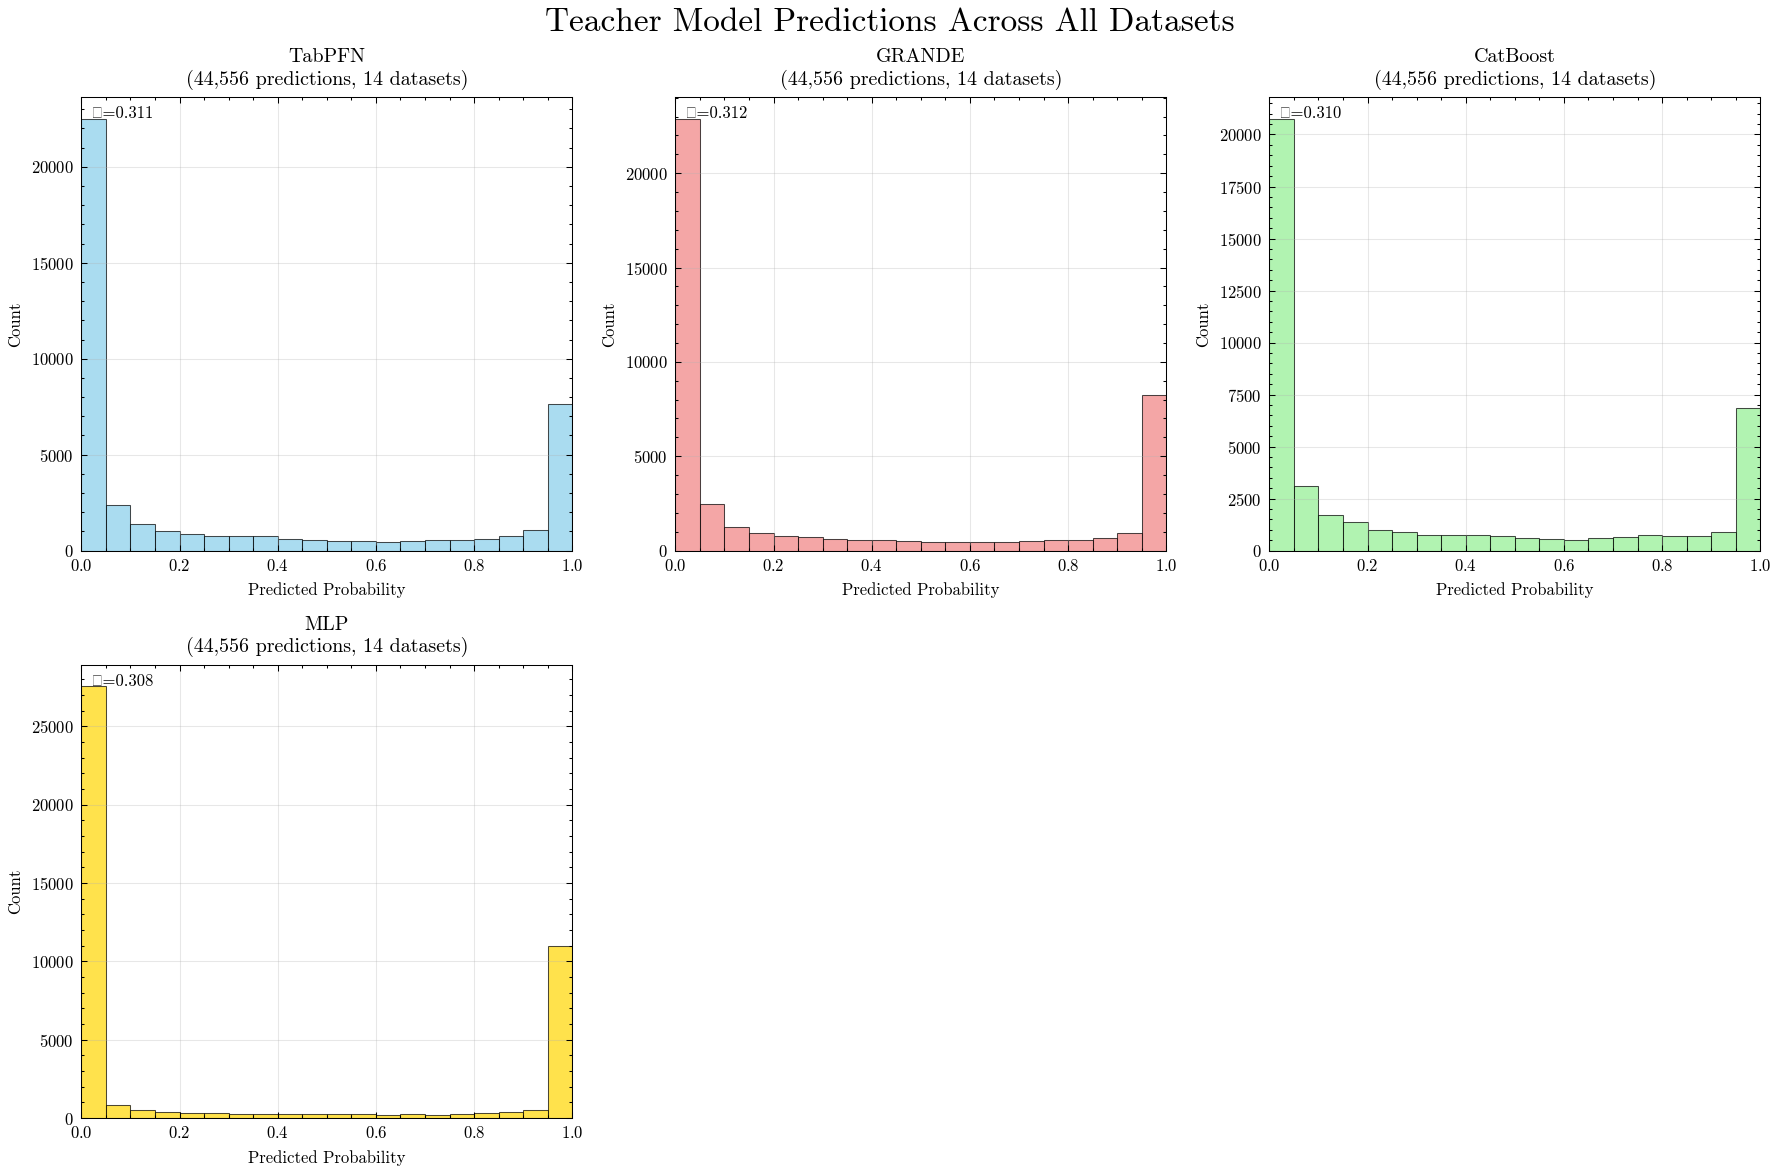


Summary Statistics Across All Datasets (teacher models)
Binary datasets analyzed: 14
Dataset IDs: ['23381', '40994', '6332', '1510', '1480', '40705', '1494', '1487', '1485', '40983', '40701', '1489', '40536', '4534']

tabpfn:
  Total predictions: 44,556
  Mean: 0.3109
  Std:  0.3965
  Min:  0.0000
  Max:  1.0000
  Predictions > 0.5: 13,058 (29.3%)
  Predictions < 0.1: 24,864 (55.8%)
  Predictions > 0.9: 8,681 (19.5%)

grande:
  Total predictions: 44,556
  Mean: 0.3124
  Std:  0.4035
  Min:  0.0000
  Max:  1.0000
  Predictions > 0.5: 13,291 (29.8%)
  Predictions < 0.1: 25,352 (56.9%)
  Predictions > 0.9: 9,160 (20.6%)

catboost:
  Total predictions: 44,556
  Mean: 0.3101
  Std:  0.3830
  Min:  0.0000
  Max:  1.0000
  Predictions > 0.5: 12,823 (28.8%)
  Predictions < 0.1: 23,852 (53.5%)
  Predictions > 0.9: 7,737 (17.4%)

mlp:
  Total predictions: 44,556
  Mean: 0.3085
  Std:  0.4356
  Min:  0.0000
  Max:  1.0000
  Predictions > 0.5: 13,586 (30.5%)
  Predictions < 0.1: 28,367 (63.7%)
  

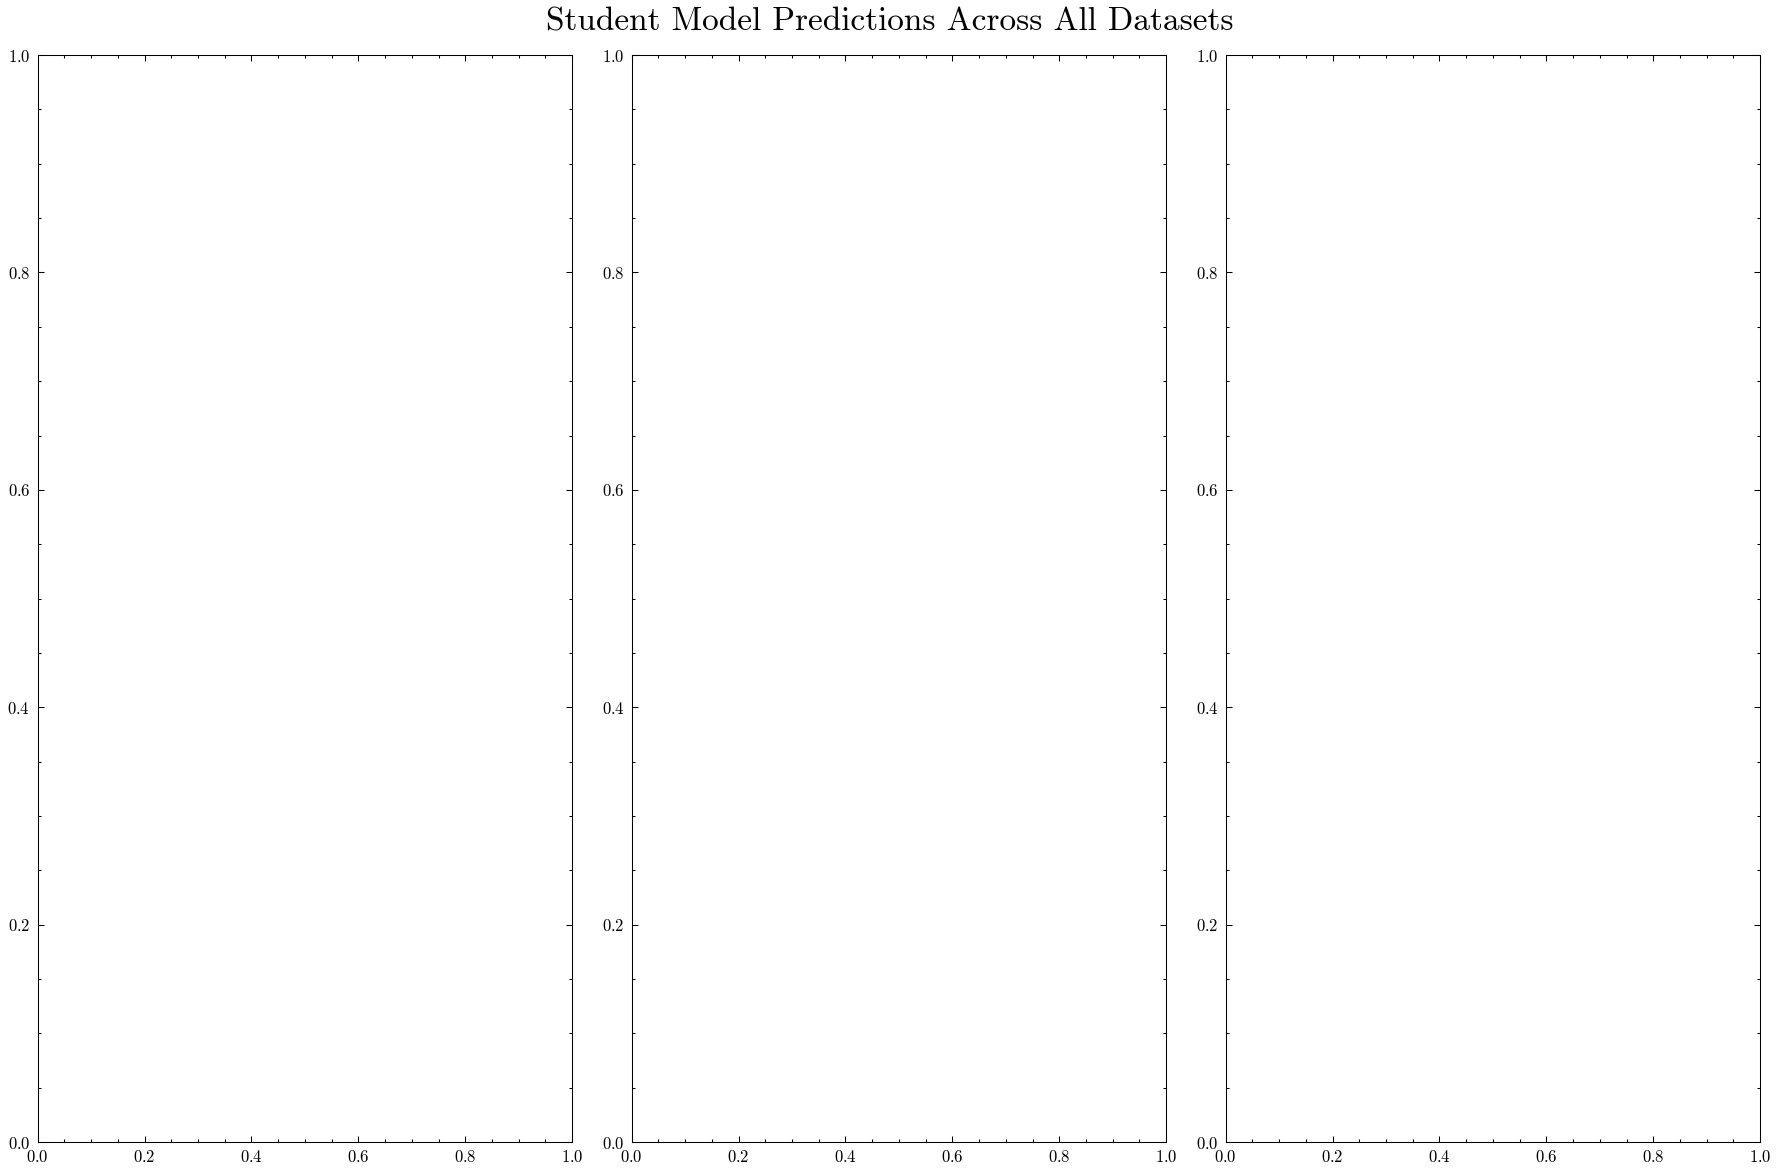


Summary Statistics Across All Datasets (student models)
Binary datasets analyzed: 14
Dataset IDs: ['23381', '40994', '6332', '1510', '1480', '40705', '1494', '1487', '1485', '40983', '40701', '1489', '40536', '4534']
No student model file found for mlp(tabpfn) on dataset 23381
No student model file found for mlp(tabpfn) on dataset 40994
No student model file found for mlp(tabpfn) on dataset 6332
No student model file found for mlp(tabpfn) on dataset 1510
No student model file found for mlp(tabpfn) on dataset 1480
No student model file found for mlp(tabpfn) on dataset 40705
No student model file found for mlp(tabpfn) on dataset 1494
No student model file found for mlp(tabpfn) on dataset 1487
No student model file found for mlp(tabpfn) on dataset 1485
No student model file found for mlp(tabpfn) on dataset 40983
No student model file found for mlp(tabpfn) on dataset 40701
No student model file found for mlp(tabpfn) on dataset 1489
No student model file found for mlp(tabpfn) on dataset 40

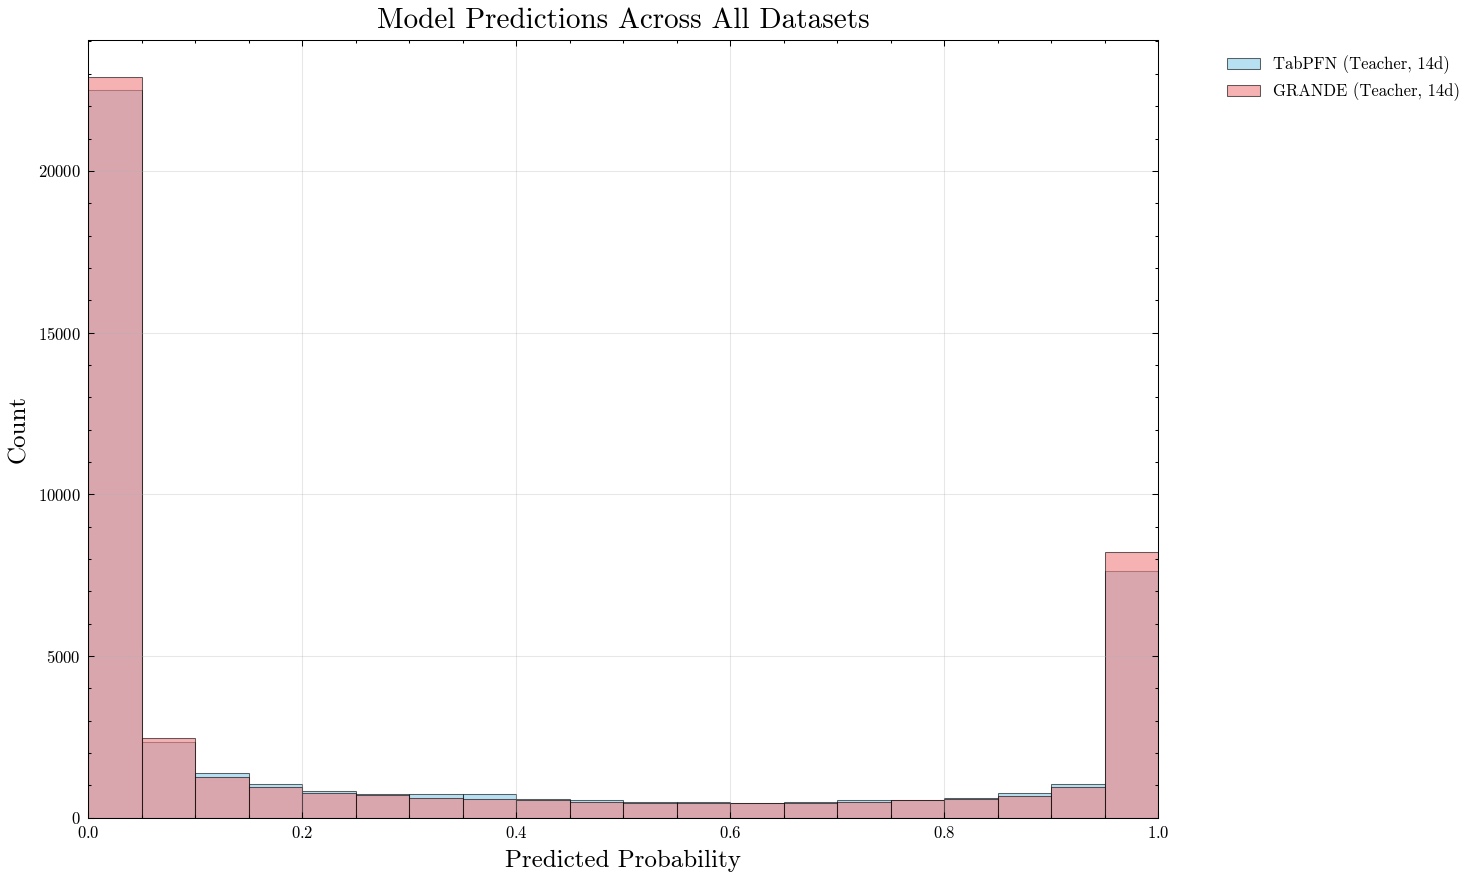


Summary Statistics Across All Datasets (both models)
Binary datasets analyzed: 14
Dataset IDs: ['23381', '40994', '6332', '1510', '1480', '40705', '1494', '1487', '1485', '40983', '40701', '1489', '40536', '4534']


/tmp/ipykernel_1875657/1621285410.py:245: UserWarning: Glyph 956 (\N{GREEK SMALL LETTER MU}) missing from font(s) cmr10.
  plt.tight_layout()
/home/mherre/miniconda3/envs/thesis/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 956 (\N{GREEK SMALL LETTER MU}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


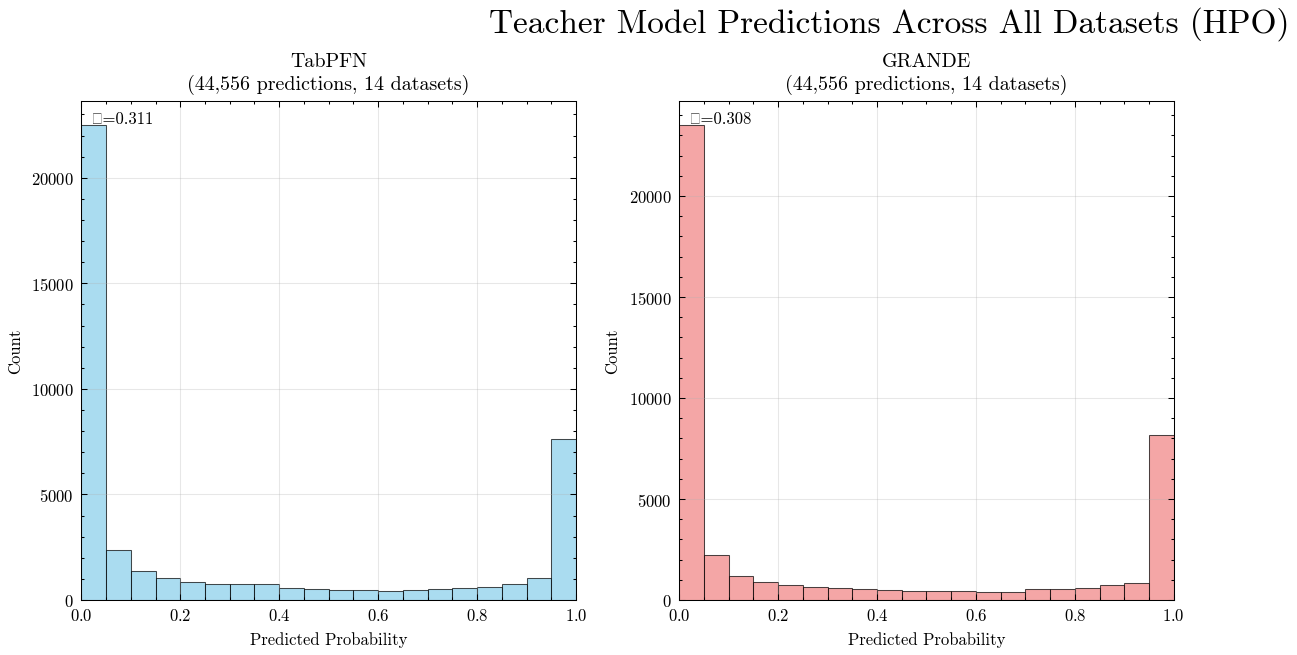


Summary Statistics Across All Datasets (teacher models)
Binary datasets analyzed: 14
Dataset IDs: ['23381', '40994', '6332', '1510', '1480', '40705', '1494', '1487', '1485', '40983', '40701', '1489', '40536', '4534']

tabpfn:
  Total predictions: 44,556
  Mean: 0.3109
  Std:  0.3965
  Min:  0.0000
  Max:  1.0000
  Predictions > 0.5: 13,058 (29.3%)
  Predictions < 0.1: 24,864 (55.8%)
  Predictions > 0.9: 8,681 (19.5%)

grande:
  Total predictions: 44,556
  Mean: 0.3075
  Std:  0.4041
  Min:  0.0000
  Max:  1.0000
  Predictions > 0.5: 13,156 (29.5%)
  Predictions < 0.1: 25,769 (57.8%)
  Predictions > 0.9: 9,014 (20.2%)


In [29]:
# Example 1: Plot teacher models across all datasets
teacher_preds = plot_probability_distributions_across_all_datasets(
    model_names=['tabpfn', 'grande', 'catboost', 'mlp'],
    model_type='teacher',
    hpo_type='default',
    # save_path='visual_outputs'
)

# Example 2: Plot student models across all datasets
student_preds = plot_probability_distributions_across_all_datasets(
    model_type='student',
    student_teacher_pairs=[
        ('mlp', 'tabpfn'), 
        ('grande', 'tabpfn'), 
        ('catboost', 'tabpfn')
    ],
    hpo_type='default',
    # save_path='visual_outputs'
)

# Example 3: Plot both teacher and student models in one plot
both_preds = plot_probability_distributions_across_all_datasets(
    model_names=['tabpfn', 'grande'],
    model_type='both',
    student_teacher_pairs=[('mlp', 'tabpfn'), ('grande', 'tabpfn')],
    hpo_type='default',
    figsize=(10, 6),
    # save_path='visual_outputs'
)

# Example 4: Focus on specific models with HPO
hpo_preds = plot_probability_distributions_across_all_datasets(
    model_names=['tabpfn', 'grande'],
    model_type='teacher',
    hpo_type='hpo',
    # save_path='visual_outputs'
)

# Compare Binary Label Distillation with Logits Distillation

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

def display_distillation_comparison_table(metric='f1', task_filter='binary', hpo_filter=False):
    """
    Compares student model performance between binary and regression (logits) distillation tasks,
    displays a table of the differences, and plots a heatmap of the results.
    
    Parameters:
    -----------
    metric : str
        The metric to compare (e.g., 'f1').
    task_filter : str
        The original task filter for the datasets (e.g., 'binary').
    hpo_filter : bool or None
        Filter by use_hpo flag.
    """
    
    # 1. Generate the two results tables
    df_binary = create_results_table(metric=metric, task_filter=task_filter, model_filter='student', 
                                     hpo_filter=hpo_filter, student_task_filter='binary')
    
    df_regression = create_results_table(metric=metric, task_filter=task_filter, model_filter='student', 
                                         hpo_filter=hpo_filter, student_task_filter='regression')

    if df_binary.empty or df_regression.empty:
        print("One or both of the distillation method tables are empty. Cannot create comparison.")
        return

    # 2. Prepare DataFrames for comparison
    df_binary = df_binary.set_index(['Dataset ID', 'Dataset Name', 'Size', 'Task Type'])
    df_regression = df_regression.set_index(['Dataset ID', 'Dataset Name', 'Size', 'Task Type'])

    # 3. Create the difference DataFrame
    diff_df = pd.DataFrame(index=df_binary.index)

    # 4. Find matching model columns and calculate differences
    for col_bin in df_binary.columns:
        # Construct the corresponding regression column name
        # e.g., 'mlp(tabpfn)_student_hpoFalse_binary' -> 'mlp(tabpfn)_student_hpoFalse_regression'
        col_reg = col_bin.replace('_binary', '_regression')
        
        if col_reg in df_regression.columns:
            # Extract mean values from "mean ± std" strings
            binary_means = df_binary[col_bin].str.split(' ± ').str[0].astype(float)
            regression_means = df_regression[col_reg].str.split(' ± ').str[0].astype(float)
            
            # Calculate the difference (Binary - Regression)
            diff = (binary_means - regression_means)
            
            # Use a shorter, prettier name for the column in the output table
            # e.g., 'mlp(tabpfn)_student_hpoFalse_binary' -> 'mlp(tabpfn)'
            pretty_col_name = col_bin.split('_student_hpo')[0]
            diff_df[pretty_col_name] = diff

    diff_df.reset_index(inplace=True)
    
    # 5. Calculate and append the mean improvement row with std
    info_cols = ['Dataset ID', 'Dataset Name', 'Size', 'Task Type']
    model_cols = [col for col in diff_df.columns if col not in info_cols]
    
    # Calculate mean and std improvements
    mean_improvements = {}
    for col in model_cols:
        mean_val = diff_df[col].mean()
        std_val = diff_df[col].std()
        mean_improvements[col] = f"{mean_val:.4f} ± {std_val:.4f}"
    
    mean_row = {'Dataset Name': '**Mean Improvement**'}
    mean_row.update(mean_improvements)
    
    # Append the mean row to the diff_df
    diff_df_with_mean = pd.concat([diff_df, pd.DataFrame([mean_row])], ignore_index=True)
    diff_df_with_mean.fillna('', inplace=True) # Fill NaNs in info columns for the mean row

    # 6. Display the styled difference table
    print(f"Performance Difference in {metric.upper()} (Binary - Logits Distillation)")
    print("Positive values (blue) mean binary distillation performed better.")
    print(f"Task: {task_filter}, HPO: {hpo_filter}")
    print("="*80)
    
    # Apply formatting - different formatting for the mean row
    def format_cell(val, row_idx, col_name):
        if col_name in model_cols:
            if row_idx == len(diff_df_with_mean) - 1:  # Last row (mean row)
                return val  # Already formatted as "mean ± std"
            else:
                try:
                    return f'{float(val):+.4f}'
                except (ValueError, TypeError):
                    return val
        return val
    
    # Create a copy for styling
    styled_data = diff_df_with_mean.copy()
    for col in model_cols:
        for idx in range(len(styled_data) - 1):  # All rows except the mean row
            try:
                styled_data.loc[idx, col] = f'{float(styled_data.loc[idx, col]):+.4f}'
            except (ValueError, TypeError):
                pass
    
    styled_df = styled_data.style.hide(axis="index")
    display(styled_df)
    
    # 7. Create and display the heatmap (using original data without mean row)
    heatmap_data = diff_df.set_index('Dataset Name')[model_cols]
    
    # Determine appropriate figure size
    fig_height = max(6, len(heatmap_data) * 0.4)
    fig_width = max(8, len(model_cols) * 1.2)
    
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(
        heatmap_data, 
        annot=True, 
        fmt=".3f", 
        cmap="RdBu_r",  # Red-Blue diverging palette (Red for negative, Blue for positive)
        center=0,      # Center the colormap at zero
        linewidths=.5,
        cbar_kws={'label': f'Difference in {metric.upper()} (Binary - Logits)'}
    )
    plt.title(f'Performance Difference: Binary vs. Logits Distillation ({metric.upper()})', fontsize=16)
    plt.ylabel('Dataset')
    plt.xlabel('Model')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    return diff_df_with_mean

Performance Difference in ROC (Binary - Logits Distillation)
Positive values (blue) mean binary distillation performed better.
Task: binary, HPO: False


/tmp/ipykernel_1875657/627149384.py:74: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  diff_df_with_mean.fillna('', inplace=True) # Fill NaNs in info columns for the mean row


Dataset ID,Dataset Name,Size,Task Type,catboost(tabpfn),grande(tabpfn),mlp(tabpfn),random_forest(tabpfn),tabm(tabpfn)
23381,dresses-sales,500.000000,binary,-0.0290,-0.0250,+0.0160,-0.0310,-0.0100
40994,climate-model-simulation-crashes,540.000000,binary,-0.0470,-0.0130,-0.0280,-0.0430,+0.0070
6332,cylinder-bands,540.000000,binary,-0.0240,-0.0360,-0.0170,+0.0140,-0.0470
1510,wdbc,569.000000,binary,-0.0040,-0.0030,-0.0010,-0.0030,+0.0000
1480,ilpd,583.000000,binary,-0.0550,-0.0550,-0.0250,-0.0540,-0.0470
40705,tokyo1,959.000000,binary,-0.0060,-0.0050,-0.0150,-0.0030,-0.0030
1494,qsar-biodeg,1055.000000,binary,-0.0040,-0.0130,-0.0140,+0.0060,-0.0090
1487,ozone-level-8hr,2534.000000,binary,-0.0240,-0.0260,-0.0300,-0.0340,-0.0200
1485,madelon,2600.000000,binary,-0.0040,-0.0180,-0.0370,-0.0940,-0.1300
40983,wilt,4839.000000,binary,-0.0030,-0.0040,-0.0040,-0.0050,-0.0020


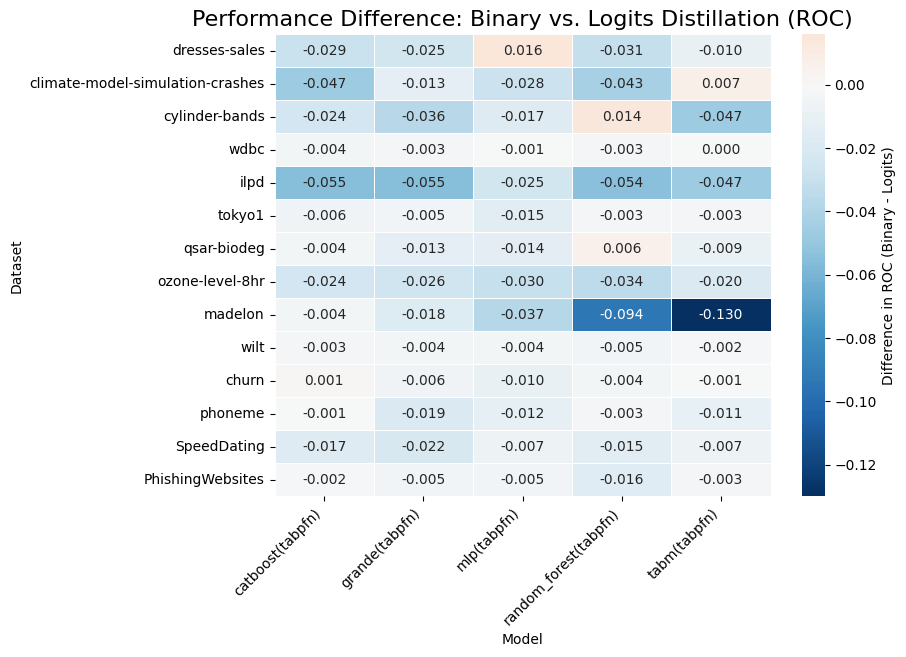

In [31]:
comparison_table = display_distillation_comparison_table(metric='roc', task_filter='binary', hpo_filter=False)

# Compare Distillation HPO vs no HPO

In [32]:
def display_hpo_comparison_table(metric='f1', task_filter='binary', student_task_filter='binary'):
    """
    Compares student model performance between HPO and no-HPO settings,
    displays a table of the differences, and plots a heatmap of the results.
    
    Parameters:
    -----------
    metric : str
        The metric to compare (e.g., 'f1').
    task_filter : str
        The original task filter for the datasets (e.g., 'binary').
    student_task_filter : str
        Filter student models by their task type ('binary', 'regression').
    """
    
    # 1. Generate the two results tables
    df_no_hpo = create_results_table(metric=metric, task_filter=task_filter, model_filter='student', 
                                     hpo_filter=False, student_task_filter=student_task_filter)
    
    df_with_hpo = create_results_table(metric=metric, task_filter=task_filter, model_filter='student', 
                                       hpo_filter=True, student_task_filter=student_task_filter)

    if df_no_hpo.empty or df_with_hpo.empty:
        print("One or both of the HPO comparison tables are empty. Cannot create comparison.")
        return

    # 2. Prepare DataFrames for comparison
    df_no_hpo = df_no_hpo.set_index(['Dataset ID', 'Dataset Name', 'Size', 'Task Type'])
    df_with_hpo = df_with_hpo.set_index(['Dataset ID', 'Dataset Name', 'Size', 'Task Type'])

    # 3. Create the difference DataFrame
    diff_df = pd.DataFrame(index=df_no_hpo.index)

    # 4. Find matching model columns and calculate differences
    for col_no_hpo in df_no_hpo.columns:
        # Construct the corresponding HPO column name
        # e.g., 'mlp(tabpfn)_student_hpoFalse_binary' -> 'mlp(tabpfn)_student_hpoTrue_binary'
        col_with_hpo = col_no_hpo.replace('_hpoFalse_', '_hpoTrue_')
        
        if col_with_hpo in df_with_hpo.columns:
            # Extract mean values from "mean ± std" strings
            no_hpo_means = df_no_hpo[col_no_hpo].str.split(' ± ').str[0].astype(float)
            with_hpo_means = df_with_hpo[col_with_hpo].str.split(' ± ').str[0].astype(float)
            
            # Calculate the difference (HPO - No HPO)
            diff = (with_hpo_means - no_hpo_means)
            
            # Use a shorter, prettier name for the column in the output table
            # e.g., 'mlp(tabpfn)_student_hpoFalse_binary' -> 'mlp(tabpfn)'
            pretty_col_name = col_no_hpo.split('_student_hpo')[0]
            if '(' in pretty_col_name and ')' in pretty_col_name:
                # Extract student and teacher parts for prettier display
                main_part = pretty_col_name
                if '(' in main_part and ')' in main_part:
                    teacher_part = main_part.split('(')[1].split(')')[0]
                    student_part = main_part.split('(')[0]
                    pretty_col_name = f"{prettify(student_part)}({prettify(teacher_part)})"
            else:
                pretty_col_name = prettify(pretty_col_name)
            
            diff_df[pretty_col_name] = diff

    diff_df.reset_index(inplace=True)
    
    # 5. Calculate and append the mean improvement row with std
    info_cols = ['Dataset ID', 'Dataset Name', 'Size', 'Task Type']
    model_cols = [col for col in diff_df.columns if col not in info_cols]
    
    # Calculate mean and std improvements
    mean_improvements = {}
    for col in model_cols:
        mean_val = diff_df[col].mean()
        std_val = diff_df[col].std()
        mean_improvements[col] = f"{mean_val:.4f} ± {std_val:.4f}"
    
    mean_row = {'Dataset Name': '**Mean Improvement**'}
    mean_row.update(mean_improvements)
    
    # Append the mean row to the diff_df
    diff_df_with_mean = pd.concat([diff_df, pd.DataFrame([mean_row])], ignore_index=True)
    diff_df_with_mean.fillna('', inplace=True) # Fill NaNs in info columns for the mean row

    # 6. Display the styled difference table
    print(f"Performance Difference in {metric.upper()} (With HPO - Without HPO)")
    print("Positive values (blue) mean HPO improved performance.")
    print(f"Task: {task_filter}, Student Task: {student_task_filter}")
    print("="*80)
    
    # Apply formatting - different formatting for the mean row
    def format_cell(val, row_idx, col_name):
        if col_name in model_cols:
            if row_idx == len(diff_df_with_mean) - 1:  # Last row (mean row)
                return val  # Already formatted as "mean ± std"
            else:
                try:
                    return f'{float(val):+.4f}'
                except (ValueError, TypeError):
                    return val
        return val
    
    # Create a copy for styling
    styled_data = diff_df_with_mean.copy()
    for col in model_cols:
        for idx in range(len(styled_data) - 1):  # All rows except the mean row
            try:
                styled_data.loc[idx, col] = f'{float(styled_data.loc[idx, col]):+.4f}'
            except (ValueError, TypeError):
                pass
    
    styled_df = styled_data.style.hide(axis="index")
    display(styled_df)
    
    # 7. Create and display the heatmap (using original data without mean row)
    heatmap_data = diff_df.set_index('Dataset Name')[model_cols]
    
    # Determine appropriate figure size
    fig_height = max(6, len(heatmap_data) * 0.4)
    fig_width = max(8, len(model_cols) * 1.2)
    
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(
        heatmap_data, 
        annot=True, 
        fmt=".3f", 
        cmap="RdBu_r",  # Red-Blue diverging palette (Red for negative, Blue for positive)
        center=0,      # Center the colormap at zero
        linewidths=.5,
        cbar_kws={'label': f'Difference in {metric.upper()} (HPO - No HPO)'}
    )
    plt.title(f'Performance Difference: With HPO vs. Without HPO ({metric.upper()})', fontsize=16)
    plt.ylabel('Dataset')
    plt.xlabel('Model')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return diff_df_with_mean

Performance Difference in ROC (With HPO - Without HPO)
Positive values (blue) mean HPO improved performance.
Task: binary, Student Task: regression


/tmp/ipykernel_1875657/3874603719.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  diff_df_with_mean.fillna('', inplace=True) # Fill NaNs in info columns for the mean row


Dataset ID,Dataset Name,Size,Task Type,CatBoost(TabPFN),GRANDE(TabPFN),MLP(TabPFN),Random Forest(TabPFN),TabM(TabPFN)
23381,dresses-sales,500.000000,binary,+0.0060,+0.0050,+0.0080,-0.0010,-0.0020
40994,climate-model-simulation-crashes,540.000000,binary,+0.0000,-0.0020,+0.0170,+0.0010,+0.0020
6332,cylinder-bands,540.000000,binary,-0.0130,-0.0210,-0.0010,-0.0010,-0.0110
1510,wdbc,569.000000,binary,+0.0000,+0.0000,+0.0000,+0.0000,+0.0010
1480,ilpd,583.000000,binary,-0.0020,+0.0030,+0.0030,+0.0010,-0.0080
40705,tokyo1,959.000000,binary,-0.0010,+0.0000,-0.0010,+0.0010,+0.0000
1494,qsar-biodeg,1055.000000,binary,-0.0050,+0.0000,-0.0010,+0.0050,-0.0010
1487,ozone-level-8hr,2534.000000,binary,-0.0010,+0.0000,-0.0010,+0.0020,+0.0010
1485,madelon,2600.000000,binary,+0.0100,+0.0110,-0.0160,+0.0160,+0.0650
40983,wilt,4839.000000,binary,+0.0000,+0.0000,+0.0000,+0.0000,+0.0000


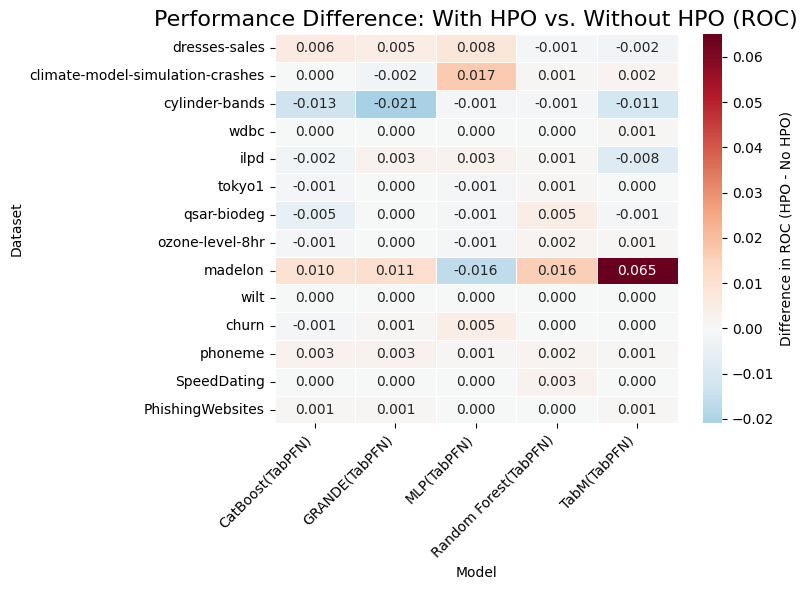

In [35]:
# Compare regression distillation student models with and without HPO
hpo_comparison_table_reg = display_hpo_comparison_table(
    metric='roc', 
    task_filter='binary', 
    student_task_filter='regression'
)

In [ ]:

# For regression datasets comparing regression student models
hpo_comparison_reg_datasets = display_hpo_comparison_table(
    metric='mae', 
    task_filter='regression', 
    student_task_filter='regression'
)

# Compare HPO Fidelity Metrics to no-HPO

In [86]:
def display_fidelity_hpo_comparison_table(original_task_filter=None, student_task_filter=None):
    """
    Compares student model fidelity metrics between HPO and no-HPO settings,
    displays a table of the differences, and plots a heatmap of the results.
    
    Parameters:
    -----------
    original_task_filter : str or None
        Filter by original task type ('binary', 'regression', or None for all)
    student_task_filter : str or None
        Filter by student task type ('binary', 'regression', or None for all)
    """
    
    # 1. Generate the two fidelity tables
    df_no_hpo = create_fidelity_table(original_task_filter=original_task_filter, 
                                      student_task_filter=student_task_filter, 
                                      hpo_filter=False)
    
    df_with_hpo = create_fidelity_table(original_task_filter=original_task_filter, 
                                        student_task_filter=student_task_filter, 
                                        hpo_filter=True)

    if df_no_hpo.empty or df_with_hpo.empty:
        print("One or both of the fidelity HPO comparison tables are empty. Cannot create comparison.")
        return

    # 2. Create the difference DataFrame
    diff_df = pd.DataFrame(index=df_no_hpo.index)

    # 3. Find matching model columns and calculate differences
    for col in df_no_hpo.columns:
        if col in df_with_hpo.columns:
            # Extract mean values from "mean ± std" strings for each metric
            for metric in df_no_hpo.index:
                try:
                    # Extract mean from "mean ± std" format
                    no_hpo_val = df_no_hpo.loc[metric, col]
                    with_hpo_val = df_with_hpo.loc[metric, col]
                    
                    if no_hpo_val != "N/A" and with_hpo_val != "N/A":
                        no_hpo_mean = float(str(no_hpo_val).split(' ± ')[0])
                        with_hpo_mean = float(str(with_hpo_val).split(' ± ')[0])
                        
                        # Calculate the difference (HPO - No HPO)
                        diff = with_hpo_mean - no_hpo_mean
                        diff_df.loc[metric, col] = diff
                    else:
                        diff_df.loc[metric, col] = np.nan
                        
                except (ValueError, AttributeError, IndexError):
                    diff_df.loc[metric, col] = np.nan

    # 4. Calculate and append the mean improvement row with std
    fidelity_metrics = diff_df.index.tolist()
    model_cols = diff_df.columns.tolist()
    
    # Calculate mean and std improvements across metrics for each model
    mean_improvements = {}
    for col in model_cols:
        # Get all non-NaN values for this model across all fidelity metrics
        values = diff_df[col].dropna()
        if len(values) > 0:
            mean_val = values.mean()
            std_val = values.std() if len(values) > 1 else 0
            mean_improvements[col] = f"{mean_val:.4f} ± {std_val:.4f}"
        else:
            mean_improvements[col] = "N/A"
    
    # Add mean row to the DataFrame
    mean_series = pd.Series(mean_improvements, name='**Mean Improvement**')
    diff_df = pd.concat([diff_df, mean_series.to_frame().T])

    # 5. Display the styled difference table
    print(f"Fidelity Metrics Difference (With HPO - Without HPO)")
    print("Positive values (blue) mean HPO improved fidelity.")
    if original_task_filter:
        print(f"Original Task: {original_task_filter}")
    if student_task_filter:
        print(f"Student Task: {student_task_filter}")
    print("="*80)
    
    # Create a copy for styling
    styled_data = diff_df.copy()
    
    # Format all cells except the mean row
    for col in model_cols:
        for metric in fidelity_metrics:  # All rows except the mean row
            try:
                val = styled_data.loc[metric, col]
                if pd.notna(val):
                    styled_data.loc[metric, col] = f'{float(val):+.4f}'
                else:
                    styled_data.loc[metric, col] = "N/A"
            except (ValueError, TypeError):
                styled_data.loc[metric, col] = "N/A"
    
    # The mean row is already formatted
    styled_df = styled_data.style.format(precision=4)
    display(styled_df)
    
    # 6. Create and display the heatmap (using original numeric data without mean row)
    heatmap_data = diff_df.iloc[:-1].copy()  # Exclude the mean row
    
    # Convert all columns to numeric, replacing non-numeric values with NaN
    for col in heatmap_data.columns:
        heatmap_data[col] = pd.to_numeric(heatmap_data[col], errors='coerce')
    
    # Only create heatmap if we have numeric data
    if not heatmap_data.empty and heatmap_data.notna().sum().sum() > 0:
        # Determine appropriate figure size
        fig_height = max(6, len(heatmap_data) * 0.5)
        fig_width = max(8, len(model_cols) * 1.5)
        
        plt.figure(figsize=(fig_width, fig_height))
        
        # Create a mask for NaN values
        mask = heatmap_data.isna()
        
        sns.heatmap(
            heatmap_data, 
            annot=True, 
            fmt=".3f", 
            cmap="RdBu_r",  # Red-Blue diverging palette (Red for negative, Blue for positive)
            center=0,      # Center the colormap at zero
            linewidths=.5,
            mask=mask,     # Mask NaN values
            cbar_kws={'label': 'Difference in Fidelity (HPO - No HPO)'}
        )
        plt.title(f'Fidelity Metrics Difference: With HPO vs. Without HPO', fontsize=16)
        plt.ylabel('Fidelity Metric')
        plt.xlabel('Model')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("No valid numeric data for heatmap visualization.")
    
    return diff_df

def display_fidelity_hpo_summary(original_task_filter=None, student_task_filter=None):
    """
    Display a summary of fidelity metric improvements with HPO vs without HPO.
    
    Parameters:
    -----------
    original_task_filter : str or None
        Filter by original task type ('binary', 'regression', or None for all)
    student_task_filter : str or None
        Filter by student task type ('binary', 'regression', or None for all)
    
    Returns:
    --------
    pd.DataFrame: Summary table
    """
    diff_df = display_fidelity_hpo_comparison_table(original_task_filter, student_task_filter)
    
    if diff_df is None or diff_df.empty:
        print("No data available for summary")
        return pd.DataFrame()
    
    # Create summary statistics
    summary_data = []
    model_cols = diff_df.columns.tolist()
    fidelity_metrics = diff_df.index[:-1].tolist()  # Exclude mean row
    
    for col in model_cols:
        # Convert to numeric and drop NaN values
        values = pd.to_numeric(diff_df.loc[fidelity_metrics, col], errors='coerce').dropna()
        
        if len(values) > 0:
            positive_count = (values > 0).sum()
            negative_count = (values < 0).sum()
            zero_count = (values == 0).sum()
            
            summary_data.append({
                'Model': col,
                'Metrics Available': len(values),
                'Improved (>0)': positive_count,
                'Degraded (<0)': negative_count,
                'Unchanged (=0)': zero_count,
                'Improvement Rate (%)': (positive_count / len(values)) * 100 if len(values) > 0 else 0,
                'Mean Difference': values.mean(),
                'Std Difference': values.std() if len(values) > 1 else 0
            })
    
    summary_df = pd.DataFrame(summary_data)
    
    if not summary_df.empty:
        print(f"\nFidelity HPO Impact Summary")
        if original_task_filter:
            print(f"Original Task: {original_task_filter}")
        if student_task_filter:
            print(f"Student Task: {student_task_filter}")
        print("="*80)
        
        styled_summary = summary_df.style.hide(axis="index").format({
            'Improvement Rate (%)': '{:.1f}',
            'Mean Difference': '{:+.4f}',
            'Std Difference': '{:.4f}'
        })
        
        display(styled_summary)
    
    return summary_df

Fidelity Metrics Difference (With HPO - Without HPO)
Positive values (blue) mean HPO improved fidelity.
Original Task: binary
Student Task: regression


,CatBoost(TabPFN),GRANDE(TabPFN),MLP(TabPFN),Random Forest(TabPFN),TabM(TabPFN)
fidelity_acc,+0.0055,+0.0028,+0.0126,+0.0002,-0.0046
fidelity_f1,-0.0048,+0.0004,+0.0105,+0.0008,-0.0048
fidelity_kl_div,+0.0009,+0.0003,-0.0021,-0.0033,-0.0075
fidelity_mae,+0.0258,-0.0157,-0.0350,-0.0251,-0.0212
fidelity_mse,+0.0523,+0.0000,+0.0077,-0.0605,-0.0978
fidelity_r2,-0.0028,-0.0063,+0.0059,+0.0066,+0.0113
fidelity_rmse,+0.0340,-0.0055,-0.0400,-0.0377,-0.0336
fidelity_roc,-0.0020,-0.0011,-0.0001,+0.0016,+0.0018
**Mean Improvement**,0.0136 ± 0.0212,-0.0031 ± 0.0059,-0.0051 ± 0.0207,-0.0147 ± 0.0240,-0.0195 ± 0.0345


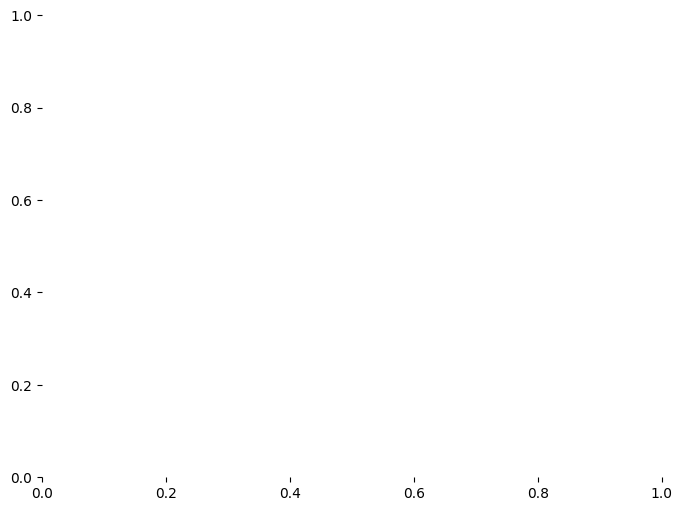

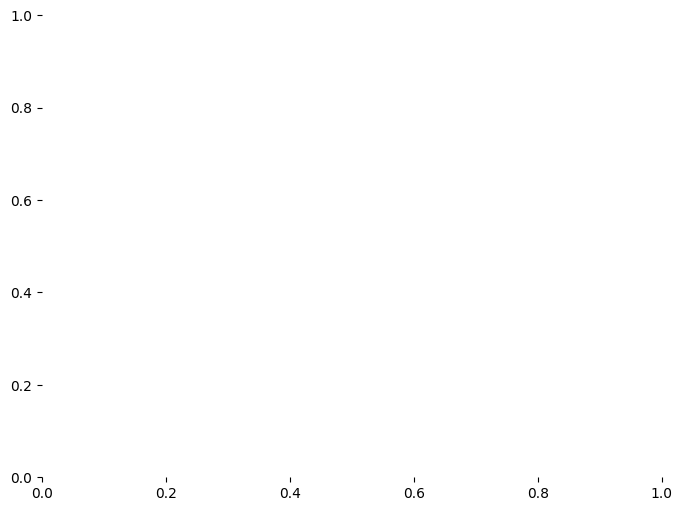

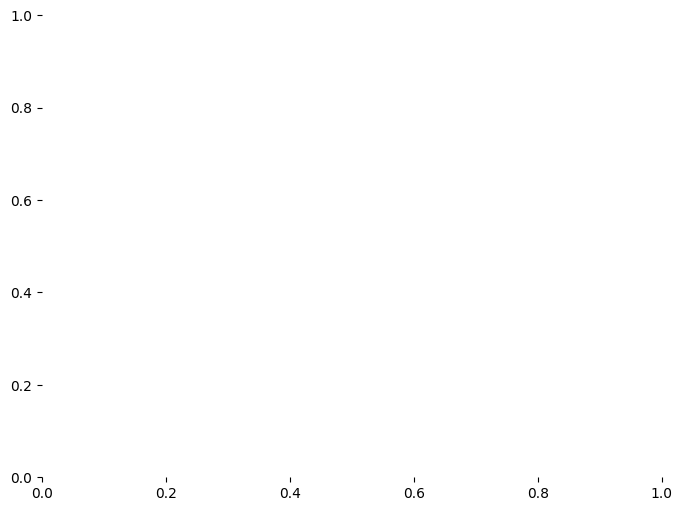

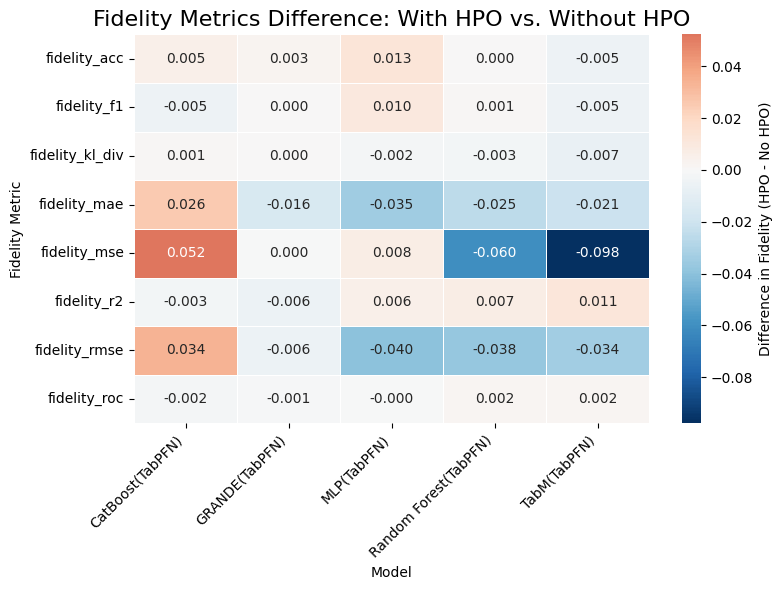

In [87]:
# Example usage:

# 1. Compare fidelity metrics for binary classification with regression distillation
fidelity_hpo_comparison = display_fidelity_hpo_comparison_table(
    original_task_filter='binary', 
    student_task_filter='regression'
)